<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using One-Hot MLP
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup> Alexander S. Garruss<sup>2,3*</sup>,, Luis R. Soenksen<sup>1,2*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a Multi-Layered Perceptron (MLP) deep-learning architecture based on RNA tensors to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-03-30_toehold_dataset_proc_with_params.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences: organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1)**  Toehold DNA Sequence <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training we select our input sequence vector start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example > *     in particular we use DS_1.*

> #### Output vector is defined as:
> **OUT_1)** ON, Off & ON-OFF State values derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if a deep learning network can be used to predict toehold switch ON/OFF functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### STEP 0)   Loading, Import Modules & Core helper functions
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
## Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

#RNAssp
import src.RNAssp.rna as rnassp

# Import Tensorflow
import tensorflow as tf

# Import Json
import json
import codecs

# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay
    ## NOTE: Install in conda enviroment: pip install git+https://github.com/raghakot/keras-vis.git -U

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

Using TensorFlow backend.


In [2]:
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix
    
#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available GPUs: 1


-----------------------------------------------------------------------------------------------------------------------------

### 1) Import Dataset & Define Raw Input(s)/Output(s)
> Full data CSV read, includes all necessary information to train and test

In [3]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
## Define general path to store all generated models
core_models_path = 'models/'
# Create Data folder if not existent
if not os.path.isdir(core_models_path):
    os.makedirs(core_models_path)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-07-08_toehold_dataset_proc_with_params_QC1.1.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [4]:
### Datata Sequence ID selection
id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols = 'seq_SwitchON_GFP'
output_cols = ['ON', 'OFF', 'ON_OFF']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = True

### Define data scaler (if any)
scaler_init = True
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'MLP_1D'

#Show sample of dataframe structure
data.head()

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
3  smallpox_tile_6492  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
4  smallpox_tile_2624  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTT  AACCAAACACACAAACGCAC   
4  ACATATTAGTAACTGTTTTCCATTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2    ...     Cbn1_off  Cbn2_off  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA    ...     0.000000  1.000000   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA    ...          NaN       NaN   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA    ...     1.000000  0.000000   
3  AAAAAAAATAACGTAGGACTACTACTTGGA  AACAGAGGAGA    ...     0.883458  0.116542   
4  AAAAAAAATGGAAAACAGTTACTAATATGT  AACAGAGGAGA    ...     0.815066  0.000000   

   Cbn3_off Cbn4_off        ON       OFF    ON_OFF QC_ON QC_OFF QC_ON_OFF  
0  0.000000      0.0       NaN  0.333333       NaN   NaN    NaN       NaN  
1       NaN      NaN       NaN       NaN       NaN   NaN    NaN       NaN  
2  0.000000      0.0  0.068295  0.000000  0.068295   2.0    1.1       1.1  
3  0.000000      0.0  0.000000  0.038847 -0.038847   1.1    2.0       1.1  
4  0.184934      0.0  0.080666  0.123289 -0.042624   2.0    3.0       2.0  

[5 rows x 99 columns]

-----------------------------------------------------------------------------------------------------------------------------

### 2) Definition of Pre-Processing Input(s)/Output(s) functions

> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [6]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
def pre_process_data (data, input_cols, output_cols, export_path, qc_level_threshold=1, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    # Define path to store input / output arrays
    tmp_data_path = 'data/tmp/'
    # Create Data folder if not existent
    if not os.path.isdir(tmp_data_path):
        os.makedirs(tmp_data_path)

# GENERATE & SAVE FULL INPUT VECTORS (only if not exists because it is a large file)
    tmp_data_input_path = (tmp_data_path + 'data_input_file_1d_' + input_cols + '.h5')
    if not os.path.exists(tmp_data_input_path):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        n_batch_samples = 10000 #We constrain process batches to this number to allow for progressive saving of large files
        n_batches = math.ceil(len(data[input_cols])/n_batch_samples)
        
        if n_batches>1:
            print('Processing in batches...')
            
        # Process and Append Save:
        with h5py.File(tmp_data_input_path, 'a') as hf:
            is_first=True
            for data_tmp in np.split(data[input_cols], n_batches):
                df_data_input_tmp = data_tmp.progress_apply(dna2onehot)
                data_input_tmp = np.array(list(df_data_input_tmp.values))
                if is_first==True:
                    dset = hf.create_dataset("input",  data=data_input_tmp, maxshape=(None, data_input_tmp.shape[1], data_input_tmp.shape[2]), chunks=(n_batches,data_input_tmp.shape[1], data_input_tmp.shape[2])) 
                    is_first=False
                else:
                    dset.resize((dset.shape[0]+data_input_tmp.shape[0],data_input_tmp.shape[1],data_input_tmp.shape[2]))  
                    dset[-data_input_tmp.shape[0]:,:,:] = data_input_tmp

# GENERATE & SAVE FULL OUTPUT VECTORS
    output_ids = "_".join(str(x) for x in output_cols)
    tmp_data_output_path = (tmp_data_path + 'data_output_file_QC_' + str(qc_level_threshold).replace('.','-') + '_' + output_ids + '.h5')
    
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output = data[data.QC_ON_OFF >= qc_level_threshold]
    df_data_output= df_data_output[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.as_matrix().astype('float32')
    #Save:
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=data_output)

    # LOAD FULL INPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_input_path, 'r') as hf:
        data_input = hf['input'][:]
        data_input = data_input[df_data_output.index.values][:][:]
    
    # LOAD FULL OUTPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_output_path, 'r') as hf:
        data_output = hf['output'][:]
        data_output_orig = data_output
        #Pre-process data (scaler)
        if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
    
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = data[input_cols][df_data_output.index.values]
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()
        
        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

        # Display Output Values
        for index,item in enumerate(output_cols):
            # Display Output Values
            plt.figure()
            print('Distribution of ' + str(item) + ' Values')
            sns.distplot(data_output[:,index], kde=True, rug=False)
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_dist.png", bbox_inches='tight', dpi=300)
        
        if scaler_init==True:           
            ## COMPUTE EFFECT OF SCALER
            # Difference between the transformed toehold output values and original toehold output values, 
            # then compute the absolute percentage difference for diplay
            test_metrics = np.zeros((data_output_orig.shape[1],3))
            diff = data_output_orig - data_output
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            
            # Plot: Scaled Output values vs. Original values and get R2 value
            for index,item in enumerate(output_cols):
                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(data_output_orig[:,index], data_output[:,index])
                
                # Display Output Values
                x=np.squeeze(data_output_orig[:,index])
                y=np.squeeze(data_output[:,index])
                
                # Display Output Values
                print('')
                print("" + item + " Mean_absolute_error (TRANSFORMATION): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('TRANSFORMED Values vs. ORIGINAL values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$ORIGINAL$", "$TRANSFORMED$");

                # save the figure
                g.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_data_scaling_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(export_path + '/scaling_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(export_path + '/scaling_data',data_output_orig,data_output) 

    return data_input, data_output

-----------------------------------------------------------------------------------------------------------------------------

### 3) Definition of Model Architecture Function
> Funtion to create keras model architecture
> Helper functions to save and evaluate models

In [7]:
### Function to create Keras MLP for regression prediction
def create_mlp(width, height, regress=False):
    # Define our MLP network
    inputShape = (width, height) #DNA/RNA input sequence (one hot encoded)
    inputs = Input(shape=inputShape)
    chanDim = -1
    dropout_init = 0.2
    
    # Define dense layers
    x = inputs
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)

    x = Dense(32, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    # Check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)
        
    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [8]:
# Helper functions to save/load model and training history
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
        
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

def save_model(model, identifier):
    ## MODEL SAVING ON WORKING FOLDER
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights_'+str(identifier)+'.h5')
    with open(os.path.abspath(model_path)+'/model_architecture_'+str(identifier)+'.json', 'w') as f:
        f.write(model.to_json())

    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model_'+str(identifier)+'.h5')

In [9]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

### 4) Definition of BASE Model Generator (with Training using Manual Verification Dataset & Evaluation)
> For use with a priori training (suggested: 75%) & testing (suggested: 25%) split, with internal training validation from the training set (10% or the 75%)
> For evaluation on unseen testing data (suggested: 25%) 
> This generator function generates and saves model in target path

In [10]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_model(model_path, trainX, testX, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1+ngpus) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
        
    ## Callbacks for training:
    #  Save the model weights to the same file, if and only if the validation accuracy improves.
    checkpoint_file_name = "model_checkpoint_weights.h5"
    model_checkpoint_path = os.path.join(os.path.abspath(model_path), checkpoint_file_name)
    
    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = verbose_init, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init),
                          TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = False, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]    
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width, height) = np.shape(trainX[0])
    
    
    # Define core model on CPU
    with tf.device("/cpu:0"):  
        model = create_mlp(width, height, regress=False)
        
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.001, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
        
    ## Parallel computing (if multiple GPUs are available)
    # Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        model_history = model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # make the model parallel
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        
        if loss_init=="r2":
            parallel_model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
        elif loss_init =="wmae":
            parallel_model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
        else:
            parallel_model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
        model_history = parallel_model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)    
                    

    ## MODEL SAVING
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights.h5')
    with open(os.path.abspath(model_path)+'/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model.h5')
    # Save model graph to file
    model_graph_path = model_path + '/model_graph.png'
    #plot_model(model, to_file=model_graph_path, show_shapes=True, show_layer_names=True)
    # Save training history
    saveHist(model_path + '/model_history', model_history)
        
    ## MODEL LOADING (to ensure it works)
    # Option 1: Load latest model via Weights + Architecture
    #with open(os.path.abspath(model_path)+'/model_architecture.json', 'r') as f:
    #    model = model_from_json(f.read())
    #    model.load_weights(os.path.abspath(model_path)+'/model_weights.h5')
    # Option 2: Load latest model via entire model at once
    if loss_init=="r2":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_r2_loss': custom_r2_loss})
    elif loss_init =="wmae":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_wmae_loss': custom_wmae_loss})
    else:
        model = load_model(os.path.abspath(model_path)+'/model.h5')
    
    # Load model training history
    model_history = loadHist(model_path + '/model_history')
    
    # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],3)) #Empty matrix for model performance metrics
    
    # GENERATE PREDICTIONS
    if testX.size > 0:
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        testX_Preds = model.predict(testX)
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY)
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history['mean_squared_error'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history['mean_absolute_error'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history['mean_absolute_percentage_error'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history['cosine_proximity'])
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(model_path + "/model_training_metrics.png", bbox_inches='tight', dpi=300)

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history["loss"], label="train_loss")
            plt.plot(N, model_history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history["acc"], label="train_acc")
            plt.plot(N, model_history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history["mean_squared_error"], label="train_mse")
            plt.plot(N, model_history["val_mean_squared_error"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history["mean_absolute_error"], label="train_mae")
            plt.plot(N, model_history["val_mean_absolute_error"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history["mean_absolute_percentage_error"], label="train_mape")
            plt.plot(N, model_history["val_mean_absolute_percentage_error"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history["cosine_proximity"], label="train_cp")
            plt.plot(N, model_history["val_cosine_proximity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
            # Save figure
            plt.savefig(model_path + "/model_training_compilation.png", bbox_inches='tight', dpi=300)
            
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

                # save the figure
                g.savefig(model_path + "/model_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(model_path + '/test_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(model_path + '/test_data',testX_Preds, testY) 
                
    return model, model_history, testX_Preds, test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 5)  Definition of k-Fold Cross Validated Model Generator (with Ensemble Training, Evaluation & Full Deployment)

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of the performance of a model on unseen data. 

> It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 

> The performance measure accross all models in the unseen data for each fold

> The performance is printed for each model and it is stored

> A final deployment model trained in all data (no testing) is provided for evaluation in future data

In [11]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_crossval_model(model_cv_path, X, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X,Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 3))
    deploy_test_metrics = np.zeros((Y.shape[1],3))
    
    # Perform n-fold crossvalidated training and evaluation
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        # Define folder for CV fold model
        model_cv_fold_path = model_cv_path + '/Fold' + str(j) 

        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated tenerate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A working model will be made using 75% of the data for training and 25% for further testing.
        # A deploy model will be also trained using all available data without testing
        trainX_cv = X[train_idx]
        trainY_cv = Y[train_idx]
        testX_cv = X[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_model(model_cv_fold_path, trainX_cv, testX_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(ngpus+1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # SAVE METRICS (.npy file)
    np.save(model_cv_path + '/cv_test_metrics',cv_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_cv_path + '/cv_test_data',cv_preds, Y)
            
    
    ## DEFINE FOLDER FOR DEPLOY MODEL
    model_deploy_path = model_cv_path + '/deploy'
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_deploy_path):
        os.makedirs(model_deploy_path)
    print('')
    print('Generating deployment model...')
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R2 (Coefficient of Determination)
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R2: '+ str(apd_r2[index]))
            print('')
            
            if scaler_init == True:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
            else:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", stat_func=r2)
            g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
            g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
            g.ax_joint.collections[0].set_alpha(0)
            g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");
            
            # save the figure
            g.savefig(model_deploy_path + "/model_ensemble_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
    
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
            
    # SAVE METRICS (.npy file)
    np.save(model_deploy_path + '/deploy_test_metrics', deploy_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_deploy_path + '/deploy_test_data',cv_preds, Y)
    
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (90%), validation (10%), testing (0%) splits 
    (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.0, random_state=seed)
    
    # Create model function according to generator function
    model, model_history, _ , _ = generate_model(model_deploy_path, trainX, testX, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 6) Loop through all model(s) generation depending on: Model folder, Chosen input(s)/output(s), QC levels & k-fold bins

> Define helper function for master loop

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of performance

In [12]:
#Definer function for full model analysis and reporting
def execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
        
        ### 1) Create all folders per iteration
        ## Define general path to store all generated models
        model_path = core_models_path + model_name.lower()+ '/' + model_name.upper() +'-' + str('-'.join(output_cols) + '-QC' + str(qc_level).replace('.','-') + '/')
        print ("Iteration " + str(j) + ") Building analysis in: " + model_path) 
        # Create Data folder if not existent
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        
        ## SAVE INIT PARAMETER SAVING ON WORKING FOLDER
        init_param_path = model_path + "init_parameters.txt"
        with open(init_param_path, "w+") as variable_file:
            variable_file.write("data_folder = " + str(data_folder)+ '\n' +\
                                "core_models_path = " + str(core_models_path)+ '\n' +\
                                "data_filename = " + str(data_filename)+ '\n' +\
                                "seed = " + str(seed)+ '\n' +\
                                "model_name = " + str(model_name)+ '\n' +\
                                "input_cols = " + str(input_cols)+ '\n' +\
                                "output_cols = " + str(output_cols)+ '\n' +\
                                "qc_level = " + str(qc_level)+ '\n' +\
                                "n_foldCV = " + str(n_foldCV)+ '\n' +\
                                "scaler = " + str(scaler)+ '\n' +\
                                "loss_init = " + str(loss_init)+ '\n' +\
                                "verbose_init = " + str(verbose_init)+ '\n' +\
                                "evaluate  =  " + str(evaluate)+ '\n' +\
                                "display_init =  " + str(display_init)+ '\n')
        
        ## Define path to store base model
        model_base_path = model_path + 'base'
        # Create Data folder if not existent
        if not os.path.isdir(model_base_path):
            os.makedirs(model_base_path)

        ## Define path to store crossvalidation models
        model_cv_path = model_path + 'crossval'
        # Create Data folder if not existent
        if not os.path.isdir(model_cv_path):
            os.makedirs(model_cv_path)

        ## Define path to store all generated model inputs
        model_input_path = model_path + 'input'
        # Create Data folder if not existent
        if not os.path.isdir(model_input_path):
            os.makedirs(model_input_path)
            
        ## Define path to store all generated model outputs
        model_output_path = model_path + 'output'
        # Create Data folder if not existent
        if not os.path.isdir(model_output_path):
            os.makedirs(model_output_path)
    
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input, data_output = pre_process_data (data, input_cols, output_cols, model_input_path, qc_level_threshold=qc_level, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual model function according to generator function, train it and display architecture
        if doTrain==True:
            # Partition the data into training (75%) and testing (25%) splits
            (trainX, testX, trainY, testY) = train_test_split(data_input, data_output, test_size=0.25, random_state=seed)
            # Generate, Train, Evaluate, Save and Display Model
            model, model_history, testX_Preds, test_metrics = generate_model(model_base_path, trainX, testX, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if n_foldCV>0:
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_crossval_model(model_cv_path, data_input, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
    ## MODEL SAVING ON DATED BACKUP FOLDER
    # Save the entire current model folder to a backup folder
    source_model_path = core_models_path + model_name + '/'
    backup_model_path = 'backup/' + source_model_path +  datetime.now().strftime('%Y%m%d') + '_' + datetime.now().strftime('%H%M')
    ## Create folder to store model (if not existent)
    if not os.path.isdir(backup_model_path):
        os.makedirs(backup_model_path)
    # Copy all contents to dated backup
    copy_full_dir(source_model_path, backup_model_path)

Iteration 0) Building analysis in: models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/
Number of sequences retrieved: 91534

EXAMPLE OF INPUT ONE-HOT TOEHOLD
[[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 

Epoch 1/300


61785/61785 [==============================] - 4s 60us/step - loss: 0.2069 - mean_squared_error: 0.0656 - mean_absolute_error: 0.2069 - mean_absolute_percentage_error: 14388020.9823 - cosine_proximity: -0.9204 - acc: 0.4666 - val_loss: 0.1940 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 12153783.3194 - val_cosine_proximity: -0.9247 - val_acc: 0.5196

Epoch 00001: val_loss improved from inf to 0.19400, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 2/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1941 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12906918.4049 - cosine_proximity: -0.9219 - acc: 0.5051 - val_loss: 0.1942 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 11185859.0610 - val_cosine_proximity: -0.9222 - val_acc: 0.5044

Epoch 00002: val_loss did not improve from 0.19400
Epoch 3/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12794263.8592 - cosine_proximity: -0.9216 - acc: 0.5059 - val_loss: 0.1946 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1946 - val_mean_absolute_percentage_error: 11352373.0753 - val_cosine_proximity: -0.9226 - val_acc: 0.5044

Epoch 00003: val_loss did not improve from 0.19400
Epoch 4/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12782124.6024 - cosine_proximity: -0.9215 - acc: 0.5050 - val_loss: 0.1936 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 11999022.4393 - val_cosine_proximity: -0.9235 - val_acc: 0.5148

Epoch 00004: val_loss improved from 0.19400 to 0.19364, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 5/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1941 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12799781.3428 - cosine_proximity: -0.9216 - acc: 0.5084 - val_loss: 0.1949 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 12299542.1028 - val_cosine_proximity: -0.9216 - val_acc: 0.4714

Epoch 00005: val_loss did not improve from 0.19364
Epoch 6/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12816382.8836 - cosine_proximity: -0.9217 - acc: 0.5060 - val_loss: 0.1939 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.1939 - val_mean_absolute_percentage_error: 11746289.9167 - val_cosine_proximity: -0.9238 - val_acc: 0.5382

Epoch 00006: val_loss did not improve from 0.19364
Epoch 7/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12807130.7953 - cosine_proximity: -0.9216 - acc: 0.5040 - val_loss: 0.1937 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 12666564.6794 - val_cosine_proximity: -0.9238 - val_acc: 0.5005

Epoch 00007: val_loss did not improve from 0.19364
Epoch 8/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12828031.5771 - cosine_proximity: -0.9217 - acc: 0.5062 - val_loss: 0.1939 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1939 - val_mean_absolute_percentage_error: 11341993.4299 - val_cosine_proximity: -0.9230 - val_acc: 0.5076

Epoch 00008: val_loss did not improve from 0.19364
Epoch 9/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12833957.4322 - cosine_proximity: -0.9215 - acc: 0.5056 - val_loss: 0.1934 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1934 - val_mean_absolute_percentage_error: 12192126.1457 - val_cosine_proximity: -0.9234 - val_acc: 0.5039

Epoch 00009: val_loss improved from 0.19364 to 0.19342, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 10/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12804091.1128 - cosine_proximity: -0.9215 - acc: 0.5043 - val_loss: 0.1938 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 12774151.8214 - val_cosine_proximity: -0.9234 - val_acc: 0.5049

Epoch 00010: val_loss did not improve from 0.19342
Epoch 11/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12830468.4071 - cosine_proximity: -0.9216 - acc: 0.5050 - val_loss: 0.1940 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 11699374.6278 - val_cosine_proximity: -0.9220 - val_acc: 0.4619

Epoch 00011: val_loss did not improve from 0.19342
Epoch 12/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12749623.3499 - cosine_proximity: -0.9217 - acc: 0.5067 - val_loss: 0.1937 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 12055592.8728 - val_cosine_proximity: -0.9234 - val_acc: 0.5004

Epoch 00012: val_loss did not improve from 0.19342
Epoch 13/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12822193.8091 - cosine_proximity: -0.9218 - acc: 0.5070 - val_loss: 0.1941 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1941 - val_mean_absolute_percentage_error: 12080356.2908 - val_cosine_proximity: -0.9222 - val_acc: 0.4712

Epoch 00013: val_loss did not improve from 0.19342
Epoch 14/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12809971.2255 - cosine_proximity: -0.9216 - acc: 0.5043 - val_loss: 0.1951 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 11086897.4660 - val_cosine_proximity: -0.9215 - val_acc: 0.5425

Epoch 00014: val_loss did not improve from 0.19342
Epoch 15/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12761238.7639 - cosine_proximity: -0.9215 - acc: 0.5055 - val_loss: 0.1938 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 11340451.2778 - val_cosine_proximity: -0.9222 - val_acc: 0.4775

Epoch 00015: val_loss did not improve from 0.19342
Epoch 16/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12802327.7253 - cosine_proximity: -0.9216 - acc: 0.5081 - val_loss: 0.1934 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.1934 - val_mean_absolute_percentage_error: 11779573.3393 - val_cosine_proximity: -0.9232 - val_acc: 0.4940

Epoch 00016: val_loss improved from 0.19342 to 0.19335, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 17/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12772789.9531 - cosine_proximity: -0.9214 - acc: 0.5040 - val_loss: 0.1943 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 13214298.4259 - val_cosine_proximity: -0.9229 - val_acc: 0.4854

Epoch 00017: val_loss did not improve from 0.19335
Epoch 18/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12808788.5203 - cosine_proximity: -0.9217 - acc: 0.5041 - val_loss: 0.1937 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 11352745.9056 - val_cosine_proximity: -0.9228 - val_acc: 0.5075

Epoch 00018: val_loss did not improve from 0.19335
Epoch 19/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12791244.8690 - cosine_proximity: -0.9215 - acc: 0.5076 - val_loss: 0.1946 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1946 - val_mean_absolute_percentage_error: 10973216.9270 - val_cosine_proximity: -0.9226 - val_acc: 0.5021

Epoch 00019: val_loss did not improve from 0.19335
Epoch 20/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12796699.1506 - cosine_proximity: -0.9216 - acc: 0.5064 - val_loss: 0.1939 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.1939 - val_mean_absolute_percentage_error: 12857150.4408 - val_cosine_proximity: -0.9236 - val_acc: 0.5114

Epoch 00020: val_loss did not improve from 0.19335
Epoch 21/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12817042.7729 - cosine_proximity: -0.9216 - acc: 0.5064 - val_loss: 0.1936 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 11617790.3385 - val_cosine_proximity: -0.9231 - val_acc: 0.5247

Epoch 00021: val_loss did not improve from 0.19335
Epoch 22/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12771711.6430 - cosine_proximity: -0.9215 - acc: 0.5035 - val_loss: 0.1937 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 11924455.2941 - val_cosine_proximity: -0.9237 - val_acc: 0.5251

Epoch 00022: val_loss did not improve from 0.19335
Epoch 23/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12826398.0510 - cosine_proximity: -0.9216 - acc: 0.5073 - val_loss: 0.1941 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1941 - val_mean_absolute_percentage_error: 11319002.3114 - val_cosine_proximity: -0.9226 - val_acc: 0.4870

Epoch 00023: val_loss did not improve from 0.19335
Epoch 24/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12812554.1096 - cosine_proximity: -0.9217 - acc: 0.5071 - val_loss: 0.1938 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 12534089.1400 - val_cosine_proximity: -0.9227 - val_acc: 0.4718

Epoch 00024: val_loss did not improve from 0.19335
Epoch 25/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12819778.9026 - cosine_proximity: -0.9216 - acc: 0.5051 - val_loss: 0.1945 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 12079239.0316 - val_cosine_proximity: -0.9233 - val_acc: 0.5092

Epoch 00025: val_loss did not improve from 0.19335
Epoch 26/300


61785/61785 [==============================] - 2s 35us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12827224.4528 - cosine_proximity: -0.9217 - acc: 0.5048 - val_loss: 0.1943 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 11170355.2871 - val_cosine_proximity: -0.9233 - val_acc: 0.5187

Epoch 00026: val_loss did not improve from 0.19335
Epoch 27/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1938 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12793189.7212 - cosine_proximity: -0.9218 - acc: 0.5062 - val_loss: 0.1935 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.1935 - val_mean_absolute_percentage_error: 12575327.9991 - val_cosine_proximity: -0.9234 - val_acc: 0.4902

Epoch 00027: val_loss did not improve from 0.19335
Epoch 28/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12788248.8992 - cosine_proximity: -0.9217 - acc: 0.5068 - val_loss: 0.1934 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1934 - val_mean_absolute_percentage_error: 11861072.9384 - val_cosine_proximity: -0.9237 - val_acc: 0.5052

Epoch 00028: val_loss did not improve from 0.19335
Epoch 29/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12755463.3806 - cosine_proximity: -0.9216 - acc: 0.5060 - val_loss: 0.1934 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1934 - val_mean_absolute_percentage_error: 12378386.1066 - val_cosine_proximity: -0.9240 - val_acc: 0.5125

Epoch 00029: val_loss improved from 0.19335 to 0.19335, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 30/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12820630.1324 - cosine_proximity: -0.9217 - acc: 0.5076 - val_loss: 0.1938 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 13080350.7886 - val_cosine_proximity: -0.9235 - val_acc: 0.4979

Epoch 00030: val_loss did not improve from 0.19335
Epoch 31/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12820761.0318 - cosine_proximity: -0.9217 - acc: 0.5054 - val_loss: 0.1946 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1946 - val_mean_absolute_percentage_error: 12117301.7806 - val_cosine_proximity: -0.9230 - val_acc: 0.5111

Epoch 00031: val_loss did not improve from 0.19335
Epoch 32/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12824414.1726 - cosine_proximity: -0.9217 - acc: 0.5063 - val_loss: 0.1938 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 11313842.5122 - val_cosine_proximity: -0.9217 - val_acc: 0.4721

Epoch 00032: val_loss did not improve from 0.19335
Epoch 33/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12770632.5836 - cosine_proximity: -0.9215 - acc: 0.5047 - val_loss: 0.1938 - val_mean_squared_error: 0.0611 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 12622943.9551 - val_cosine_proximity: -0.9236 - val_acc: 0.5069

Epoch 00033: val_loss did not improve from 0.19335
Epoch 34/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12783769.1685 - cosine_proximity: -0.9217 - acc: 0.5046 - val_loss: 0.1936 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 11798191.8465 - val_cosine_proximity: -0.9235 - val_acc: 0.5260

Epoch 00034: val_loss did not improve from 0.19335
Epoch 35/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12774407.5508 - cosine_proximity: -0.9216 - acc: 0.5075 - val_loss: 0.1939 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1939 - val_mean_absolute_percentage_error: 12152506.8411 - val_cosine_proximity: -0.9232 - val_acc: 0.4852

Epoch 00035: val_loss did not improve from 0.19335
Epoch 36/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12811746.3482 - cosine_proximity: -0.9217 - acc: 0.5066 - val_loss: 0.1937 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 12099935.9939 - val_cosine_proximity: -0.9234 - val_acc: 0.4989

Epoch 00036: val_loss did not improve from 0.19335
Epoch 37/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12804847.8865 - cosine_proximity: -0.9218 - acc: 0.5045 - val_loss: 0.1936 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 11910942.4530 - val_cosine_proximity: -0.9232 - val_acc: 0.5094

Epoch 00037: val_loss did not improve from 0.19335
Epoch 38/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12791857.9090 - cosine_proximity: -0.9216 - acc: 0.5062 - val_loss: 0.1935 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1935 - val_mean_absolute_percentage_error: 12143523.5012 - val_cosine_proximity: -0.9234 - val_acc: 0.5085

Epoch 00038: val_loss did not improve from 0.19335
Epoch 39/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12842367.0186 - cosine_proximity: -0.9216 - acc: 0.5054 - val_loss: 0.1938 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 11707316.2695 - val_cosine_proximity: -0.9234 - val_acc: 0.5129

Epoch 00039: val_loss did not improve from 0.19335
Epoch 40/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1939 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12812719.2097 - cosine_proximity: -0.9216 - acc: 0.5055 - val_loss: 0.1937 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 12667975.0829 - val_cosine_proximity: -0.9232 - val_acc: 0.4875

Epoch 00040: val_loss did not improve from 0.19335
Epoch 41/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12802038.2518 - cosine_proximity: -0.9216 - acc: 0.5056 - val_loss: 0.1939 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1939 - val_mean_absolute_percentage_error: 11200656.8999 - val_cosine_proximity: -0.9217 - val_acc: 0.4739

Epoch 00041: val_loss did not improve from 0.19335
Epoch 42/300


61785/61785 [==============================] - 2s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12790576.3544 - cosine_proximity: -0.9217 - acc: 0.5087 - val_loss: 0.1942 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 11953685.1065 - val_cosine_proximity: -0.9235 - val_acc: 0.5222

Epoch 00042: val_loss did not improve from 0.19335
Epoch 43/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12828108.1509 - cosine_proximity: -0.9217 - acc: 0.5055 - val_loss: 0.1941 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1941 - val_mean_absolute_percentage_error: 11466308.0230 - val_cosine_proximity: -0.9222 - val_acc: 0.4792

Epoch 00043: val_loss did not improve from 0.19335
Epoch 44/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1938 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12766040.0589 - cosine_proximity: -0.9217 - acc: 0.5073 - val_loss: 0.1944 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 13255937.0651 - val_cosine_proximity: -0.9226 - val_acc: 0.4838

Epoch 00044: val_loss did not improve from 0.19335
Epoch 45/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12825263.9490 - cosine_proximity: -0.9216 - acc: 0.5067 - val_loss: 0.1937 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 12175080.9384 - val_cosine_proximity: -0.9241 - val_acc: 0.5289

Epoch 00045: val_loss did not improve from 0.19335
Epoch 46/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12773959.7517 - cosine_proximity: -0.9217 - acc: 0.5071 - val_loss: 0.1938 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 12074531.7760 - val_cosine_proximity: -0.9235 - val_acc: 0.5181

Epoch 00046: val_loss did not improve from 0.19335
Epoch 47/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12769838.0204 - cosine_proximity: -0.9216 - acc: 0.5072 - val_loss: 0.1942 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 11375374.5929 - val_cosine_proximity: -0.9230 - val_acc: 0.5063

Epoch 00047: val_loss did not improve from 0.19335
Epoch 48/300


61785/61785 [==============================] - 2s 38us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12794482.9512 - cosine_proximity: -0.9217 - acc: 0.5057 - val_loss: 0.1937 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 11835637.6921 - val_cosine_proximity: -0.9231 - val_acc: 0.4983

Epoch 00048: val_loss did not improve from 0.19335
Epoch 49/300


61785/61785 [==============================] - 2s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12775105.7069 - cosine_proximity: -0.9216 - acc: 0.5046 - val_loss: 0.1938 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.1938 - val_mean_absolute_percentage_error: 12234506.3452 - val_cosine_proximity: -0.9237 - val_acc: 0.5194

Epoch 00049: val_loss did not improve from 0.19335
Epoch 00049: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18189503 (SD: 0.1626549)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.65033114
Spearman Correlation: 0.6455422028940492
R2: 0.4229306

OFF Mean_absolute_error (TEST): 0.12728885 (SD: 0.13926788)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5598348
Spearman Correlation: 0.5312958110033116
R2: 0.313415

ON_OFF Mean_absolute_error (TEST): 0.19029528 (SD: 0.15442377)

EXPERIMEN

Epoch 1/300


74141/74141 [==============================] - 3s 38us/step - loss: 0.2058 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2058 - mean_absolute_percentage_error: 14231547.7006 - cosine_proximity: -0.9201 - acc: 0.4695 - val_loss: 0.1956 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14127872.3557 - val_cosine_proximity: -0.9250 - val_acc: 0.5138

Epoch 00001: val_loss improved from inf to 0.19562, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 2/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12806846.2937 - cosine_proximity: -0.9219 - acc: 0.5043 - val_loss: 0.1953 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13632621.6752 - val_cosine_proximity: -0.9248 - val_acc: 0.5294

Epoch 00002: val_loss improved from 0.19562 to 0.19535, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 3/300


74141/74141 [==============================] - 3s 37us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12731846.3090 - cosine_proximity: -0.9218 - acc: 0.5033 - val_loss: 0.1961 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 12994687.7849 - val_cosine_proximity: -0.9247 - val_acc: 0.5278

Epoch 00003: val_loss did not improve from 0.19535
Epoch 4/300


74141/74141 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12714702.7103 - cosine_proximity: -0.9216 - acc: 0.5042 - val_loss: 0.1957 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14226473.2840 - val_cosine_proximity: -0.9241 - val_acc: 0.5134

Epoch 00004: val_loss did not improve from 0.19535
Epoch 5/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12751231.9709 - cosine_proximity: -0.9217 - acc: 0.5027 - val_loss: 0.1956 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14111643.3700 - val_cosine_proximity: -0.9241 - val_acc: 0.5137

Epoch 00005: val_loss did not improve from 0.19535
Epoch 6/300


74141/74141 [==============================] - 3s 37us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12728671.5510 - cosine_proximity: -0.9216 - acc: 0.5025 - val_loss: 0.1954 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13074934.2743 - val_cosine_proximity: -0.9247 - val_acc: 0.5390

Epoch 00006: val_loss did not improve from 0.19535
Epoch 7/300


74141/74141 [==============================] - 3s 40us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12714052.5541 - cosine_proximity: -0.9217 - acc: 0.5023 - val_loss: 0.1954 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13211287.9619 - val_cosine_proximity: -0.9245 - val_acc: 0.5120

Epoch 00007: val_loss did not improve from 0.19535
Epoch 8/300


74141/74141 [==============================] - 3s 40us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12735509.9880 - cosine_proximity: -0.9218 - acc: 0.5039 - val_loss: 0.1958 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14005315.9325 - val_cosine_proximity: -0.9248 - val_acc: 0.5329

Epoch 00008: val_loss did not improve from 0.19535
Epoch 9/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12756585.8062 - cosine_proximity: -0.9217 - acc: 0.5031 - val_loss: 0.1954 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14270487.1986 - val_cosine_proximity: -0.9241 - val_acc: 0.5027

Epoch 00009: val_loss did not improve from 0.19535
Epoch 10/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12720087.5765 - cosine_proximity: -0.9217 - acc: 0.5032 - val_loss: 0.1955 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13599385.3824 - val_cosine_proximity: -0.9233 - val_acc: 0.4737

Epoch 00010: val_loss did not improve from 0.19535
Epoch 11/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12744493.6776 - cosine_proximity: -0.9217 - acc: 0.5026 - val_loss: 0.1955 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14307315.5725 - val_cosine_proximity: -0.9246 - val_acc: 0.5178

Epoch 00011: val_loss did not improve from 0.19535
Epoch 12/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12720373.3517 - cosine_proximity: -0.9218 - acc: 0.5035 - val_loss: 0.1964 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 13537769.1852 - val_cosine_proximity: -0.9240 - val_acc: 0.5257

Epoch 00012: val_loss did not improve from 0.19535
Epoch 13/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12755071.7454 - cosine_proximity: -0.9216 - acc: 0.5039 - val_loss: 0.1968 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.1968 - val_mean_absolute_percentage_error: 15215381.8135 - val_cosine_proximity: -0.9242 - val_acc: 0.5056

Epoch 00013: val_loss did not improve from 0.19535
Epoch 14/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12773881.1662 - cosine_proximity: -0.9218 - acc: 0.5030 - val_loss: 0.1958 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14568317.5055 - val_cosine_proximity: -0.9240 - val_acc: 0.4907

Epoch 00014: val_loss did not improve from 0.19535
Epoch 15/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12746781.4236 - cosine_proximity: -0.9216 - acc: 0.5039 - val_loss: 0.1966 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14861626.0898 - val_cosine_proximity: -0.9229 - val_acc: 0.4874

Epoch 00015: val_loss did not improve from 0.19535
Epoch 16/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12738072.7344 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1958 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13052336.0568 - val_cosine_proximity: -0.9235 - val_acc: 0.4805

Epoch 00016: val_loss did not improve from 0.19535
Epoch 17/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12693544.6647 - cosine_proximity: -0.9217 - acc: 0.5047 - val_loss: 0.1958 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14583369.9204 - val_cosine_proximity: -0.9243 - val_acc: 0.5194

Epoch 00017: val_loss did not improve from 0.19535
Epoch 18/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12701732.2530 - cosine_proximity: -0.9217 - acc: 0.5027 - val_loss: 0.1958 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14498449.9381 - val_cosine_proximity: -0.9245 - val_acc: 0.5172

Epoch 00018: val_loss did not improve from 0.19535
Epoch 19/300


74141/74141 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12719295.3764 - cosine_proximity: -0.9218 - acc: 0.5033 - val_loss: 0.1959 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14718716.2476 - val_cosine_proximity: -0.9250 - val_acc: 0.5143

Epoch 00019: val_loss did not improve from 0.19535
Epoch 20/300


74141/74141 [==============================] - 3s 40us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12726834.3227 - cosine_proximity: -0.9217 - acc: 0.5032 - val_loss: 0.1980 - val_mean_squared_error: 0.0659 - val_mean_absolute_error: 0.1980 - val_mean_absolute_percentage_error: 15635637.5108 - val_cosine_proximity: -0.9246 - val_acc: 0.5052

Epoch 00020: val_loss did not improve from 0.19535
Epoch 21/300


74141/74141 [==============================] - 3s 40us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12744872.2323 - cosine_proximity: -0.9218 - acc: 0.5052 - val_loss: 0.1956 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14299731.7851 - val_cosine_proximity: -0.9238 - val_acc: 0.5108

Epoch 00021: val_loss did not improve from 0.19535
Epoch 22/300


74141/74141 [==============================] - 3s 40us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12740123.1551 - cosine_proximity: -0.9217 - acc: 0.5036 - val_loss: 0.1965 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14984374.6303 - val_cosine_proximity: -0.9241 - val_acc: 0.5186

Epoch 00022: val_loss did not improve from 0.19535
Epoch 00022: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18369979 (SD: 0.16580889)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6403618
Spearman Correlation: 0.6344629852030388
R2: 0.4100632

OFF Mean_absolute_error (TEST): 0.12642416 (SD: 0.13372451)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5797413
Spearman Correlation: 0.5456322849247341
R2: 0.33609998

ON_OFF Mean_absolute_error (TEST): 0.19004992 (SD: 0.15656634)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.2052 - mean_squared_error: 0.0649 - mean_absolute_error: 0.2052 - mean_absolute_percentage_error: 14133303.2454 - cosine_proximity: -0.9209 - acc: 0.4740 - val_loss: 0.1952 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14125571.9170 - val_cosine_proximity: -0.9258 - val_acc: 0.5395

Epoch 00001: val_loss improved from inf to 0.19520, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12738402.6925 - cosine_proximity: -0.9221 - acc: 0.5033 - val_loss: 0.1951 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13737272.3210 - val_cosine_proximity: -0.9245 - val_acc: 0.4977

Epoch 00002: val_loss improved from 0.19520 to 0.19509, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12726448.5143 - cosine_proximity: -0.9218 - acc: 0.5024 - val_loss: 0.1951 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13977848.6210 - val_cosine_proximity: -0.9249 - val_acc: 0.5191

Epoch 00003: val_loss did not improve from 0.19509
Epoch 4/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12725019.3382 - cosine_proximity: -0.9217 - acc: 0.5028 - val_loss: 0.1959 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14814488.5147 - val_cosine_proximity: -0.9239 - val_acc: 0.4984

Epoch 00004: val_loss did not improve from 0.19509
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12736148.9182 - cosine_proximity: -0.9217 - acc: 0.5011 - val_loss: 0.1957 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14339484.2520 - val_cosine_proximity: -0.9241 - val_acc: 0.4791

Epoch 00005: val_loss did not improve from 0.19509
Epoch 6/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12713271.7092 - cosine_proximity: -0.9219 - acc: 0.5032 - val_loss: 0.1949 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 13638312.2918 - val_cosine_proximity: -0.9250 - val_acc: 0.5178

Epoch 00006: val_loss improved from 0.19509 to 0.19491, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12714297.2487 - cosine_proximity: -0.9219 - acc: 0.5012 - val_loss: 0.1954 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13679437.9223 - val_cosine_proximity: -0.9246 - val_acc: 0.5194

Epoch 00007: val_loss did not improve from 0.19491
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12704749.2667 - cosine_proximity: -0.9219 - acc: 0.5054 - val_loss: 0.1956 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14617596.9813 - val_cosine_proximity: -0.9239 - val_acc: 0.4921

Epoch 00008: val_loss did not improve from 0.19491
Epoch 9/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12741939.9132 - cosine_proximity: -0.9217 - acc: 0.5039 - val_loss: 0.1951 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13778323.8106 - val_cosine_proximity: -0.9245 - val_acc: 0.4908

Epoch 00009: val_loss did not improve from 0.19491
Epoch 10/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12676058.1085 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1958 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14679719.7203 - val_cosine_proximity: -0.9241 - val_acc: 0.5226

Epoch 00010: val_loss did not improve from 0.19491
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12670056.4918 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1953 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13504204.0418 - val_cosine_proximity: -0.9247 - val_acc: 0.5100

Epoch 00011: val_loss did not improve from 0.19491
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12701742.0343 - cosine_proximity: -0.9220 - acc: 0.5025 - val_loss: 0.1951 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 14113339.3848 - val_cosine_proximity: -0.9248 - val_acc: 0.5121

Epoch 00012: val_loss did not improve from 0.19491
Epoch 13/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12686043.8506 - cosine_proximity: -0.9218 - acc: 0.5030 - val_loss: 0.1961 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 15281993.8422 - val_cosine_proximity: -0.9247 - val_acc: 0.5195

Epoch 00013: val_loss did not improve from 0.19491
Epoch 14/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12708255.8768 - cosine_proximity: -0.9219 - acc: 0.5024 - val_loss: 0.1955 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14168865.7359 - val_cosine_proximity: -0.9246 - val_acc: 0.5205

Epoch 00014: val_loss did not improve from 0.19491
Epoch 15/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12714668.5655 - cosine_proximity: -0.9220 - acc: 0.5031 - val_loss: 0.1961 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14944852.0816 - val_cosine_proximity: -0.9234 - val_acc: 0.5056

Epoch 00015: val_loss did not improve from 0.19491
Epoch 16/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12724489.8835 - cosine_proximity: -0.9217 - acc: 0.5001 - val_loss: 0.1962 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14537279.0066 - val_cosine_proximity: -0.9242 - val_acc: 0.5340

Epoch 00016: val_loss did not improve from 0.19491
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12674333.8669 - cosine_proximity: -0.9217 - acc: 0.5030 - val_loss: 0.1955 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14417685.0590 - val_cosine_proximity: -0.9247 - val_acc: 0.5222

Epoch 00017: val_loss did not improve from 0.19491
Epoch 18/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12727201.1602 - cosine_proximity: -0.9220 - acc: 0.5028 - val_loss: 0.1951 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 14199134.1957 - val_cosine_proximity: -0.9244 - val_acc: 0.5086

Epoch 00018: val_loss did not improve from 0.19491
Epoch 19/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12702914.4000 - cosine_proximity: -0.9217 - acc: 0.5027 - val_loss: 0.1952 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14102157.2731 - val_cosine_proximity: -0.9242 - val_acc: 0.5029

Epoch 00019: val_loss did not improve from 0.19491
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12668244.5982 - cosine_proximity: -0.9218 - acc: 0.5023 - val_loss: 0.1953 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13529409.8349 - val_cosine_proximity: -0.9240 - val_acc: 0.4854

Epoch 00020: val_loss did not improve from 0.19491
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12717486.8950 - cosine_proximity: -0.9217 - acc: 0.5044 - val_loss: 0.1963 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 15358862.7259 - val_cosine_proximity: -0.9243 - val_acc: 0.5084

Epoch 00021: val_loss did not improve from 0.19491
Epoch 22/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12704079.3577 - cosine_proximity: -0.9220 - acc: 0.5040 - val_loss: 0.1951 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 14007565.0323 - val_cosine_proximity: -0.9244 - val_acc: 0.4948

Epoch 00022: val_loss did not improve from 0.19491
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12671577.2075 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1961 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14828756.4647 - val_cosine_proximity: -0.9236 - val_acc: 0.4978

Epoch 00023: val_loss did not improve from 0.19491
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12716653.1927 - cosine_proximity: -0.9218 - acc: 0.5044 - val_loss: 0.1949 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 12966121.5290 - val_cosine_proximity: -0.9245 - val_acc: 0.5115

Epoch 00024: val_loss did not improve from 0.19491
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12694347.7655 - cosine_proximity: -0.9218 - acc: 0.5021 - val_loss: 0.1961 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14136978.0981 - val_cosine_proximity: -0.9244 - val_acc: 0.4846

Epoch 00025: val_loss did not improve from 0.19491
Epoch 26/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12687535.0630 - cosine_proximity: -0.9219 - acc: 0.5041 - val_loss: 0.1951 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13255692.2549 - val_cosine_proximity: -0.9242 - val_acc: 0.4971

Epoch 00026: val_loss did not improve from 0.19491
Epoch 00026: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18218264 (SD: 0.16812772)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6548181
Spearman Correlation: 0.6501650797948229
R2: 0.42878675

OFF Mean_absolute_error (TEST): 0.13034923 (SD: 0.14700074)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5714487
Spearman Correlation: 0.5535753861231526
R2: 0.3265536

ON_OFF Mean_absolute_error (TEST): 0.19235343 (SD: 0.15614988)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.2050 - mean_squared_error: 0.0648 - mean_absolute_error: 0.2050 - mean_absolute_percentage_error: 14066209.8570 - cosine_proximity: -0.9206 - acc: 0.4688 - val_loss: 0.1971 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 15021488.3676 - val_cosine_proximity: -0.9237 - val_acc: 0.4728

Epoch 00001: val_loss improved from inf to 0.19705, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12806267.1913 - cosine_proximity: -0.9220 - acc: 0.5025 - val_loss: 0.1957 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13506202.6040 - val_cosine_proximity: -0.9250 - val_acc: 0.5086

Epoch 00002: val_loss improved from 0.19705 to 0.19574, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12720582.9705 - cosine_proximity: -0.9218 - acc: 0.5032 - val_loss: 0.1966 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14911323.5902 - val_cosine_proximity: -0.9244 - val_acc: 0.5143

Epoch 00003: val_loss did not improve from 0.19574
Epoch 4/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12719614.7631 - cosine_proximity: -0.9218 - acc: 0.5048 - val_loss: 0.1970 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1970 - val_mean_absolute_percentage_error: 14587550.9381 - val_cosine_proximity: -0.9234 - val_acc: 0.5129

Epoch 00004: val_loss did not improve from 0.19574
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12742567.2857 - cosine_proximity: -0.9216 - acc: 0.5023 - val_loss: 0.1961 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14209535.6349 - val_cosine_proximity: -0.9246 - val_acc: 0.5202

Epoch 00005: val_loss did not improve from 0.19574
Epoch 6/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12734044.2347 - cosine_proximity: -0.9217 - acc: 0.5023 - val_loss: 0.1966 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 13365657.2668 - val_cosine_proximity: -0.9243 - val_acc: 0.5214

Epoch 00006: val_loss did not improve from 0.19574
Epoch 7/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1941 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12715512.1580 - cosine_proximity: -0.9217 - acc: 0.5009 - val_loss: 0.1963 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14689832.0189 - val_cosine_proximity: -0.9252 - val_acc: 0.5261

Epoch 00007: val_loss did not improve from 0.19574
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1942 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 12716374.1629 - cosine_proximity: -0.9215 - acc: 0.5014 - val_loss: 0.1961 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14332820.5846 - val_cosine_proximity: -0.9247 - val_acc: 0.5053

Epoch 00008: val_loss did not improve from 0.19574
Epoch 9/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12735480.1492 - cosine_proximity: -0.9217 - acc: 0.5031 - val_loss: 0.1969 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 14666824.1515 - val_cosine_proximity: -0.9256 - val_acc: 0.5324

Epoch 00009: val_loss did not improve from 0.19574
Epoch 10/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12720717.2868 - cosine_proximity: -0.9218 - acc: 0.5013 - val_loss: 0.1957 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13461906.7094 - val_cosine_proximity: -0.9253 - val_acc: 0.5388

Epoch 00010: val_loss improved from 0.19574 to 0.19573, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12725081.5892 - cosine_proximity: -0.9216 - acc: 0.5037 - val_loss: 0.1964 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 13621753.6970 - val_cosine_proximity: -0.9244 - val_acc: 0.4934

Epoch 00011: val_loss did not improve from 0.19573
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12689992.8935 - cosine_proximity: -0.9216 - acc: 0.5019 - val_loss: 0.1964 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 14548868.0748 - val_cosine_proximity: -0.9237 - val_acc: 0.4942

Epoch 00012: val_loss did not improve from 0.19573
Epoch 13/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12745260.7875 - cosine_proximity: -0.9217 - acc: 0.5017 - val_loss: 0.1959 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 13873525.2770 - val_cosine_proximity: -0.9243 - val_acc: 0.5044

Epoch 00013: val_loss did not improve from 0.19573
Epoch 14/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12734773.9962 - cosine_proximity: -0.9218 - acc: 0.5018 - val_loss: 0.1962 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13605679.0202 - val_cosine_proximity: -0.9250 - val_acc: 0.5320

Epoch 00014: val_loss did not improve from 0.19573
Epoch 15/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12735965.8052 - cosine_proximity: -0.9218 - acc: 0.5047 - val_loss: 0.1962 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14368355.8747 - val_cosine_proximity: -0.9252 - val_acc: 0.5195

Epoch 00015: val_loss did not improve from 0.19573
Epoch 16/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1942 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 12742979.6080 - cosine_proximity: -0.9218 - acc: 0.5031 - val_loss: 0.1959 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14315229.8699 - val_cosine_proximity: -0.9247 - val_acc: 0.5055

Epoch 00016: val_loss did not improve from 0.19573
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12710146.7348 - cosine_proximity: -0.9217 - acc: 0.5039 - val_loss: 0.1958 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13587509.8101 - val_cosine_proximity: -0.9251 - val_acc: 0.5297

Epoch 00017: val_loss did not improve from 0.19573
Epoch 18/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12736889.2414 - cosine_proximity: -0.9216 - acc: 0.5028 - val_loss: 0.1956 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13853159.1051 - val_cosine_proximity: -0.9255 - val_acc: 0.5329

Epoch 00018: val_loss improved from 0.19573 to 0.19563, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 19/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12724006.7079 - cosine_proximity: -0.9219 - acc: 0.5031 - val_loss: 0.1967 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 14835641.2542 - val_cosine_proximity: -0.9244 - val_acc: 0.5097

Epoch 00019: val_loss did not improve from 0.19563
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12718398.9025 - cosine_proximity: -0.9216 - acc: 0.5030 - val_loss: 0.1962 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14275180.3972 - val_cosine_proximity: -0.9242 - val_acc: 0.4890

Epoch 00020: val_loss did not improve from 0.19563
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12733428.8602 - cosine_proximity: -0.9217 - acc: 0.5018 - val_loss: 0.1969 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 14825224.2491 - val_cosine_proximity: -0.9245 - val_acc: 0.5064

Epoch 00021: val_loss did not improve from 0.19563
Epoch 22/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12710804.2706 - cosine_proximity: -0.9217 - acc: 0.5035 - val_loss: 0.1962 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14384476.2442 - val_cosine_proximity: -0.9247 - val_acc: 0.5015

Epoch 00022: val_loss did not improve from 0.19563
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12751489.7603 - cosine_proximity: -0.9218 - acc: 0.5043 - val_loss: 0.1964 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 14562579.9529 - val_cosine_proximity: -0.9250 - val_acc: 0.5117

Epoch 00023: val_loss did not improve from 0.19563
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12724349.2044 - cosine_proximity: -0.9217 - acc: 0.5023 - val_loss: 0.1958 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13314351.2450 - val_cosine_proximity: -0.9242 - val_acc: 0.4972

Epoch 00024: val_loss did not improve from 0.19563
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12728136.5294 - cosine_proximity: -0.9218 - acc: 0.5043 - val_loss: 0.1967 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 14141306.2428 - val_cosine_proximity: -0.9244 - val_acc: 0.4851

Epoch 00025: val_loss did not improve from 0.19563
Epoch 26/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12726917.2639 - cosine_proximity: -0.9219 - acc: 0.5053 - val_loss: 0.1961 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14172932.3447 - val_cosine_proximity: -0.9252 - val_acc: 0.5388

Epoch 00026: val_loss did not improve from 0.19563
Epoch 27/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12717774.5135 - cosine_proximity: -0.9218 - acc: 0.5032 - val_loss: 0.1974 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1974 - val_mean_absolute_percentage_error: 14888165.4246 - val_cosine_proximity: -0.9253 - val_acc: 0.5120

Epoch 00027: val_loss did not improve from 0.19563
Epoch 28/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12759890.0622 - cosine_proximity: -0.9219 - acc: 0.5040 - val_loss: 0.1959 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 12972825.0357 - val_cosine_proximity: -0.9249 - val_acc: 0.5316

Epoch 00028: val_loss did not improve from 0.19563
Epoch 29/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12700345.9466 - cosine_proximity: -0.9217 - acc: 0.5035 - val_loss: 0.1960 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14187280.9497 - val_cosine_proximity: -0.9253 - val_acc: 0.5313

Epoch 00029: val_loss did not improve from 0.19563
Epoch 30/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12723473.2980 - cosine_proximity: -0.9218 - acc: 0.5032 - val_loss: 0.1968 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1968 - val_mean_absolute_percentage_error: 15184580.6181 - val_cosine_proximity: -0.9253 - val_acc: 0.5283

Epoch 00030: val_loss did not improve from 0.19563
Epoch 31/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12763622.2670 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1959 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14389682.7546 - val_cosine_proximity: -0.9244 - val_acc: 0.5008

Epoch 00031: val_loss did not improve from 0.19563
Epoch 32/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12758177.9862 - cosine_proximity: -0.9217 - acc: 0.5044 - val_loss: 0.1960 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 13738563.4062 - val_cosine_proximity: -0.9248 - val_acc: 0.5276

Epoch 00032: val_loss did not improve from 0.19563
Epoch 33/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12689244.6055 - cosine_proximity: -0.9218 - acc: 0.5052 - val_loss: 0.1959 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14273128.4171 - val_cosine_proximity: -0.9250 - val_acc: 0.5114

Epoch 00033: val_loss did not improve from 0.19563
Epoch 34/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12726094.6253 - cosine_proximity: -0.9217 - acc: 0.5028 - val_loss: 0.1957 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13471823.9757 - val_cosine_proximity: -0.9248 - val_acc: 0.5066

Epoch 00034: val_loss did not improve from 0.19563
Epoch 35/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12712625.0931 - cosine_proximity: -0.9218 - acc: 0.5013 - val_loss: 0.1963 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14405864.2471 - val_cosine_proximity: -0.9235 - val_acc: 0.4842

Epoch 00035: val_loss did not improve from 0.19563
Epoch 36/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12749817.3559 - cosine_proximity: -0.9217 - acc: 0.5030 - val_loss: 0.1957 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13320364.3583 - val_cosine_proximity: -0.9243 - val_acc: 0.4907

Epoch 00036: val_loss did not improve from 0.19563
Epoch 37/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12731416.7119 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1959 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 13888090.1724 - val_cosine_proximity: -0.9247 - val_acc: 0.5114

Epoch 00037: val_loss did not improve from 0.19563
Epoch 38/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12705187.3150 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1966 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14860740.7346 - val_cosine_proximity: -0.9242 - val_acc: 0.5194

Epoch 00038: val_loss did not improve from 0.19563
Epoch 00038: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.17852508 (SD: 0.16053884)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6663702
Spearman Correlation: 0.6614497608656534
R2: 0.44404927

OFF Mean_absolute_error (TEST): 0.12787609 (SD: 0.1383957)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5711725
Spearman Correlation: 0.5451562421992915
R2: 0.326238

ON_OFF Mean_absolute_error (TEST): 0.19198267 (SD: 0.15694052)

EXPERIMEN

Epoch 1/300


74142/74142 [==============================] - 3s 40us/step - loss: 0.2052 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2052 - mean_absolute_percentage_error: 14148533.9557 - cosine_proximity: -0.9206 - acc: 0.4681 - val_loss: 0.1954 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13417018.2457 - val_cosine_proximity: -0.9251 - val_acc: 0.4993

Epoch 00001: val_loss improved from inf to 0.19542, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12775570.8648 - cosine_proximity: -0.9222 - acc: 0.5033 - val_loss: 0.1958 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14181823.8101 - val_cosine_proximity: -0.9247 - val_acc: 0.4982

Epoch 00002: val_loss did not improve from 0.19542
Epoch 3/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12706140.6767 - cosine_proximity: -0.9222 - acc: 0.5029 - val_loss: 0.1964 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 13874250.1855 - val_cosine_proximity: -0.9250 - val_acc: 0.4903

Epoch 00003: val_loss did not improve from 0.19542
Epoch 4/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12660631.4731 - cosine_proximity: -0.9221 - acc: 0.5045 - val_loss: 0.1964 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 14477619.2940 - val_cosine_proximity: -0.9241 - val_acc: 0.4786

Epoch 00004: val_loss did not improve from 0.19542
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12722525.6400 - cosine_proximity: -0.9220 - acc: 0.5025 - val_loss: 0.1952 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13315988.2481 - val_cosine_proximity: -0.9248 - val_acc: 0.5045

Epoch 00005: val_loss improved from 0.19542 to 0.19522, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12699962.6545 - cosine_proximity: -0.9221 - acc: 0.5034 - val_loss: 0.1958 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14263093.7543 - val_cosine_proximity: -0.9249 - val_acc: 0.5050

Epoch 00006: val_loss did not improve from 0.19522
Epoch 7/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12682112.0860 - cosine_proximity: -0.9222 - acc: 0.5030 - val_loss: 0.1969 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 14555375.9213 - val_cosine_proximity: -0.9235 - val_acc: 0.5193

Epoch 00007: val_loss did not improve from 0.19522
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12737734.3768 - cosine_proximity: -0.9219 - acc: 0.5040 - val_loss: 0.1962 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14531597.4538 - val_cosine_proximity: -0.9247 - val_acc: 0.5165

Epoch 00008: val_loss did not improve from 0.19522
Epoch 9/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12644553.6721 - cosine_proximity: -0.9221 - acc: 0.5023 - val_loss: 0.1975 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1975 - val_mean_absolute_percentage_error: 14795541.7815 - val_cosine_proximity: -0.9222 - val_acc: 0.4922

Epoch 00009: val_loss did not improve from 0.19522
Epoch 10/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12736979.1608 - cosine_proximity: -0.9221 - acc: 0.5021 - val_loss: 0.1959 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14212147.6752 - val_cosine_proximity: -0.9251 - val_acc: 0.5134

Epoch 00010: val_loss did not improve from 0.19522
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12682785.0353 - cosine_proximity: -0.9221 - acc: 0.5024 - val_loss: 0.1953 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13609467.8000 - val_cosine_proximity: -0.9251 - val_acc: 0.5161

Epoch 00011: val_loss did not improve from 0.19522
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12718434.9506 - cosine_proximity: -0.9221 - acc: 0.5013 - val_loss: 0.1965 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14826645.7883 - val_cosine_proximity: -0.9249 - val_acc: 0.5314

Epoch 00012: val_loss did not improve from 0.19522
Epoch 13/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12679547.7824 - cosine_proximity: -0.9220 - acc: 0.5024 - val_loss: 0.1960 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 13896184.1568 - val_cosine_proximity: -0.9239 - val_acc: 0.4655

Epoch 00013: val_loss did not improve from 0.19522
Epoch 14/300


74142/74142 [==============================] - 3s 40us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12696892.7044 - cosine_proximity: -0.9221 - acc: 0.5024 - val_loss: 0.1962 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13681866.9803 - val_cosine_proximity: -0.9237 - val_acc: 0.4938

Epoch 00014: val_loss did not improve from 0.19522
Epoch 15/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12699459.4203 - cosine_proximity: -0.9221 - acc: 0.5023 - val_loss: 0.1955 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13671188.0957 - val_cosine_proximity: -0.9255 - val_acc: 0.5269

Epoch 00015: val_loss did not improve from 0.19522
Epoch 16/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12676863.0038 - cosine_proximity: -0.9220 - acc: 0.5035 - val_loss: 0.1962 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14121671.7587 - val_cosine_proximity: -0.9255 - val_acc: 0.5010

Epoch 00016: val_loss did not improve from 0.19522
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12714662.1129 - cosine_proximity: -0.9222 - acc: 0.5032 - val_loss: 0.1958 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13263122.3899 - val_cosine_proximity: -0.9233 - val_acc: 0.4578

Epoch 00017: val_loss did not improve from 0.19522
Epoch 18/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12672177.4259 - cosine_proximity: -0.9221 - acc: 0.5033 - val_loss: 0.1975 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.1975 - val_mean_absolute_percentage_error: 14457015.5397 - val_cosine_proximity: -0.9257 - val_acc: 0.5120

Epoch 00018: val_loss did not improve from 0.19522
Epoch 19/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12695618.9706 - cosine_proximity: -0.9219 - acc: 0.5015 - val_loss: 0.1969 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 14852494.4074 - val_cosine_proximity: -0.9245 - val_acc: 0.4915

Epoch 00019: val_loss did not improve from 0.19522
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12704956.4116 - cosine_proximity: -0.9221 - acc: 0.5033 - val_loss: 0.1958 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14263207.6247 - val_cosine_proximity: -0.9246 - val_acc: 0.5194

Epoch 00020: val_loss did not improve from 0.19522
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12715753.7605 - cosine_proximity: -0.9221 - acc: 0.5002 - val_loss: 0.1956 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13519744.8585 - val_cosine_proximity: -0.9250 - val_acc: 0.5197

Epoch 00021: val_loss did not improve from 0.19522
Epoch 22/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12699321.0303 - cosine_proximity: -0.9220 - acc: 0.5032 - val_loss: 0.1960 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14474601.1809 - val_cosine_proximity: -0.9248 - val_acc: 0.4979

Epoch 00022: val_loss did not improve from 0.19522
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12697360.6038 - cosine_proximity: -0.9220 - acc: 0.5033 - val_loss: 0.1958 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14302081.5897 - val_cosine_proximity: -0.9255 - val_acc: 0.5159

Epoch 00023: val_loss did not improve from 0.19522
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12708861.4388 - cosine_proximity: -0.9221 - acc: 0.5019 - val_loss: 0.1955 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13718790.2015 - val_cosine_proximity: -0.9253 - val_acc: 0.5061

Epoch 00024: val_loss did not improve from 0.19522
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12731286.9895 - cosine_proximity: -0.9220 - acc: 0.5020 - val_loss: 0.1953 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13430362.5933 - val_cosine_proximity: -0.9250 - val_acc: 0.4913

Epoch 00025: val_loss did not improve from 0.19522
Epoch 00025: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18154334 (SD: 0.16899927)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6528918
Spearman Correlation: 0.646128561289093
R2: 0.4262677

OFF Mean_absolute_error (TEST): 0.12633665 (SD: 0.14282309)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5682375
Spearman Correlation: 0.5409126999403775
R2: 0.32289383

ON_OFF Mean_absolute_error (TEST): 0.19186433 (SD: 0.15668894)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.2038 - mean_squared_error: 0.0644 - mean_absolute_error: 0.2038 - mean_absolute_percentage_error: 13901440.5732 - cosine_proximity: -0.9210 - acc: 0.4753 - val_loss: 0.1966 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 13891932.9386 - val_cosine_proximity: -0.9255 - val_acc: 0.5175

Epoch 00001: val_loss improved from inf to 0.19656, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12681750.6429 - cosine_proximity: -0.9219 - acc: 0.5011 - val_loss: 0.1973 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.1973 - val_mean_absolute_percentage_error: 15623550.5448 - val_cosine_proximity: -0.9236 - val_acc: 0.4847

Epoch 00002: val_loss did not improve from 0.19656
Epoch 3/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12622320.2330 - cosine_proximity: -0.9218 - acc: 0.5004 - val_loss: 0.1950 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13956947.6120 - val_cosine_proximity: -0.9244 - val_acc: 0.4905

Epoch 00003: val_loss improved from 0.19656 to 0.19501, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12598731.6175 - cosine_proximity: -0.9217 - acc: 0.5020 - val_loss: 0.1991 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1991 - val_mean_absolute_percentage_error: 14424400.1233 - val_cosine_proximity: -0.9206 - val_acc: 0.5023

Epoch 00004: val_loss did not improve from 0.19501
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12643010.3124 - cosine_proximity: -0.9217 - acc: 0.5003 - val_loss: 0.1955 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14631062.7813 - val_cosine_proximity: -0.9250 - val_acc: 0.5057

Epoch 00005: val_loss did not improve from 0.19501
Epoch 6/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12615224.7785 - cosine_proximity: -0.9217 - acc: 0.4997 - val_loss: 0.1955 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14315253.9903 - val_cosine_proximity: -0.9242 - val_acc: 0.4959

Epoch 00006: val_loss did not improve from 0.19501
Epoch 7/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12624240.0166 - cosine_proximity: -0.9218 - acc: 0.5007 - val_loss: 0.1962 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13751438.7351 - val_cosine_proximity: -0.9245 - val_acc: 0.5288

Epoch 00007: val_loss did not improve from 0.19501
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12609814.6998 - cosine_proximity: -0.9218 - acc: 0.5005 - val_loss: 0.1969 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1969 - val_mean_absolute_percentage_error: 14688773.9485 - val_cosine_proximity: -0.9233 - val_acc: 0.5238

Epoch 00008: val_loss did not improve from 0.19501
Epoch 9/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12642249.8201 - cosine_proximity: -0.9219 - acc: 0.5001 - val_loss: 0.1961 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14908134.3739 - val_cosine_proximity: -0.9241 - val_acc: 0.4920

Epoch 00009: val_loss did not improve from 0.19501
Epoch 10/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12602503.0091 - cosine_proximity: -0.9217 - acc: 0.5034 - val_loss: 0.1955 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14376051.4105 - val_cosine_proximity: -0.9238 - val_acc: 0.4785

Epoch 00010: val_loss did not improve from 0.19501
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12609503.3479 - cosine_proximity: -0.9219 - acc: 0.5031 - val_loss: 0.1958 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14554687.6737 - val_cosine_proximity: -0.9236 - val_acc: 0.4944

Epoch 00011: val_loss did not improve from 0.19501
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12621415.8347 - cosine_proximity: -0.9218 - acc: 0.5030 - val_loss: 0.1952 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14078563.4081 - val_cosine_proximity: -0.9251 - val_acc: 0.5212

Epoch 00012: val_loss did not improve from 0.19501
Epoch 13/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12643020.5451 - cosine_proximity: -0.9219 - acc: 0.5017 - val_loss: 0.1953 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13460444.0422 - val_cosine_proximity: -0.9251 - val_acc: 0.5283

Epoch 00013: val_loss did not improve from 0.19501
Epoch 14/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12565409.8605 - cosine_proximity: -0.9218 - acc: 0.5013 - val_loss: 0.1953 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 14257664.1665 - val_cosine_proximity: -0.9249 - val_acc: 0.5151

Epoch 00014: val_loss did not improve from 0.19501
Epoch 15/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12652291.6830 - cosine_proximity: -0.9218 - acc: 0.5004 - val_loss: 0.1952 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13588772.9604 - val_cosine_proximity: -0.9255 - val_acc: 0.5375

Epoch 00015: val_loss did not improve from 0.19501
Epoch 16/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12625267.5673 - cosine_proximity: -0.9217 - acc: 0.5004 - val_loss: 0.1951 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13965933.6014 - val_cosine_proximity: -0.9250 - val_acc: 0.5265

Epoch 00016: val_loss did not improve from 0.19501
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12646078.4112 - cosine_proximity: -0.9216 - acc: 0.5021 - val_loss: 0.1950 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13767319.4746 - val_cosine_proximity: -0.9257 - val_acc: 0.5339

Epoch 00017: val_loss improved from 0.19501 to 0.19497, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12609365.0652 - cosine_proximity: -0.9218 - acc: 0.5040 - val_loss: 0.1961 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14648485.8971 - val_cosine_proximity: -0.9232 - val_acc: 0.4629

Epoch 00018: val_loss did not improve from 0.19497
Epoch 19/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12632101.7777 - cosine_proximity: -0.9219 - acc: 0.5022 - val_loss: 0.1956 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14027488.2360 - val_cosine_proximity: -0.9232 - val_acc: 0.4784

Epoch 00019: val_loss did not improve from 0.19497
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12630605.7867 - cosine_proximity: -0.9218 - acc: 0.5003 - val_loss: 0.1954 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14145560.8808 - val_cosine_proximity: -0.9246 - val_acc: 0.4971

Epoch 00020: val_loss did not improve from 0.19497
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12581578.8389 - cosine_proximity: -0.9217 - acc: 0.5005 - val_loss: 0.1981 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.1981 - val_mean_absolute_percentage_error: 15974123.2542 - val_cosine_proximity: -0.9226 - val_acc: 0.4790

Epoch 00021: val_loss did not improve from 0.19497
Epoch 22/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12623807.6119 - cosine_proximity: -0.9218 - acc: 0.5019 - val_loss: 0.1954 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14215107.7927 - val_cosine_proximity: -0.9243 - val_acc: 0.5108

Epoch 00022: val_loss did not improve from 0.19497
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12621382.3377 - cosine_proximity: -0.9218 - acc: 0.5005 - val_loss: 0.1951 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13379145.8388 - val_cosine_proximity: -0.9249 - val_acc: 0.5123

Epoch 00023: val_loss did not improve from 0.19497
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12630588.3391 - cosine_proximity: -0.9218 - acc: 0.5013 - val_loss: 0.1956 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13167781.7174 - val_cosine_proximity: -0.9242 - val_acc: 0.5015

Epoch 00024: val_loss did not improve from 0.19497
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12630270.9480 - cosine_proximity: -0.9217 - acc: 0.5014 - val_loss: 0.1951 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13016793.8131 - val_cosine_proximity: -0.9252 - val_acc: 0.5346

Epoch 00025: val_loss did not improve from 0.19497
Epoch 26/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12611085.6009 - cosine_proximity: -0.9218 - acc: 0.5003 - val_loss: 0.1963 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 15171746.8784 - val_cosine_proximity: -0.9250 - val_acc: 0.5353

Epoch 00026: val_loss did not improve from 0.19497
Epoch 27/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12592460.8246 - cosine_proximity: -0.9219 - acc: 0.5029 - val_loss: 0.1968 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1968 - val_mean_absolute_percentage_error: 15290288.2758 - val_cosine_proximity: -0.9229 - val_acc: 0.5085

Epoch 00027: val_loss did not improve from 0.19497
Epoch 28/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12645249.3379 - cosine_proximity: -0.9218 - acc: 0.5016 - val_loss: 0.1951 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13905222.5972 - val_cosine_proximity: -0.9252 - val_acc: 0.5234

Epoch 00028: val_loss did not improve from 0.19497
Epoch 29/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12612501.9659 - cosine_proximity: -0.9219 - acc: 0.5013 - val_loss: 0.1966 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14922307.6402 - val_cosine_proximity: -0.9240 - val_acc: 0.4788

Epoch 00029: val_loss did not improve from 0.19497
Epoch 30/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12613392.8834 - cosine_proximity: -0.9218 - acc: 0.5021 - val_loss: 0.1955 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14225589.4057 - val_cosine_proximity: -0.9249 - val_acc: 0.5030

Epoch 00030: val_loss did not improve from 0.19497
Epoch 31/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12614506.0005 - cosine_proximity: -0.9218 - acc: 0.5016 - val_loss: 0.1973 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1973 - val_mean_absolute_percentage_error: 13897825.9034 - val_cosine_proximity: -0.9205 - val_acc: 0.4395

Epoch 00031: val_loss did not improve from 0.19497
Epoch 32/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12640263.3575 - cosine_proximity: -0.9216 - acc: 0.4991 - val_loss: 0.1971 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 15399920.6628 - val_cosine_proximity: -0.9243 - val_acc: 0.4848

Epoch 00032: val_loss did not improve from 0.19497
Epoch 33/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12653851.5752 - cosine_proximity: -0.9219 - acc: 0.5029 - val_loss: 0.1949 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 13824042.7405 - val_cosine_proximity: -0.9246 - val_acc: 0.5056

Epoch 00033: val_loss improved from 0.19497 to 0.19490, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 34/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12642445.2725 - cosine_proximity: -0.9218 - acc: 0.4994 - val_loss: 0.1952 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13946468.4050 - val_cosine_proximity: -0.9246 - val_acc: 0.4875

Epoch 00034: val_loss did not improve from 0.19490
Epoch 35/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12653241.0098 - cosine_proximity: -0.9218 - acc: 0.5015 - val_loss: 0.1953 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 14213225.4615 - val_cosine_proximity: -0.9253 - val_acc: 0.5329

Epoch 00035: val_loss did not improve from 0.19490
Epoch 36/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12623203.8988 - cosine_proximity: -0.9218 - acc: 0.5023 - val_loss: 0.1951 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 14070914.9886 - val_cosine_proximity: -0.9253 - val_acc: 0.5354

Epoch 00036: val_loss did not improve from 0.19490
Epoch 37/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12619545.7332 - cosine_proximity: -0.9217 - acc: 0.5003 - val_loss: 0.1952 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14331885.9029 - val_cosine_proximity: -0.9245 - val_acc: 0.5081

Epoch 00037: val_loss did not improve from 0.19490
Epoch 38/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12605755.6468 - cosine_proximity: -0.9218 - acc: 0.5026 - val_loss: 0.1958 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14395442.6385 - val_cosine_proximity: -0.9247 - val_acc: 0.4870

Epoch 00038: val_loss did not improve from 0.19490
Epoch 39/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12626208.1481 - cosine_proximity: -0.9218 - acc: 0.5005 - val_loss: 0.1968 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1968 - val_mean_absolute_percentage_error: 14701198.4122 - val_cosine_proximity: -0.9218 - val_acc: 0.4815

Epoch 00039: val_loss did not improve from 0.19490
Epoch 40/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12612045.7032 - cosine_proximity: -0.9218 - acc: 0.5019 - val_loss: 0.1951 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13796702.6565 - val_cosine_proximity: -0.9255 - val_acc: 0.5329

Epoch 00040: val_loss did not improve from 0.19490
Epoch 41/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12627758.7438 - cosine_proximity: -0.9217 - acc: 0.5023 - val_loss: 0.1961 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14733804.2709 - val_cosine_proximity: -0.9240 - val_acc: 0.5148

Epoch 00041: val_loss did not improve from 0.19490
Epoch 42/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12591052.4777 - cosine_proximity: -0.9217 - acc: 0.5022 - val_loss: 0.1955 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14622578.6521 - val_cosine_proximity: -0.9250 - val_acc: 0.5251

Epoch 00042: val_loss did not improve from 0.19490
Epoch 43/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12608401.9325 - cosine_proximity: -0.9219 - acc: 0.5034 - val_loss: 0.1957 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14570905.4465 - val_cosine_proximity: -0.9240 - val_acc: 0.4982

Epoch 00043: val_loss did not improve from 0.19490
Epoch 44/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12631777.1369 - cosine_proximity: -0.9219 - acc: 0.5018 - val_loss: 0.1950 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13806591.5645 - val_cosine_proximity: -0.9252 - val_acc: 0.5101

Epoch 00044: val_loss did not improve from 0.19490
Epoch 45/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12606801.1879 - cosine_proximity: -0.9220 - acc: 0.5006 - val_loss: 0.1961 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14250695.3829 - val_cosine_proximity: -0.9239 - val_acc: 0.5174

Epoch 00045: val_loss did not improve from 0.19490
Epoch 46/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12606720.9777 - cosine_proximity: -0.9218 - acc: 0.5021 - val_loss: 0.1953 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13882339.8354 - val_cosine_proximity: -0.9242 - val_acc: 0.4865

Epoch 00046: val_loss did not improve from 0.19490
Epoch 47/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12646674.7754 - cosine_proximity: -0.9218 - acc: 0.5001 - val_loss: 0.1954 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14579304.9964 - val_cosine_proximity: -0.9247 - val_acc: 0.4990

Epoch 00047: val_loss did not improve from 0.19490
Epoch 48/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12670080.1884 - cosine_proximity: -0.9219 - acc: 0.5019 - val_loss: 0.1952 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13277495.4669 - val_cosine_proximity: -0.9252 - val_acc: 0.5390

Epoch 00048: val_loss did not improve from 0.19490
Epoch 49/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12563916.5334 - cosine_proximity: -0.9218 - acc: 0.5015 - val_loss: 0.1951 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13909189.6684 - val_cosine_proximity: -0.9251 - val_acc: 0.5148

Epoch 00049: val_loss did not improve from 0.19490
Epoch 50/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12630345.4250 - cosine_proximity: -0.9219 - acc: 0.5021 - val_loss: 0.1954 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14247324.4992 - val_cosine_proximity: -0.9254 - val_acc: 0.5359

Epoch 00050: val_loss did not improve from 0.19490
Epoch 51/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12628738.0549 - cosine_proximity: -0.9218 - acc: 0.4989 - val_loss: 0.1960 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 13548556.4336 - val_cosine_proximity: -0.9245 - val_acc: 0.5215

Epoch 00051: val_loss did not improve from 0.19490
Epoch 52/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12642334.2585 - cosine_proximity: -0.9218 - acc: 0.4989 - val_loss: 0.1961 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 15139209.3387 - val_cosine_proximity: -0.9251 - val_acc: 0.5194

Epoch 00052: val_loss did not improve from 0.19490
Epoch 53/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12651599.3168 - cosine_proximity: -0.9219 - acc: 0.5035 - val_loss: 0.1953 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13976411.9874 - val_cosine_proximity: -0.9255 - val_acc: 0.5283

Epoch 00053: val_loss did not improve from 0.19490
Epoch 00053: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18092601 (SD: 0.16146713)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6532826
Spearman Correlation: 0.6483811215754298
R2: 0.42677814

OFF Mean_absolute_error (TEST): 0.125345 (SD: 0.13738446)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5740845
Spearman Correlation: 0.5478131670813925
R2: 0.32957304

ON_OFF Mean_absolute_error (TEST): 0.18887268 (SD: 0.15363577)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.2034 - mean_squared_error: 0.0642 - mean_absolute_error: 0.2034 - mean_absolute_percentage_error: 13991328.5026 - cosine_proximity: -0.9209 - acc: 0.4785 - val_loss: 0.1958 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13802123.4130 - val_cosine_proximity: -0.9244 - val_acc: 0.5056

Epoch 00001: val_loss improved from inf to 0.19581, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12783452.7642 - cosine_proximity: -0.9219 - acc: 0.5022 - val_loss: 0.1951 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13940803.3601 - val_cosine_proximity: -0.9252 - val_acc: 0.5303

Epoch 00002: val_loss improved from 0.19581 to 0.19507, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12744215.5941 - cosine_proximity: -0.9216 - acc: 0.5027 - val_loss: 0.1960 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14458101.6298 - val_cosine_proximity: -0.9233 - val_acc: 0.4928

Epoch 00003: val_loss did not improve from 0.19507
Epoch 4/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12776614.0063 - cosine_proximity: -0.9219 - acc: 0.5039 - val_loss: 0.1963 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14947756.9783 - val_cosine_proximity: -0.9233 - val_acc: 0.4982

Epoch 00004: val_loss did not improve from 0.19507
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12724685.1455 - cosine_proximity: -0.9219 - acc: 0.5023 - val_loss: 0.1951 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13705391.9544 - val_cosine_proximity: -0.9246 - val_acc: 0.4995

Epoch 00005: val_loss did not improve from 0.19507
Epoch 6/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12770567.8225 - cosine_proximity: -0.9216 - acc: 0.5025 - val_loss: 0.1950 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13743205.8415 - val_cosine_proximity: -0.9249 - val_acc: 0.5124

Epoch 00006: val_loss improved from 0.19507 to 0.19501, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12738056.7130 - cosine_proximity: -0.9217 - acc: 0.5034 - val_loss: 0.1956 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 12831669.5140 - val_cosine_proximity: -0.9249 - val_acc: 0.5257

Epoch 00007: val_loss did not improve from 0.19501
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12723327.5419 - cosine_proximity: -0.9217 - acc: 0.5031 - val_loss: 0.1955 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14450525.6643 - val_cosine_proximity: -0.9240 - val_acc: 0.4856

Epoch 00008: val_loss did not improve from 0.19501
Epoch 9/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12751391.7340 - cosine_proximity: -0.9218 - acc: 0.5026 - val_loss: 0.1953 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13802092.6001 - val_cosine_proximity: -0.9243 - val_acc: 0.4963

Epoch 00009: val_loss did not improve from 0.19501
Epoch 10/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12706595.6167 - cosine_proximity: -0.9215 - acc: 0.5021 - val_loss: 0.1972 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1972 - val_mean_absolute_percentage_error: 14924549.0064 - val_cosine_proximity: -0.9213 - val_acc: 0.4713

Epoch 00010: val_loss did not improve from 0.19501
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12755738.1014 - cosine_proximity: -0.9218 - acc: 0.5039 - val_loss: 0.1949 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 13283721.9888 - val_cosine_proximity: -0.9247 - val_acc: 0.5065

Epoch 00011: val_loss improved from 0.19501 to 0.19487, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12749371.9735 - cosine_proximity: -0.9217 - acc: 0.5047 - val_loss: 0.1970 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1970 - val_mean_absolute_percentage_error: 15360703.0962 - val_cosine_proximity: -0.9226 - val_acc: 0.4993

Epoch 00012: val_loss did not improve from 0.19487
Epoch 13/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12717575.9535 - cosine_proximity: -0.9219 - acc: 0.5041 - val_loss: 0.1959 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14848109.4519 - val_cosine_proximity: -0.9234 - val_acc: 0.4930

Epoch 00013: val_loss did not improve from 0.19487
Epoch 14/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12762301.4928 - cosine_proximity: -0.9217 - acc: 0.5037 - val_loss: 0.1949 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 13872067.6939 - val_cosine_proximity: -0.9252 - val_acc: 0.5238

Epoch 00014: val_loss did not improve from 0.19487
Epoch 15/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12715269.6268 - cosine_proximity: -0.9219 - acc: 0.5042 - val_loss: 0.1954 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13716643.7036 - val_cosine_proximity: -0.9237 - val_acc: 0.4893

Epoch 00015: val_loss did not improve from 0.19487
Epoch 16/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12749275.8924 - cosine_proximity: -0.9218 - acc: 0.5039 - val_loss: 0.1952 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14211735.6259 - val_cosine_proximity: -0.9244 - val_acc: 0.5015

Epoch 00016: val_loss did not improve from 0.19487
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12713186.4264 - cosine_proximity: -0.9216 - acc: 0.5021 - val_loss: 0.1961 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14627173.5953 - val_cosine_proximity: -0.9243 - val_acc: 0.5241

Epoch 00017: val_loss did not improve from 0.19487
Epoch 18/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12762078.7353 - cosine_proximity: -0.9218 - acc: 0.5035 - val_loss: 0.1959 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 12633004.4042 - val_cosine_proximity: -0.9241 - val_acc: 0.5056

Epoch 00018: val_loss did not improve from 0.19487
Epoch 19/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1942 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 12682942.2064 - cosine_proximity: -0.9215 - acc: 0.5035 - val_loss: 0.1965 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14841792.9385 - val_cosine_proximity: -0.9239 - val_acc: 0.4690

Epoch 00019: val_loss did not improve from 0.19487
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12761035.0317 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1957 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14268724.0689 - val_cosine_proximity: -0.9246 - val_acc: 0.5248

Epoch 00020: val_loss did not improve from 0.19487
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12744328.9572 - cosine_proximity: -0.9216 - acc: 0.5008 - val_loss: 0.1955 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14040783.9762 - val_cosine_proximity: -0.9243 - val_acc: 0.4770

Epoch 00021: val_loss did not improve from 0.19487
Epoch 22/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12761443.8341 - cosine_proximity: -0.9218 - acc: 0.5020 - val_loss: 0.1955 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14001197.4477 - val_cosine_proximity: -0.9244 - val_acc: 0.4861

Epoch 00022: val_loss did not improve from 0.19487
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12765772.5132 - cosine_proximity: -0.9218 - acc: 0.5038 - val_loss: 0.1950 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13138110.7581 - val_cosine_proximity: -0.9243 - val_acc: 0.5031

Epoch 00023: val_loss did not improve from 0.19487
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12739078.1342 - cosine_proximity: -0.9219 - acc: 0.5059 - val_loss: 0.1954 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14291411.4851 - val_cosine_proximity: -0.9249 - val_acc: 0.5003

Epoch 00024: val_loss did not improve from 0.19487
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12767609.7673 - cosine_proximity: -0.9218 - acc: 0.5009 - val_loss: 0.1955 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13812817.7842 - val_cosine_proximity: -0.9247 - val_acc: 0.5272

Epoch 00025: val_loss did not improve from 0.19487
Epoch 26/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12738897.3024 - cosine_proximity: -0.9217 - acc: 0.5027 - val_loss: 0.1966 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 15263409.1679 - val_cosine_proximity: -0.9242 - val_acc: 0.5272

Epoch 00026: val_loss did not improve from 0.19487
Epoch 27/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12715333.8738 - cosine_proximity: -0.9219 - acc: 0.5037 - val_loss: 0.1957 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14601024.5763 - val_cosine_proximity: -0.9248 - val_acc: 0.5025

Epoch 00027: val_loss did not improve from 0.19487
Epoch 28/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12775537.3099 - cosine_proximity: -0.9217 - acc: 0.5039 - val_loss: 0.1951 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 12945337.7038 - val_cosine_proximity: -0.9247 - val_acc: 0.5172

Epoch 00028: val_loss did not improve from 0.19487
Epoch 29/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12757461.6643 - cosine_proximity: -0.9219 - acc: 0.5033 - val_loss: 0.1949 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 13566233.5516 - val_cosine_proximity: -0.9249 - val_acc: 0.5196

Epoch 00029: val_loss did not improve from 0.19487
Epoch 30/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12739404.3400 - cosine_proximity: -0.9218 - acc: 0.5046 - val_loss: 0.1957 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14406048.2947 - val_cosine_proximity: -0.9248 - val_acc: 0.4927

Epoch 00030: val_loss did not improve from 0.19487
Epoch 31/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12753300.6181 - cosine_proximity: -0.9219 - acc: 0.5011 - val_loss: 0.1959 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14717089.5334 - val_cosine_proximity: -0.9249 - val_acc: 0.5105

Epoch 00031: val_loss did not improve from 0.19487
Epoch 00031: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18160893 (SD: 0.17073846)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6507107
Spearman Correlation: 0.6426235702309142
R2: 0.42342442

OFF Mean_absolute_error (TEST): 0.12674043 (SD: 0.13678871)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.56723946
Spearman Correlation: 0.5385709560710809
R2: 0.3217606

ON_OFF Mean_absolute_error (TEST): 0.19027278 (SD: 0.15631588)

EXPERI

Epoch 1/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.2036 - mean_squared_error: 0.0641 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 14119526.2035 - cosine_proximity: -0.9214 - acc: 0.4769 - val_loss: 0.1945 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14083142.3712 - val_cosine_proximity: -0.9250 - val_acc: 0.5066

Epoch 00001: val_loss improved from inf to 0.19445, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12800126.4701 - cosine_proximity: -0.9219 - acc: 0.5033 - val_loss: 0.1945 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 13608287.0535 - val_cosine_proximity: -0.9244 - val_acc: 0.4976

Epoch 00002: val_loss did not improve from 0.19445
Epoch 3/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12746001.3746 - cosine_proximity: -0.9217 - acc: 0.5040 - val_loss: 0.1949 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 14284840.5760 - val_cosine_proximity: -0.9254 - val_acc: 0.5105

Epoch 00003: val_loss did not improve from 0.19445
Epoch 4/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12747643.7058 - cosine_proximity: -0.9219 - acc: 0.5032 - val_loss: 0.1943 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 13949945.0115 - val_cosine_proximity: -0.9249 - val_acc: 0.4951

Epoch 00004: val_loss improved from 0.19445 to 0.19430, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12717690.7362 - cosine_proximity: -0.9217 - acc: 0.5050 - val_loss: 0.1947 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 13907780.3515 - val_cosine_proximity: -0.9259 - val_acc: 0.5419

Epoch 00005: val_loss did not improve from 0.19430
Epoch 6/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12758228.6835 - cosine_proximity: -0.9219 - acc: 0.5034 - val_loss: 0.1953 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13666651.6718 - val_cosine_proximity: -0.9245 - val_acc: 0.5286

Epoch 00006: val_loss did not improve from 0.19430
Epoch 7/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12726087.1452 - cosine_proximity: -0.9219 - acc: 0.5043 - val_loss: 0.1954 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14558500.0563 - val_cosine_proximity: -0.9241 - val_acc: 0.4757

Epoch 00007: val_loss did not improve from 0.19430
Epoch 8/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12749609.2313 - cosine_proximity: -0.9219 - acc: 0.5030 - val_loss: 0.1952 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14033076.4085 - val_cosine_proximity: -0.9232 - val_acc: 0.4701

Epoch 00008: val_loss did not improve from 0.19430
Epoch 9/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12721034.7455 - cosine_proximity: -0.9219 - acc: 0.5034 - val_loss: 0.1948 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1948 - val_mean_absolute_percentage_error: 13705903.8177 - val_cosine_proximity: -0.9248 - val_acc: 0.4896

Epoch 00009: val_loss did not improve from 0.19430
Epoch 10/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12722707.1652 - cosine_proximity: -0.9218 - acc: 0.5028 - val_loss: 0.1943 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 13910351.5162 - val_cosine_proximity: -0.9250 - val_acc: 0.4991

Epoch 00010: val_loss did not improve from 0.19430
Epoch 11/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12762663.4766 - cosine_proximity: -0.9218 - acc: 0.5038 - val_loss: 0.1947 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 14123342.0330 - val_cosine_proximity: -0.9248 - val_acc: 0.5272

Epoch 00011: val_loss did not improve from 0.19430
Epoch 12/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12723219.9119 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1950 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 14739103.0089 - val_cosine_proximity: -0.9255 - val_acc: 0.5326

Epoch 00012: val_loss did not improve from 0.19430
Epoch 13/300


74142/74142 [==============================] - 3s 40us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12723728.9563 - cosine_proximity: -0.9220 - acc: 0.5046 - val_loss: 0.1952 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14935847.7111 - val_cosine_proximity: -0.9254 - val_acc: 0.5311

Epoch 00013: val_loss did not improve from 0.19430
Epoch 14/300


74142/74142 [==============================] - 3s 40us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12733156.9264 - cosine_proximity: -0.9217 - acc: 0.5037 - val_loss: 0.1948 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1948 - val_mean_absolute_percentage_error: 14471113.4999 - val_cosine_proximity: -0.9249 - val_acc: 0.5112

Epoch 00014: val_loss did not improve from 0.19430
Epoch 15/300


74142/74142 [==============================] - 3s 40us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12722464.3491 - cosine_proximity: -0.9219 - acc: 0.5046 - val_loss: 0.1944 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 13451733.1567 - val_cosine_proximity: -0.9251 - val_acc: 0.5198

Epoch 00015: val_loss did not improve from 0.19430
Epoch 16/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12733819.6918 - cosine_proximity: -0.9218 - acc: 0.5040 - val_loss: 0.1965 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 15503347.2426 - val_cosine_proximity: -0.9243 - val_acc: 0.5027

Epoch 00016: val_loss did not improve from 0.19430
Epoch 17/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12707865.7400 - cosine_proximity: -0.9220 - acc: 0.5057 - val_loss: 0.1944 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 13824043.7296 - val_cosine_proximity: -0.9241 - val_acc: 0.4907

Epoch 00017: val_loss did not improve from 0.19430
Epoch 18/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12755079.3004 - cosine_proximity: -0.9219 - acc: 0.5043 - val_loss: 0.1947 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 12874964.3561 - val_cosine_proximity: -0.9250 - val_acc: 0.5302

Epoch 00018: val_loss did not improve from 0.19430
Epoch 19/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12722994.8145 - cosine_proximity: -0.9217 - acc: 0.5033 - val_loss: 0.1945 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 12993069.5412 - val_cosine_proximity: -0.9252 - val_acc: 0.5174

Epoch 00019: val_loss did not improve from 0.19430
Epoch 20/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12750890.1067 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1950 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 14698036.8654 - val_cosine_proximity: -0.9247 - val_acc: 0.5036

Epoch 00020: val_loss did not improve from 0.19430
Epoch 21/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12768704.3970 - cosine_proximity: -0.9220 - acc: 0.5035 - val_loss: 0.1942 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 13400742.0218 - val_cosine_proximity: -0.9251 - val_acc: 0.5095

Epoch 00021: val_loss improved from 0.19430 to 0.19419, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 22/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12737147.8861 - cosine_proximity: -0.9219 - acc: 0.5033 - val_loss: 0.1958 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 15261393.7087 - val_cosine_proximity: -0.9250 - val_acc: 0.5218

Epoch 00022: val_loss did not improve from 0.19419
Epoch 23/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12726997.4775 - cosine_proximity: -0.9220 - acc: 0.5040 - val_loss: 0.1945 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14146135.0261 - val_cosine_proximity: -0.9249 - val_acc: 0.5147

Epoch 00023: val_loss did not improve from 0.19419
Epoch 24/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12729741.9723 - cosine_proximity: -0.9217 - acc: 0.5031 - val_loss: 0.1947 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 14400671.2827 - val_cosine_proximity: -0.9257 - val_acc: 0.5160

Epoch 00024: val_loss did not improve from 0.19419
Epoch 25/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12716078.0738 - cosine_proximity: -0.9220 - acc: 0.5032 - val_loss: 0.1954 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14496635.6305 - val_cosine_proximity: -0.9238 - val_acc: 0.5220

Epoch 00025: val_loss did not improve from 0.19419
Epoch 26/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12773911.1560 - cosine_proximity: -0.9217 - acc: 0.5046 - val_loss: 0.1945 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14254868.8659 - val_cosine_proximity: -0.9257 - val_acc: 0.5260

Epoch 00026: val_loss did not improve from 0.19419
Epoch 27/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12703458.4236 - cosine_proximity: -0.9218 - acc: 0.5035 - val_loss: 0.1959 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 15208130.2032 - val_cosine_proximity: -0.9233 - val_acc: 0.5073

Epoch 00027: val_loss did not improve from 0.19419
Epoch 28/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12723331.4502 - cosine_proximity: -0.9218 - acc: 0.5054 - val_loss: 0.1952 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 14912090.9421 - val_cosine_proximity: -0.9242 - val_acc: 0.4990

Epoch 00028: val_loss did not improve from 0.19419
Epoch 29/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12727855.7818 - cosine_proximity: -0.9219 - acc: 0.5032 - val_loss: 0.1961 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14486388.4833 - val_cosine_proximity: -0.9250 - val_acc: 0.4913

Epoch 00029: val_loss did not improve from 0.19419
Epoch 30/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12754640.0953 - cosine_proximity: -0.9218 - acc: 0.5046 - val_loss: 0.1943 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 13290024.1711 - val_cosine_proximity: -0.9255 - val_acc: 0.5394

Epoch 00030: val_loss did not improve from 0.19419
Epoch 31/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12743307.4908 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1942 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 13337280.2476 - val_cosine_proximity: -0.9247 - val_acc: 0.4906

Epoch 00031: val_loss did not improve from 0.19419
Epoch 32/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12740478.2244 - cosine_proximity: -0.9219 - acc: 0.5042 - val_loss: 0.1974 - val_mean_squared_error: 0.0660 - val_mean_absolute_error: 0.1974 - val_mean_absolute_percentage_error: 15226689.9085 - val_cosine_proximity: -0.9259 - val_acc: 0.5255

Epoch 00032: val_loss did not improve from 0.19419
Epoch 33/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12792008.1793 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1944 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 13947602.5132 - val_cosine_proximity: -0.9254 - val_acc: 0.5031

Epoch 00033: val_loss did not improve from 0.19419
Epoch 34/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12740410.2233 - cosine_proximity: -0.9219 - acc: 0.5042 - val_loss: 0.1947 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 14515004.5870 - val_cosine_proximity: -0.9252 - val_acc: 0.5209

Epoch 00034: val_loss did not improve from 0.19419
Epoch 35/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12735920.2948 - cosine_proximity: -0.9219 - acc: 0.5024 - val_loss: 0.1948 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1948 - val_mean_absolute_percentage_error: 13651607.8131 - val_cosine_proximity: -0.9239 - val_acc: 0.5043

Epoch 00035: val_loss did not improve from 0.19419
Epoch 36/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12757138.7218 - cosine_proximity: -0.9218 - acc: 0.5057 - val_loss: 0.1943 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 14240601.7014 - val_cosine_proximity: -0.9254 - val_acc: 0.5234

Epoch 00036: val_loss did not improve from 0.19419
Epoch 37/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12712837.8196 - cosine_proximity: -0.9218 - acc: 0.5034 - val_loss: 0.1950 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 14506985.1744 - val_cosine_proximity: -0.9250 - val_acc: 0.5387

Epoch 00037: val_loss did not improve from 0.19419
Epoch 38/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12803344.5346 - cosine_proximity: -0.9220 - acc: 0.5045 - val_loss: 0.1940 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 13665805.6065 - val_cosine_proximity: -0.9252 - val_acc: 0.5134

Epoch 00038: val_loss improved from 0.19419 to 0.19404, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 39/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12717449.1491 - cosine_proximity: -0.9219 - acc: 0.5031 - val_loss: 0.1946 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1946 - val_mean_absolute_percentage_error: 14363497.0001 - val_cosine_proximity: -0.9250 - val_acc: 0.5229

Epoch 00039: val_loss did not improve from 0.19404
Epoch 40/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12720090.2229 - cosine_proximity: -0.9218 - acc: 0.5038 - val_loss: 0.1949 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 14591145.5686 - val_cosine_proximity: -0.9245 - val_acc: 0.4980

Epoch 00040: val_loss did not improve from 0.19404
Epoch 41/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12750708.8379 - cosine_proximity: -0.9219 - acc: 0.5034 - val_loss: 0.1946 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1946 - val_mean_absolute_percentage_error: 14187338.3918 - val_cosine_proximity: -0.9254 - val_acc: 0.5129

Epoch 00041: val_loss did not improve from 0.19404
Epoch 42/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12723510.9644 - cosine_proximity: -0.9220 - acc: 0.5043 - val_loss: 0.1954 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14312948.7906 - val_cosine_proximity: -0.9240 - val_acc: 0.4633

Epoch 00042: val_loss did not improve from 0.19404
Epoch 43/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12759233.3040 - cosine_proximity: -0.9219 - acc: 0.5040 - val_loss: 0.1942 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 13711040.7241 - val_cosine_proximity: -0.9245 - val_acc: 0.4935

Epoch 00043: val_loss did not improve from 0.19404
Epoch 44/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12734822.9705 - cosine_proximity: -0.9219 - acc: 0.5020 - val_loss: 0.1954 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14752349.2048 - val_cosine_proximity: -0.9241 - val_acc: 0.4783

Epoch 00044: val_loss did not improve from 0.19404
Epoch 45/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12715630.3808 - cosine_proximity: -0.9219 - acc: 0.5044 - val_loss: 0.1966 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14776592.4879 - val_cosine_proximity: -0.9208 - val_acc: 0.4570

Epoch 00045: val_loss did not improve from 0.19404
Epoch 46/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12767843.8738 - cosine_proximity: -0.9219 - acc: 0.5034 - val_loss: 0.1945 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14095372.0607 - val_cosine_proximity: -0.9249 - val_acc: 0.4921

Epoch 00046: val_loss did not improve from 0.19404
Epoch 47/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12753089.8939 - cosine_proximity: -0.9218 - acc: 0.5041 - val_loss: 0.1956 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 12905525.3511 - val_cosine_proximity: -0.9236 - val_acc: 0.4698

Epoch 00047: val_loss did not improve from 0.19404
Epoch 48/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12728487.2291 - cosine_proximity: -0.9220 - acc: 0.5044 - val_loss: 0.1944 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1944 - val_mean_absolute_percentage_error: 14045183.0098 - val_cosine_proximity: -0.9257 - val_acc: 0.5190

Epoch 00048: val_loss did not improve from 0.19404
Epoch 49/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12723637.6532 - cosine_proximity: -0.9219 - acc: 0.5026 - val_loss: 0.1942 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 12865520.1978 - val_cosine_proximity: -0.9250 - val_acc: 0.5181

Epoch 00049: val_loss did not improve from 0.19404
Epoch 50/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12736825.3338 - cosine_proximity: -0.9219 - acc: 0.5047 - val_loss: 0.1949 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1949 - val_mean_absolute_percentage_error: 14513558.2988 - val_cosine_proximity: -0.9232 - val_acc: 0.4826

Epoch 00050: val_loss did not improve from 0.19404
Epoch 51/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12757607.4679 - cosine_proximity: -0.9219 - acc: 0.5009 - val_loss: 0.1950 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 14460718.9657 - val_cosine_proximity: -0.9246 - val_acc: 0.4930

Epoch 00051: val_loss did not improve from 0.19404
Epoch 52/300


74142/74142 [==============================] - 3s 36us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12715167.4650 - cosine_proximity: -0.9218 - acc: 0.5051 - val_loss: 0.1942 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1942 - val_mean_absolute_percentage_error: 13170472.1168 - val_cosine_proximity: -0.9249 - val_acc: 0.5031

Epoch 00052: val_loss did not improve from 0.19404
Epoch 53/300


74142/74142 [==============================] - 3s 37us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12729721.0927 - cosine_proximity: -0.9219 - acc: 0.5044 - val_loss: 0.1940 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 13472483.3244 - val_cosine_proximity: -0.9257 - val_acc: 0.5310

Epoch 00053: val_loss did not improve from 0.19404
Epoch 54/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12718378.1268 - cosine_proximity: -0.9219 - acc: 0.5032 - val_loss: 0.1945 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14332332.8258 - val_cosine_proximity: -0.9254 - val_acc: 0.5196

Epoch 00054: val_loss did not improve from 0.19404
Epoch 55/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12741921.7105 - cosine_proximity: -0.9220 - acc: 0.5045 - val_loss: 0.1947 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1947 - val_mean_absolute_percentage_error: 14536055.1501 - val_cosine_proximity: -0.9248 - val_acc: 0.4924

Epoch 00055: val_loss did not improve from 0.19404
Epoch 56/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12760506.1053 - cosine_proximity: -0.9219 - acc: 0.5036 - val_loss: 0.1945 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14032570.1459 - val_cosine_proximity: -0.9247 - val_acc: 0.4882

Epoch 00056: val_loss did not improve from 0.19404
Epoch 57/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12734446.3559 - cosine_proximity: -0.9219 - acc: 0.5046 - val_loss: 0.1943 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1943 - val_mean_absolute_percentage_error: 13602230.6477 - val_cosine_proximity: -0.9245 - val_acc: 0.4874

Epoch 00057: val_loss did not improve from 0.19404
Epoch 58/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12722266.2770 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1945 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 14462439.5555 - val_cosine_proximity: -0.9251 - val_acc: 0.5110

Epoch 00058: val_loss did not improve from 0.19404
Epoch 00058: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.1818039 (SD: 0.1662132)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6502596
Spearman Correlation: 0.6440892223171153
R2: 0.42283756

OFF Mean_absolute_error (TEST): 0.12803912 (SD: 0.13996185)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5586132
Spearman Correlation: 0.5310343279454008
R2: 0.31204867

ON_OFF Mean_absolute_error (TEST): 0.19270118 (SD: 0.15911688)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 3s 41us/step - loss: 0.2033 - mean_squared_error: 0.0640 - mean_absolute_error: 0.2033 - mean_absolute_percentage_error: 13793202.5187 - cosine_proximity: -0.9213 - acc: 0.4709 - val_loss: 0.1961 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14178459.9982 - val_cosine_proximity: -0.9260 - val_acc: 0.4987

Epoch 00001: val_loss improved from inf to 0.19614, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1937 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12687535.3533 - cosine_proximity: -0.9221 - acc: 0.5008 - val_loss: 0.1958 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13817873.9621 - val_cosine_proximity: -0.9252 - val_acc: 0.4853

Epoch 00002: val_loss improved from 0.19614 to 0.19579, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1937 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12707830.5645 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1955 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13120712.8879 - val_cosine_proximity: -0.9255 - val_acc: 0.5019

Epoch 00003: val_loss improved from 0.19579 to 0.19547, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1936 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1936 - mean_absolute_percentage_error: 12678011.5429 - cosine_proximity: -0.9219 - acc: 0.5019 - val_loss: 0.1952 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 12936970.9085 - val_cosine_proximity: -0.9255 - val_acc: 0.5048

Epoch 00004: val_loss improved from 0.19547 to 0.19525, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12632949.4619 - cosine_proximity: -0.9217 - acc: 0.5032 - val_loss: 0.1972 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.1972 - val_mean_absolute_percentage_error: 14621244.0212 - val_cosine_proximity: -0.9252 - val_acc: 0.4811

Epoch 00005: val_loss did not improve from 0.19525
Epoch 6/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12652406.7223 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1965 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14752701.2447 - val_cosine_proximity: -0.9246 - val_acc: 0.5235

Epoch 00006: val_loss did not improve from 0.19525
Epoch 7/300


74142/74142 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12669501.3839 - cosine_proximity: -0.9217 - acc: 0.5040 - val_loss: 0.1959 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 13241376.3696 - val_cosine_proximity: -0.9260 - val_acc: 0.5362

Epoch 00007: val_loss did not improve from 0.19525
Epoch 8/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12665862.0905 - cosine_proximity: -0.9220 - acc: 0.5024 - val_loss: 0.1971 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 14397979.4802 - val_cosine_proximity: -0.9249 - val_acc: 0.4812

Epoch 00008: val_loss did not improve from 0.19525
Epoch 9/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1936 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1936 - mean_absolute_percentage_error: 12661343.7355 - cosine_proximity: -0.9217 - acc: 0.5025 - val_loss: 0.1956 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13093429.6527 - val_cosine_proximity: -0.9254 - val_acc: 0.5032

Epoch 00009: val_loss did not improve from 0.19525
Epoch 10/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12656008.4762 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1967 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 14589917.7984 - val_cosine_proximity: -0.9234 - val_acc: 0.4694

Epoch 00010: val_loss did not improve from 0.19525
Epoch 11/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12661258.5263 - cosine_proximity: -0.9217 - acc: 0.5003 - val_loss: 0.1954 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 12791467.5002 - val_cosine_proximity: -0.9258 - val_acc: 0.5149

Epoch 00011: val_loss did not improve from 0.19525
Epoch 12/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12662218.9405 - cosine_proximity: -0.9218 - acc: 0.5040 - val_loss: 0.1954 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13187158.8894 - val_cosine_proximity: -0.9260 - val_acc: 0.5219

Epoch 00012: val_loss did not improve from 0.19525
Epoch 13/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12653232.3582 - cosine_proximity: -0.9218 - acc: 0.5034 - val_loss: 0.1958 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13991060.2214 - val_cosine_proximity: -0.9255 - val_acc: 0.5088

Epoch 00013: val_loss did not improve from 0.19525
Epoch 14/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12646462.2776 - cosine_proximity: -0.9219 - acc: 0.5019 - val_loss: 0.1959 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 13767478.6007 - val_cosine_proximity: -0.9241 - val_acc: 0.4707

Epoch 00014: val_loss did not improve from 0.19525
Epoch 15/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12647665.6837 - cosine_proximity: -0.9218 - acc: 0.5048 - val_loss: 0.1958 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13679875.4777 - val_cosine_proximity: -0.9256 - val_acc: 0.4883

Epoch 00015: val_loss did not improve from 0.19525
Epoch 16/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1936 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1936 - mean_absolute_percentage_error: 12633667.4423 - cosine_proximity: -0.9220 - acc: 0.5024 - val_loss: 0.1957 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13703307.5797 - val_cosine_proximity: -0.9257 - val_acc: 0.5036

Epoch 00016: val_loss did not improve from 0.19525
Epoch 17/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12643110.5960 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1961 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 13645549.0302 - val_cosine_proximity: -0.9259 - val_acc: 0.5339

Epoch 00017: val_loss did not improve from 0.19525
Epoch 18/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12680633.3332 - cosine_proximity: -0.9217 - acc: 0.5017 - val_loss: 0.1958 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13289739.1244 - val_cosine_proximity: -0.9257 - val_acc: 0.5171

Epoch 00018: val_loss did not improve from 0.19525
Epoch 19/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12656812.3939 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1954 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13610118.8876 - val_cosine_proximity: -0.9256 - val_acc: 0.5058

Epoch 00019: val_loss did not improve from 0.19525
Epoch 20/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12610967.1607 - cosine_proximity: -0.9219 - acc: 0.5047 - val_loss: 0.1956 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13334795.0996 - val_cosine_proximity: -0.9259 - val_acc: 0.5082

Epoch 00020: val_loss did not improve from 0.19525
Epoch 21/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12720358.2483 - cosine_proximity: -0.9219 - acc: 0.5025 - val_loss: 0.1955 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13848882.4700 - val_cosine_proximity: -0.9257 - val_acc: 0.5224

Epoch 00021: val_loss did not improve from 0.19525
Epoch 22/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12640480.4963 - cosine_proximity: -0.9217 - acc: 0.5003 - val_loss: 0.1956 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13762711.0030 - val_cosine_proximity: -0.9263 - val_acc: 0.5200

Epoch 00022: val_loss did not improve from 0.19525
Epoch 23/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12633652.6014 - cosine_proximity: -0.9219 - acc: 0.5036 - val_loss: 0.1974 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.1974 - val_mean_absolute_percentage_error: 14899655.1072 - val_cosine_proximity: -0.9237 - val_acc: 0.4601

Epoch 00023: val_loss did not improve from 0.19525
Epoch 24/300


74142/74142 [==============================] - 3s 38us/step - loss: 0.1937 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 12675053.0401 - cosine_proximity: -0.9218 - acc: 0.5009 - val_loss: 0.1963 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14523187.0299 - val_cosine_proximity: -0.9254 - val_acc: 0.5279

Epoch 00024: val_loss did not improve from 0.19525
Epoch 00024: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18288009 (SD: 0.16486318)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6544757
Spearman Correlation: 0.6473230863376842
R2: 0.42833844

OFF Mean_absolute_error (TEST): 0.12644541 (SD: 0.13506186)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5689869
Spearman Correlation: 0.5398045074184211
R2: 0.3237461

ON_OFF Mean_absolute_error (TEST): 0.19236794 (SD: 0.15480392)

EXPERIM

Epoch 1/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.2030 - mean_squared_error: 0.0638 - mean_absolute_error: 0.2030 - mean_absolute_percentage_error: 13839189.9711 - cosine_proximity: -0.9215 - acc: 0.4755 - val_loss: 0.1957 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14304359.3647 - val_cosine_proximity: -0.9254 - val_acc: 0.5043

Epoch 00001: val_loss improved from inf to 0.19571, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12656309.9969 - cosine_proximity: -0.9219 - acc: 0.5045 - val_loss: 0.1966 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14037952.0226 - val_cosine_proximity: -0.9232 - val_acc: 0.5003

Epoch 00002: val_loss did not improve from 0.19571
Epoch 3/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12546125.3430 - cosine_proximity: -0.9216 - acc: 0.5045 - val_loss: 0.1953 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13261526.5527 - val_cosine_proximity: -0.9256 - val_acc: 0.5255

Epoch 00003: val_loss improved from 0.19571 to 0.19527, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 4/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12651190.5318 - cosine_proximity: -0.9219 - acc: 0.5027 - val_loss: 0.1955 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13616339.5242 - val_cosine_proximity: -0.9249 - val_acc: 0.4904

Epoch 00004: val_loss did not improve from 0.19527
Epoch 5/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12641224.5042 - cosine_proximity: -0.9217 - acc: 0.5014 - val_loss: 0.1954 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 14038026.7227 - val_cosine_proximity: -0.9248 - val_acc: 0.4985

Epoch 00005: val_loss did not improve from 0.19527
Epoch 6/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12601937.6362 - cosine_proximity: -0.9218 - acc: 0.5006 - val_loss: 0.1963 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14725932.4629 - val_cosine_proximity: -0.9248 - val_acc: 0.5005

Epoch 00006: val_loss did not improve from 0.19527
Epoch 7/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12637439.2041 - cosine_proximity: -0.9218 - acc: 0.5044 - val_loss: 0.1966 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14261979.1577 - val_cosine_proximity: -0.9233 - val_acc: 0.4954

Epoch 00007: val_loss did not improve from 0.19527
Epoch 8/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12630475.2201 - cosine_proximity: -0.9216 - acc: 0.5030 - val_loss: 0.1951 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1951 - val_mean_absolute_percentage_error: 13305022.9011 - val_cosine_proximity: -0.9255 - val_acc: 0.5217

Epoch 00008: val_loss improved from 0.19527 to 0.19507, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12640203.3133 - cosine_proximity: -0.9216 - acc: 0.5039 - val_loss: 0.1962 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13745192.2474 - val_cosine_proximity: -0.9248 - val_acc: 0.5354

Epoch 00009: val_loss did not improve from 0.19507
Epoch 10/300


74143/74143 [==============================] - 3s 41us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12626603.9644 - cosine_proximity: -0.9218 - acc: 0.5022 - val_loss: 0.1961 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14092940.3530 - val_cosine_proximity: -0.9246 - val_acc: 0.4770

Epoch 00010: val_loss did not improve from 0.19507
Epoch 11/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12642766.9346 - cosine_proximity: -0.9216 - acc: 0.4993 - val_loss: 0.1963 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14371141.1237 - val_cosine_proximity: -0.9239 - val_acc: 0.5115

Epoch 00011: val_loss did not improve from 0.19507
Epoch 12/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12602865.3776 - cosine_proximity: -0.9218 - acc: 0.5029 - val_loss: 0.1954 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13810201.2536 - val_cosine_proximity: -0.9245 - val_acc: 0.4907

Epoch 00012: val_loss did not improve from 0.19507
Epoch 13/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12610824.1132 - cosine_proximity: -0.9218 - acc: 0.5035 - val_loss: 0.1959 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14002790.7409 - val_cosine_proximity: -0.9240 - val_acc: 0.4683

Epoch 00013: val_loss did not improve from 0.19507
Epoch 14/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12642048.7570 - cosine_proximity: -0.9217 - acc: 0.5029 - val_loss: 0.1955 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13804693.9396 - val_cosine_proximity: -0.9244 - val_acc: 0.4816

Epoch 00014: val_loss did not improve from 0.19507
Epoch 15/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12658699.7413 - cosine_proximity: -0.9218 - acc: 0.5029 - val_loss: 0.1959 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14001007.2562 - val_cosine_proximity: -0.9236 - val_acc: 0.4844

Epoch 00015: val_loss did not improve from 0.19507
Epoch 16/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12671628.7839 - cosine_proximity: -0.9218 - acc: 0.5035 - val_loss: 0.1962 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14448595.8733 - val_cosine_proximity: -0.9237 - val_acc: 0.4953

Epoch 00016: val_loss did not improve from 0.19507
Epoch 17/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12627603.4421 - cosine_proximity: -0.9218 - acc: 0.5041 - val_loss: 0.1966 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 14607587.1611 - val_cosine_proximity: -0.9231 - val_acc: 0.4890

Epoch 00017: val_loss did not improve from 0.19507
Epoch 18/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12634339.2674 - cosine_proximity: -0.9218 - acc: 0.5020 - val_loss: 0.1950 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13236716.9839 - val_cosine_proximity: -0.9251 - val_acc: 0.5049

Epoch 00018: val_loss improved from 0.19507 to 0.19502, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 19/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12648819.0366 - cosine_proximity: -0.9216 - acc: 0.5034 - val_loss: 0.1971 - val_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 14902628.8545 - val_cosine_proximity: -0.9249 - val_acc: 0.4891

Epoch 00019: val_loss did not improve from 0.19502
Epoch 20/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12643188.0247 - cosine_proximity: -0.9218 - acc: 0.5041 - val_loss: 0.1956 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14272463.2222 - val_cosine_proximity: -0.9253 - val_acc: 0.5133

Epoch 00020: val_loss did not improve from 0.19502
Epoch 21/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12644755.1379 - cosine_proximity: -0.9218 - acc: 0.5026 - val_loss: 0.1958 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14273169.7604 - val_cosine_proximity: -0.9244 - val_acc: 0.4978

Epoch 00021: val_loss did not improve from 0.19502
Epoch 22/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12650456.7839 - cosine_proximity: -0.9219 - acc: 0.5023 - val_loss: 0.1954 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13495638.3170 - val_cosine_proximity: -0.9248 - val_acc: 0.5059

Epoch 00022: val_loss did not improve from 0.19502
Epoch 23/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12666390.4380 - cosine_proximity: -0.9217 - acc: 0.5031 - val_loss: 0.1957 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13715044.2250 - val_cosine_proximity: -0.9260 - val_acc: 0.5450

Epoch 00023: val_loss did not improve from 0.19502
Epoch 24/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12588683.4427 - cosine_proximity: -0.9217 - acc: 0.5032 - val_loss: 0.1953 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 14005065.5048 - val_cosine_proximity: -0.9256 - val_acc: 0.5207

Epoch 00024: val_loss did not improve from 0.19502
Epoch 25/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12667209.8646 - cosine_proximity: -0.9217 - acc: 0.5029 - val_loss: 0.1957 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14195618.7207 - val_cosine_proximity: -0.9254 - val_acc: 0.5123

Epoch 00025: val_loss did not improve from 0.19502
Epoch 26/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12600725.4491 - cosine_proximity: -0.9217 - acc: 0.5020 - val_loss: 0.1954 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13648380.0257 - val_cosine_proximity: -0.9249 - val_acc: 0.4831

Epoch 00026: val_loss did not improve from 0.19502
Epoch 27/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12655499.3872 - cosine_proximity: -0.9220 - acc: 0.5026 - val_loss: 0.1958 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14462738.6040 - val_cosine_proximity: -0.9250 - val_acc: 0.5322

Epoch 00027: val_loss did not improve from 0.19502
Epoch 28/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12641479.4640 - cosine_proximity: -0.9218 - acc: 0.5026 - val_loss: 0.1957 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13562965.8327 - val_cosine_proximity: -0.9250 - val_acc: 0.5236

Epoch 00028: val_loss did not improve from 0.19502
Epoch 29/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12624585.7131 - cosine_proximity: -0.9217 - acc: 0.5049 - val_loss: 0.1961 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14309468.6496 - val_cosine_proximity: -0.9247 - val_acc: 0.4792

Epoch 00029: val_loss did not improve from 0.19502
Epoch 30/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12621223.6045 - cosine_proximity: -0.9219 - acc: 0.5029 - val_loss: 0.1953 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 13546038.9300 - val_cosine_proximity: -0.9252 - val_acc: 0.5088

Epoch 00030: val_loss did not improve from 0.19502
Epoch 31/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12605531.7787 - cosine_proximity: -0.9216 - acc: 0.5016 - val_loss: 0.1954 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 12975200.0335 - val_cosine_proximity: -0.9249 - val_acc: 0.5076

Epoch 00031: val_loss did not improve from 0.19502
Epoch 32/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12650514.0872 - cosine_proximity: -0.9219 - acc: 0.5041 - val_loss: 0.1960 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14294655.7740 - val_cosine_proximity: -0.9249 - val_acc: 0.5314

Epoch 00032: val_loss did not improve from 0.19502
Epoch 33/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12660478.7532 - cosine_proximity: -0.9218 - acc: 0.5029 - val_loss: 0.1965 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14503541.2038 - val_cosine_proximity: -0.9242 - val_acc: 0.4778

Epoch 00033: val_loss did not improve from 0.19502
Epoch 34/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12621289.8241 - cosine_proximity: -0.9217 - acc: 0.5029 - val_loss: 0.1955 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 12524244.6382 - val_cosine_proximity: -0.9244 - val_acc: 0.4742

Epoch 00034: val_loss did not improve from 0.19502
Epoch 35/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12646437.1211 - cosine_proximity: -0.9217 - acc: 0.5044 - val_loss: 0.1952 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13661768.6707 - val_cosine_proximity: -0.9250 - val_acc: 0.4939

Epoch 00035: val_loss did not improve from 0.19502
Epoch 36/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12679360.2639 - cosine_proximity: -0.9219 - acc: 0.5046 - val_loss: 0.1950 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1950 - val_mean_absolute_percentage_error: 13506570.9712 - val_cosine_proximity: -0.9253 - val_acc: 0.5195

Epoch 00036: val_loss improved from 0.19502 to 0.19502, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 37/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12621744.4022 - cosine_proximity: -0.9218 - acc: 0.5043 - val_loss: 0.1970 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1970 - val_mean_absolute_percentage_error: 13449572.9950 - val_cosine_proximity: -0.9236 - val_acc: 0.5069

Epoch 00037: val_loss did not improve from 0.19502
Epoch 38/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12635620.1080 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1955 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14250409.7458 - val_cosine_proximity: -0.9256 - val_acc: 0.5304

Epoch 00038: val_loss did not improve from 0.19502
Epoch 39/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12648627.9728 - cosine_proximity: -0.9218 - acc: 0.5036 - val_loss: 0.1958 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14519447.5356 - val_cosine_proximity: -0.9251 - val_acc: 0.5066

Epoch 00039: val_loss did not improve from 0.19502
Epoch 40/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12624823.8241 - cosine_proximity: -0.9219 - acc: 0.5045 - val_loss: 0.1956 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 14135894.8168 - val_cosine_proximity: -0.9255 - val_acc: 0.5143

Epoch 00040: val_loss did not improve from 0.19502
Epoch 41/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12628364.4559 - cosine_proximity: -0.9218 - acc: 0.5033 - val_loss: 0.1976 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1976 - val_mean_absolute_percentage_error: 15160408.5287 - val_cosine_proximity: -0.9227 - val_acc: 0.5071

Epoch 00041: val_loss did not improve from 0.19502
Epoch 42/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12670085.1592 - cosine_proximity: -0.9217 - acc: 0.5035 - val_loss: 0.1957 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14455828.0757 - val_cosine_proximity: -0.9253 - val_acc: 0.5212

Epoch 00042: val_loss did not improve from 0.19502
Epoch 43/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12654532.6868 - cosine_proximity: -0.9219 - acc: 0.5029 - val_loss: 0.1957 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14243634.8690 - val_cosine_proximity: -0.9242 - val_acc: 0.5039

Epoch 00043: val_loss did not improve from 0.19502
Epoch 44/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12656081.3955 - cosine_proximity: -0.9219 - acc: 0.5044 - val_loss: 0.1952 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 12852042.5998 - val_cosine_proximity: -0.9252 - val_acc: 0.5152

Epoch 00044: val_loss did not improve from 0.19502
Epoch 45/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12639557.9425 - cosine_proximity: -0.9218 - acc: 0.5021 - val_loss: 0.1955 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 13684130.7040 - val_cosine_proximity: -0.9252 - val_acc: 0.5361

Epoch 00045: val_loss did not improve from 0.19502
Epoch 46/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12619093.9366 - cosine_proximity: -0.9217 - acc: 0.5028 - val_loss: 0.1952 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.1952 - val_mean_absolute_percentage_error: 13784914.3318 - val_cosine_proximity: -0.9253 - val_acc: 0.5022

Epoch 00046: val_loss did not improve from 0.19502
Epoch 47/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12651011.2295 - cosine_proximity: -0.9218 - acc: 0.5034 - val_loss: 0.1958 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13509168.0592 - val_cosine_proximity: -0.9253 - val_acc: 0.5292

Epoch 00047: val_loss did not improve from 0.19502
Epoch 48/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12644824.9095 - cosine_proximity: -0.9218 - acc: 0.5049 - val_loss: 0.1954 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1954 - val_mean_absolute_percentage_error: 13811695.2708 - val_cosine_proximity: -0.9256 - val_acc: 0.5313

Epoch 00048: val_loss did not improve from 0.19502
Epoch 49/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12619816.8788 - cosine_proximity: -0.9219 - acc: 0.5032 - val_loss: 0.1958 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14224752.0163 - val_cosine_proximity: -0.9249 - val_acc: 0.4876

Epoch 00049: val_loss did not improve from 0.19502
Epoch 50/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12647767.0967 - cosine_proximity: -0.9219 - acc: 0.5030 - val_loss: 0.1963 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 13085889.6354 - val_cosine_proximity: -0.9247 - val_acc: 0.5115

Epoch 00050: val_loss did not improve from 0.19502
Epoch 51/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12629421.0878 - cosine_proximity: -0.9218 - acc: 0.5020 - val_loss: 0.1957 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 14248911.4752 - val_cosine_proximity: -0.9256 - val_acc: 0.5428

Epoch 00051: val_loss did not improve from 0.19502
Epoch 52/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12609346.5855 - cosine_proximity: -0.9218 - acc: 0.5026 - val_loss: 0.1965 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 13590141.4786 - val_cosine_proximity: -0.9250 - val_acc: 0.4951

Epoch 00052: val_loss did not improve from 0.19502
Epoch 53/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12620539.9113 - cosine_proximity: -0.9217 - acc: 0.5021 - val_loss: 0.1963 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 14418035.8114 - val_cosine_proximity: -0.9236 - val_acc: 0.4749

Epoch 00053: val_loss did not improve from 0.19502
Epoch 54/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12656423.5452 - cosine_proximity: -0.9219 - acc: 0.5038 - val_loss: 0.1955 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1955 - val_mean_absolute_percentage_error: 14050844.2639 - val_cosine_proximity: -0.9254 - val_acc: 0.5304

Epoch 00054: val_loss did not improve from 0.19502
Epoch 55/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1938 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12652049.5254 - cosine_proximity: -0.9219 - acc: 0.5040 - val_loss: 0.1962 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13895108.5418 - val_cosine_proximity: -0.9241 - val_acc: 0.5066

Epoch 00055: val_loss did not improve from 0.19502
Epoch 56/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1938 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1938 - mean_absolute_percentage_error: 12651545.9589 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1956 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13943131.4541 - val_cosine_proximity: -0.9247 - val_acc: 0.4812

Epoch 00056: val_loss did not improve from 0.19502
Epoch 00056: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18287823 (SD: 0.16929868)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.651195
Spearman Correlation: 0.6474309992580458
R2: 0.42405492

OFF Mean_absolute_error (TEST): 0.12764023 (SD: 0.14326072)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5591891
Spearman Correlation: 0.5376159699888883
R2: 0.31269243

ON_OFF Mean_absolute_error (TEST): 0.19126314 (SD: 0.16116825)

EXPERIM

Epoch 1/300


74143/74143 [==============================] - 3s 42us/step - loss: 0.2036 - mean_squared_error: 0.0642 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 14071383.7629 - cosine_proximity: -0.9214 - acc: 0.4776 - val_loss: 0.1972 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1972 - val_mean_absolute_percentage_error: 15380565.2361 - val_cosine_proximity: -0.9254 - val_acc: 0.5260

Epoch 00001: val_loss improved from inf to 0.19723, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1940 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12759317.8741 - cosine_proximity: -0.9220 - acc: 0.5028 - val_loss: 0.1958 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13604957.1768 - val_cosine_proximity: -0.9249 - val_acc: 0.5058

Epoch 00002: val_loss improved from 0.19723 to 0.19581, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 3/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12718307.9515 - cosine_proximity: -0.9218 - acc: 0.5030 - val_loss: 0.1957 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13672995.8024 - val_cosine_proximity: -0.9256 - val_acc: 0.5086

Epoch 00003: val_loss improved from 0.19581 to 0.19566, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 4/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12724919.5196 - cosine_proximity: -0.9218 - acc: 0.5032 - val_loss: 0.1964 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 13997313.8410 - val_cosine_proximity: -0.9236 - val_acc: 0.4874

Epoch 00004: val_loss did not improve from 0.19566
Epoch 5/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12692437.4897 - cosine_proximity: -0.9218 - acc: 0.5042 - val_loss: 0.1958 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13802584.6598 - val_cosine_proximity: -0.9246 - val_acc: 0.4974

Epoch 00005: val_loss did not improve from 0.19566
Epoch 6/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12711533.6572 - cosine_proximity: -0.9216 - acc: 0.5014 - val_loss: 0.1965 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14588665.6500 - val_cosine_proximity: -0.9243 - val_acc: 0.4883

Epoch 00006: val_loss did not improve from 0.19566
Epoch 7/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12688696.1747 - cosine_proximity: -0.9216 - acc: 0.5044 - val_loss: 0.1957 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13908673.6917 - val_cosine_proximity: -0.9261 - val_acc: 0.5371

Epoch 00007: val_loss did not improve from 0.19566
Epoch 8/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12720192.3781 - cosine_proximity: -0.9219 - acc: 0.5029 - val_loss: 0.1973 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1973 - val_mean_absolute_percentage_error: 15141821.7963 - val_cosine_proximity: -0.9249 - val_acc: 0.5133

Epoch 00008: val_loss did not improve from 0.19566
Epoch 9/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1942 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 12721925.3076 - cosine_proximity: -0.9216 - acc: 0.5030 - val_loss: 0.1965 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14593126.5020 - val_cosine_proximity: -0.9251 - val_acc: 0.4963

Epoch 00009: val_loss did not improve from 0.19566
Epoch 10/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1941 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12715023.9589 - cosine_proximity: -0.9217 - acc: 0.5033 - val_loss: 0.1964 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1964 - val_mean_absolute_percentage_error: 14394798.3551 - val_cosine_proximity: -0.9247 - val_acc: 0.5289

Epoch 00010: val_loss did not improve from 0.19566
Epoch 11/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12716154.0285 - cosine_proximity: -0.9217 - acc: 0.5032 - val_loss: 0.1960 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 13417178.3046 - val_cosine_proximity: -0.9252 - val_acc: 0.5186

Epoch 00011: val_loss did not improve from 0.19566
Epoch 12/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12696596.0062 - cosine_proximity: -0.9217 - acc: 0.5040 - val_loss: 0.1965 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14592484.2532 - val_cosine_proximity: -0.9260 - val_acc: 0.5458

Epoch 00012: val_loss did not improve from 0.19566
Epoch 13/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12716237.5627 - cosine_proximity: -0.9218 - acc: 0.5032 - val_loss: 0.1963 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 13932892.0536 - val_cosine_proximity: -0.9247 - val_acc: 0.4827

Epoch 00013: val_loss did not improve from 0.19566
Epoch 14/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12702046.4993 - cosine_proximity: -0.9218 - acc: 0.5025 - val_loss: 0.1956 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13850294.5253 - val_cosine_proximity: -0.9248 - val_acc: 0.4974

Epoch 00014: val_loss improved from 0.19566 to 0.19560, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 15/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12709088.3184 - cosine_proximity: -0.9217 - acc: 0.5022 - val_loss: 0.1961 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14488099.2552 - val_cosine_proximity: -0.9254 - val_acc: 0.5334

Epoch 00015: val_loss did not improve from 0.19560
Epoch 16/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12711003.9483 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1956 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13959284.5765 - val_cosine_proximity: -0.9254 - val_acc: 0.5101

Epoch 00016: val_loss did not improve from 0.19560
Epoch 17/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12693367.5458 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1965 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14011292.0170 - val_cosine_proximity: -0.9250 - val_acc: 0.4906

Epoch 00017: val_loss did not improve from 0.19560
Epoch 18/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12699866.2572 - cosine_proximity: -0.9218 - acc: 0.5030 - val_loss: 0.1959 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 14149577.6067 - val_cosine_proximity: -0.9244 - val_acc: 0.4895

Epoch 00018: val_loss did not improve from 0.19560
Epoch 19/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12738841.8371 - cosine_proximity: -0.9218 - acc: 0.5044 - val_loss: 0.1956 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13173231.9510 - val_cosine_proximity: -0.9249 - val_acc: 0.5004

Epoch 00019: val_loss improved from 0.19560 to 0.19556, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 20/300


74143/74143 [==============================] - 3s 40us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12705754.8062 - cosine_proximity: -0.9217 - acc: 0.5021 - val_loss: 0.1958 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 14233978.0056 - val_cosine_proximity: -0.9259 - val_acc: 0.5253

Epoch 00020: val_loss did not improve from 0.19556
Epoch 21/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12693522.9401 - cosine_proximity: -0.9218 - acc: 0.5048 - val_loss: 0.1961 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 14549054.8438 - val_cosine_proximity: -0.9250 - val_acc: 0.5171

Epoch 00021: val_loss did not improve from 0.19556
Epoch 22/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12737966.5151 - cosine_proximity: -0.9219 - acc: 0.5045 - val_loss: 0.1959 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1959 - val_mean_absolute_percentage_error: 13903666.9275 - val_cosine_proximity: -0.9252 - val_acc: 0.5241

Epoch 00022: val_loss did not improve from 0.19556
Epoch 23/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12715089.6252 - cosine_proximity: -0.9217 - acc: 0.5038 - val_loss: 0.1971 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 14406229.2448 - val_cosine_proximity: -0.9236 - val_acc: 0.4948

Epoch 00023: val_loss did not improve from 0.19556
Epoch 24/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12743782.2943 - cosine_proximity: -0.9219 - acc: 0.5018 - val_loss: 0.1967 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 14150269.9765 - val_cosine_proximity: -0.9250 - val_acc: 0.4859

Epoch 00024: val_loss did not improve from 0.19556
Epoch 25/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12693308.9768 - cosine_proximity: -0.9218 - acc: 0.5011 - val_loss: 0.1965 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1965 - val_mean_absolute_percentage_error: 14226871.2038 - val_cosine_proximity: -0.9250 - val_acc: 0.5300

Epoch 00025: val_loss did not improve from 0.19556
Epoch 26/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12717692.9802 - cosine_proximity: -0.9218 - acc: 0.5028 - val_loss: 0.1962 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 14357053.0244 - val_cosine_proximity: -0.9243 - val_acc: 0.4735

Epoch 00026: val_loss did not improve from 0.19556
Epoch 27/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12704552.3067 - cosine_proximity: -0.9218 - acc: 0.5024 - val_loss: 0.1962 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 13784389.6665 - val_cosine_proximity: -0.9257 - val_acc: 0.5362

Epoch 00027: val_loss did not improve from 0.19556
Epoch 28/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12727770.3665 - cosine_proximity: -0.9216 - acc: 0.5023 - val_loss: 0.1956 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 13784303.6951 - val_cosine_proximity: -0.9255 - val_acc: 0.5056

Epoch 00028: val_loss did not improve from 0.19556
Epoch 29/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12677608.9411 - cosine_proximity: -0.9218 - acc: 0.5018 - val_loss: 0.1963 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1963 - val_mean_absolute_percentage_error: 13553902.2374 - val_cosine_proximity: -0.9244 - val_acc: 0.4996

Epoch 00029: val_loss did not improve from 0.19556
Epoch 30/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12701640.9694 - cosine_proximity: -0.9217 - acc: 0.5029 - val_loss: 0.1957 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13982250.0527 - val_cosine_proximity: -0.9256 - val_acc: 0.5242

Epoch 00030: val_loss did not improve from 0.19556
Epoch 31/300


74143/74143 [==============================] - 3s 39us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12699006.8926 - cosine_proximity: -0.9217 - acc: 0.5041 - val_loss: 0.1961 - val_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 13913355.5868 - val_cosine_proximity: -0.9245 - val_acc: 0.4907

Epoch 00031: val_loss did not improve from 0.19556
Epoch 32/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12698133.1503 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1960 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 13970606.9928 - val_cosine_proximity: -0.9253 - val_acc: 0.5015

Epoch 00032: val_loss did not improve from 0.19556
Epoch 33/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12715362.5503 - cosine_proximity: -0.9219 - acc: 0.5037 - val_loss: 0.1958 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 13672103.6684 - val_cosine_proximity: -0.9253 - val_acc: 0.5059

Epoch 00033: val_loss did not improve from 0.19556
Epoch 34/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1941 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 12716063.0441 - cosine_proximity: -0.9216 - acc: 0.5016 - val_loss: 0.1960 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14154984.7268 - val_cosine_proximity: -0.9249 - val_acc: 0.4982

Epoch 00034: val_loss did not improve from 0.19556
Epoch 35/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12709896.5948 - cosine_proximity: -0.9218 - acc: 0.5024 - val_loss: 0.1957 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13824794.9654 - val_cosine_proximity: -0.9254 - val_acc: 0.5022

Epoch 00035: val_loss did not improve from 0.19556
Epoch 36/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12750763.5388 - cosine_proximity: -0.9221 - acc: 0.5033 - val_loss: 0.1957 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13990136.1643 - val_cosine_proximity: -0.9254 - val_acc: 0.5060

Epoch 00036: val_loss did not improve from 0.19556
Epoch 37/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1939 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 12685898.7137 - cosine_proximity: -0.9218 - acc: 0.5061 - val_loss: 0.1980 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1980 - val_mean_absolute_percentage_error: 15532142.1544 - val_cosine_proximity: -0.9222 - val_acc: 0.4849

Epoch 00037: val_loss did not improve from 0.19556
Epoch 38/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12718528.4717 - cosine_proximity: -0.9218 - acc: 0.5036 - val_loss: 0.1957 - val_mean_squared_error: 0.0632 - val_mean_absolute_error: 0.1957 - val_mean_absolute_percentage_error: 13900990.4015 - val_cosine_proximity: -0.9252 - val_acc: 0.4986

Epoch 00038: val_loss did not improve from 0.19556
Epoch 39/300


74143/74143 [==============================] - 3s 38us/step - loss: 0.1940 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 12711858.0344 - cosine_proximity: -0.9218 - acc: 0.5027 - val_loss: 0.1981 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1981 - val_mean_absolute_percentage_error: 15678192.9620 - val_cosine_proximity: -0.9251 - val_acc: 0.5235

Epoch 00039: val_loss did not improve from 0.19556
Epoch 00039: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.18023485 (SD: 0.16752735)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.6563848
Spearman Correlation: 0.6515295302603645
R2: 0.43084103

OFF Mean_absolute_error (TEST): 0.12787499 (SD: 0.13132787)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.57316566
Spearman Correlation: 0.551673806122852
R2: 0.32851887

ON_OFF Mean_absolute_error (TEST): 0.19028863 (SD: 0.15349525)

EXPERI

Epoch 1/300


82380/82380 [==============================] - 3s 40us/step - loss: 0.1847 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1847 - mean_absolute_percentage_error: 4977297.9937 - cosine_proximity: -0.8791 - acc: 0.8066 - val_loss: 0.1668 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 3692939.3415 - val_cosine_proximity: -0.8825 - val_acc: 0.8086

Epoch 00001: val_loss improved from inf to 0.16678, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 2/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1668 - mean_squared_error: 0.0519 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 3953146.4288 - cosine_proximity: -0.8827 - acc: 0.7953 - val_loss: 0.1660 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 3843123.8764 - val_cosine_proximity: -0.8841 - val_acc: 0.8097

Epoch 00002: val_loss improved from 0.16678 to 0.16605, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 3/300


82380/82380 [==============================] - 3s 39us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3838626.5167 - cosine_proximity: -0.8814 - acc: 0.7908 - val_loss: 0.1661 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 3777713.4720 - val_cosine_proximity: -0.8827 - val_acc: 0.8098

Epoch 00003: val_loss did not improve from 0.16605
Epoch 4/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3830170.9989 - cosine_proximity: -0.8813 - acc: 0.7905 - val_loss: 0.1662 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3550449.0560 - val_cosine_proximity: -0.8823 - val_acc: 0.8039

Epoch 00004: val_loss did not improve from 0.16605
Epoch 5/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3819810.5958 - cosine_proximity: -0.8812 - acc: 0.7903 - val_loss: 0.1668 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 3238255.3431 - val_cosine_proximity: -0.8753 - val_acc: 0.7800

Epoch 00005: val_loss did not improve from 0.16605
Epoch 6/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3835149.4586 - cosine_proximity: -0.8812 - acc: 0.7901 - val_loss: 0.1662 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3395126.1838 - val_cosine_proximity: -0.8801 - val_acc: 0.7963

Epoch 00006: val_loss did not improve from 0.16605
Epoch 7/300


82380/82380 [==============================] - 3s 39us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3820850.3656 - cosine_proximity: -0.8811 - acc: 0.7888 - val_loss: 0.1660 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 3395274.0363 - val_cosine_proximity: -0.8793 - val_acc: 0.7904

Epoch 00007: val_loss improved from 0.16605 to 0.16604, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 8/300


82380/82380 [==============================] - 3s 39us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3820670.6145 - cosine_proximity: -0.8810 - acc: 0.7896 - val_loss: 0.1659 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 3807438.0486 - val_cosine_proximity: -0.8827 - val_acc: 0.7929

Epoch 00008: val_loss improved from 0.16604 to 0.16586, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 9/300


82380/82380 [==============================] - 3s 39us/step - loss: 0.1668 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 3819525.9332 - cosine_proximity: -0.8810 - acc: 0.7897 - val_loss: 0.1665 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 3452934.9671 - val_cosine_proximity: -0.8819 - val_acc: 0.8184

Epoch 00009: val_loss did not improve from 0.16586
Epoch 10/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3822081.5256 - cosine_proximity: -0.8810 - acc: 0.7905 - val_loss: 0.1662 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3614691.8423 - val_cosine_proximity: -0.8803 - val_acc: 0.8152

Epoch 00010: val_loss did not improve from 0.16586
Epoch 11/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3824071.4368 - cosine_proximity: -0.8812 - acc: 0.7904 - val_loss: 0.1664 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 3390498.8551 - val_cosine_proximity: -0.8786 - val_acc: 0.7833

Epoch 00011: val_loss did not improve from 0.16586
Epoch 12/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1668 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 3828680.5024 - cosine_proximity: -0.8812 - acc: 0.7902 - val_loss: 0.1659 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 3759560.2773 - val_cosine_proximity: -0.8822 - val_acc: 0.8033

Epoch 00012: val_loss did not improve from 0.16586
Epoch 13/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3825279.2446 - cosine_proximity: -0.8810 - acc: 0.7892 - val_loss: 0.1664 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 3608809.2237 - val_cosine_proximity: -0.8822 - val_acc: 0.7795

Epoch 00013: val_loss did not improve from 0.16586
Epoch 14/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3828077.4388 - cosine_proximity: -0.8811 - acc: 0.7889 - val_loss: 0.1662 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3805375.7639 - val_cosine_proximity: -0.8811 - val_acc: 0.7742

Epoch 00014: val_loss did not improve from 0.16586
Epoch 15/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3831054.8244 - cosine_proximity: -0.8813 - acc: 0.7908 - val_loss: 0.1657 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 3630366.2291 - val_cosine_proximity: -0.8818 - val_acc: 0.7974

Epoch 00015: val_loss improved from 0.16586 to 0.16575, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/logistic_regressor2/LOGISTIC_REGRESSOR2-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 16/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3822951.8729 - cosine_proximity: -0.8810 - acc: 0.7901 - val_loss: 0.1664 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 3732091.1796 - val_cosine_proximity: -0.8829 - val_acc: 0.7913

Epoch 00016: val_loss did not improve from 0.16575
Epoch 17/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3820562.9111 - cosine_proximity: -0.8811 - acc: 0.7901 - val_loss: 0.1658 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3747911.9315 - val_cosine_proximity: -0.8826 - val_acc: 0.7892

Epoch 00017: val_loss did not improve from 0.16575
Epoch 18/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3838682.5783 - cosine_proximity: -0.8812 - acc: 0.7895 - val_loss: 0.1658 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3542508.2696 - val_cosine_proximity: -0.8799 - val_acc: 0.7881

Epoch 00018: val_loss did not improve from 0.16575
Epoch 19/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3825052.0645 - cosine_proximity: -0.8811 - acc: 0.7901 - val_loss: 0.1661 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 3476912.2893 - val_cosine_proximity: -0.8800 - val_acc: 0.7910

Epoch 00019: val_loss did not improve from 0.16575
Epoch 20/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3821773.0572 - cosine_proximity: -0.8810 - acc: 0.7897 - val_loss: 0.1660 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 3771206.3147 - val_cosine_proximity: -0.8810 - val_acc: 0.7795

Epoch 00020: val_loss did not improve from 0.16575
Epoch 21/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1668 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 3828834.1173 - cosine_proximity: -0.8809 - acc: 0.7887 - val_loss: 0.1663 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 3479655.0809 - val_cosine_proximity: -0.8809 - val_acc: 0.7958

Epoch 00021: val_loss did not improve from 0.16575
Epoch 22/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3833490.9882 - cosine_proximity: -0.8812 - acc: 0.7894 - val_loss: 0.1662 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3595590.9919 - val_cosine_proximity: -0.8826 - val_acc: 0.8028

Epoch 00022: val_loss did not improve from 0.16575
Epoch 23/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3821761.9813 - cosine_proximity: -0.8812 - acc: 0.7909 - val_loss: 0.1660 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 3776022.2114 - val_cosine_proximity: -0.8828 - val_acc: 0.8177

Epoch 00023: val_loss did not improve from 0.16575
Epoch 24/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3824501.7848 - cosine_proximity: -0.8810 - acc: 0.7883 - val_loss: 0.1668 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 3361135.5617 - val_cosine_proximity: -0.8811 - val_acc: 0.8090

Epoch 00024: val_loss did not improve from 0.16575
Epoch 25/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3826242.9238 - cosine_proximity: -0.8813 - acc: 0.7900 - val_loss: 0.1675 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 3563929.5134 - val_cosine_proximity: -0.8836 - val_acc: 0.8225

Epoch 00025: val_loss did not improve from 0.16575
Epoch 26/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3832385.0462 - cosine_proximity: -0.8813 - acc: 0.7912 - val_loss: 0.1666 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1666 - val_mean_absolute_percentage_error: 3749960.8483 - val_cosine_proximity: -0.8794 - val_acc: 0.7823

Epoch 00026: val_loss did not improve from 0.16575
Epoch 27/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3813191.0492 - cosine_proximity: -0.8810 - acc: 0.7894 - val_loss: 0.1667 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 4075259.9407 - val_cosine_proximity: -0.8849 - val_acc: 0.8161

Epoch 00027: val_loss did not improve from 0.16575
Epoch 28/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3838118.6971 - cosine_proximity: -0.8812 - acc: 0.7896 - val_loss: 0.1665 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 3989395.1555 - val_cosine_proximity: -0.8846 - val_acc: 0.8092

Epoch 00028: val_loss did not improve from 0.16575
Epoch 29/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3824455.0114 - cosine_proximity: -0.8811 - acc: 0.7896 - val_loss: 0.1658 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3645299.3787 - val_cosine_proximity: -0.8818 - val_acc: 0.8042

Epoch 00029: val_loss did not improve from 0.16575
Epoch 30/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1667 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 3830127.9813 - cosine_proximity: -0.8811 - acc: 0.7896 - val_loss: 0.1663 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 3479425.8291 - val_cosine_proximity: -0.8813 - val_acc: 0.7928

Epoch 00030: val_loss did not improve from 0.16575
Epoch 31/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3807231.6184 - cosine_proximity: -0.8809 - acc: 0.7882 - val_loss: 0.1662 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 3591806.6841 - val_cosine_proximity: -0.8807 - val_acc: 0.8143

Epoch 00031: val_loss did not improve from 0.16575
Epoch 32/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3829247.7781 - cosine_proximity: -0.8813 - acc: 0.7913 - val_loss: 0.1658 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3524220.0880 - val_cosine_proximity: -0.8808 - val_acc: 0.7920

Epoch 00032: val_loss did not improve from 0.16575
Epoch 33/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3805023.1097 - cosine_proximity: -0.8807 - acc: 0.7872 - val_loss: 0.1658 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3609365.7170 - val_cosine_proximity: -0.8821 - val_acc: 0.7947

Epoch 00033: val_loss did not improve from 0.16575
Epoch 34/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3832307.3728 - cosine_proximity: -0.8813 - acc: 0.7912 - val_loss: 0.1663 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 3596787.3142 - val_cosine_proximity: -0.8823 - val_acc: 0.7953

Epoch 00034: val_loss did not improve from 0.16575
Epoch 35/300


82380/82380 [==============================] - 3s 38us/step - loss: 0.1666 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 3837155.7447 - cosine_proximity: -0.8812 - acc: 0.7898 - val_loss: 0.1658 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 3698201.6996 - val_cosine_proximity: -0.8818 - val_acc: 0.8048

Epoch 00035: val_loss did not improve from 0.16575
Epoch 00035: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 148, 4)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 592)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1779      
Total params: 1,779
Trainable params: 1,779
Non

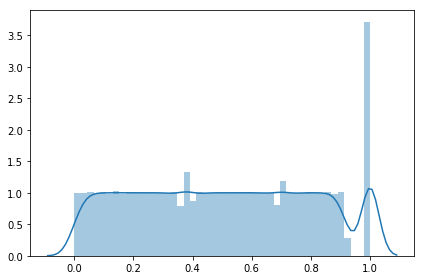

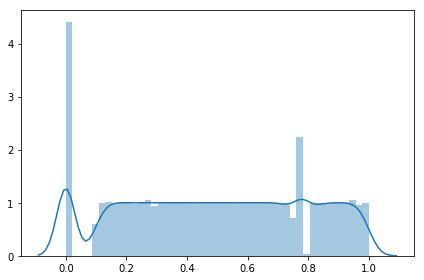

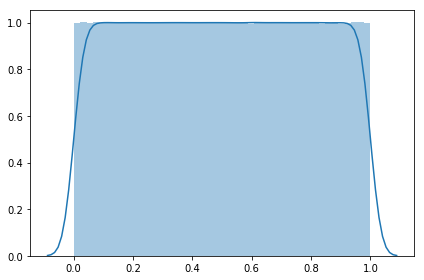

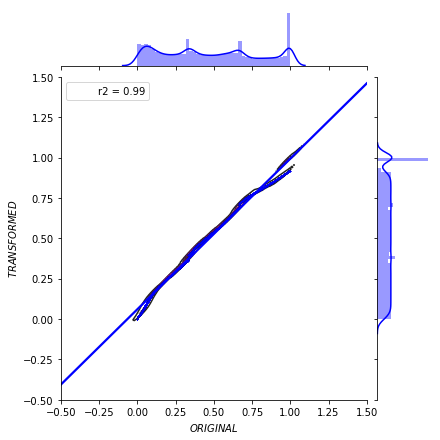

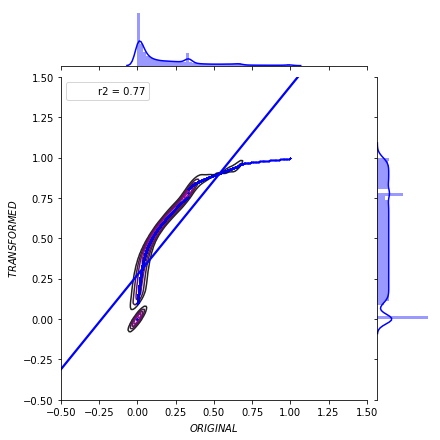

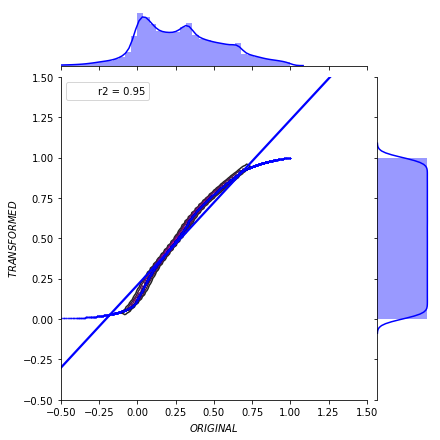

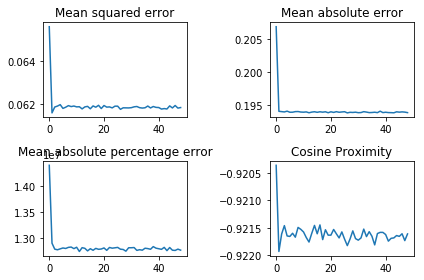

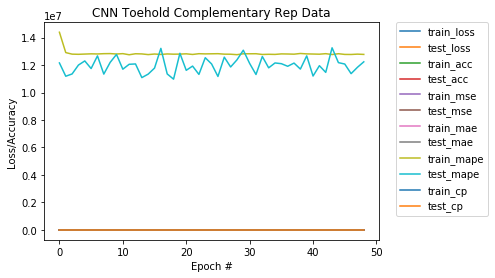

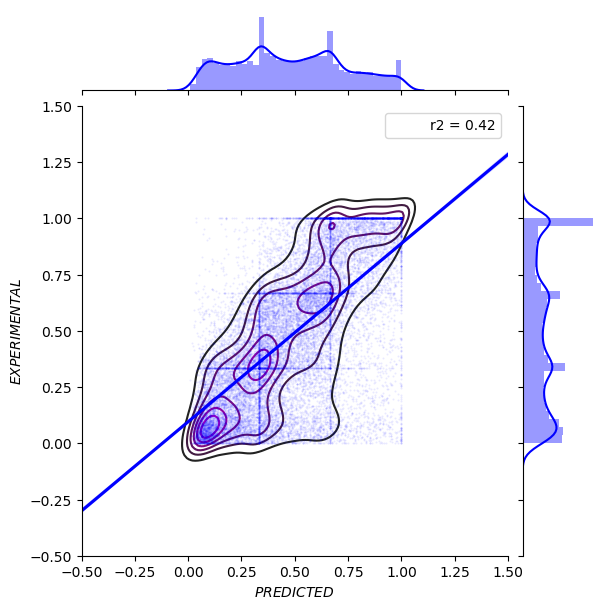

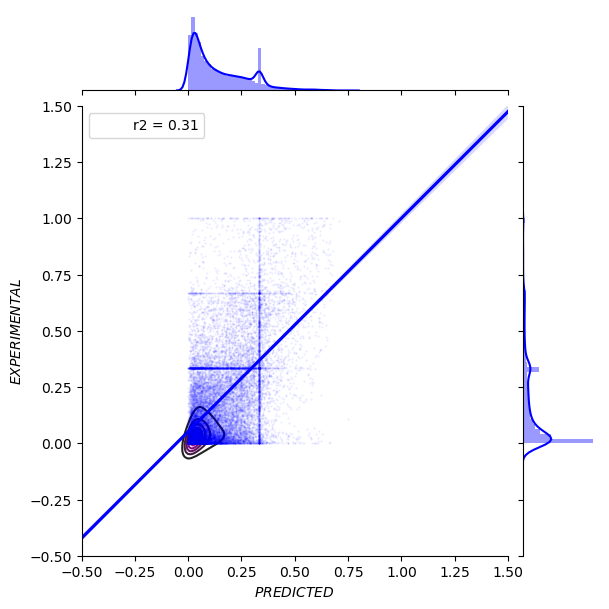

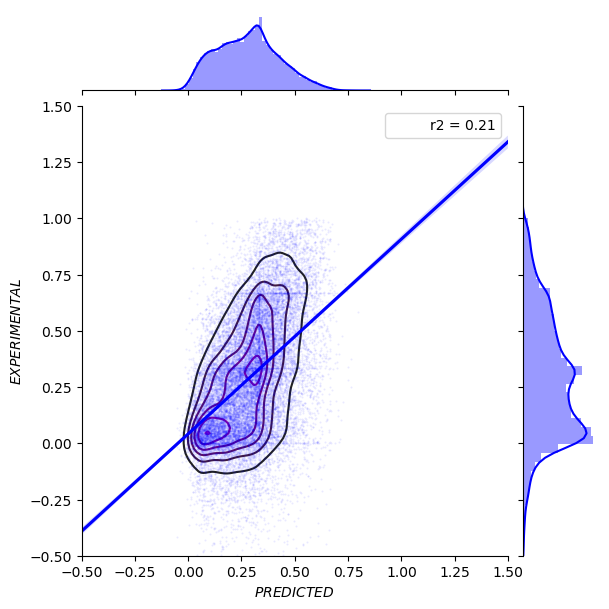

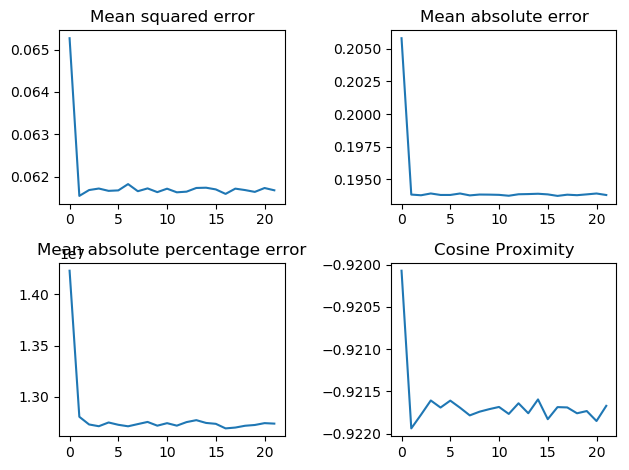

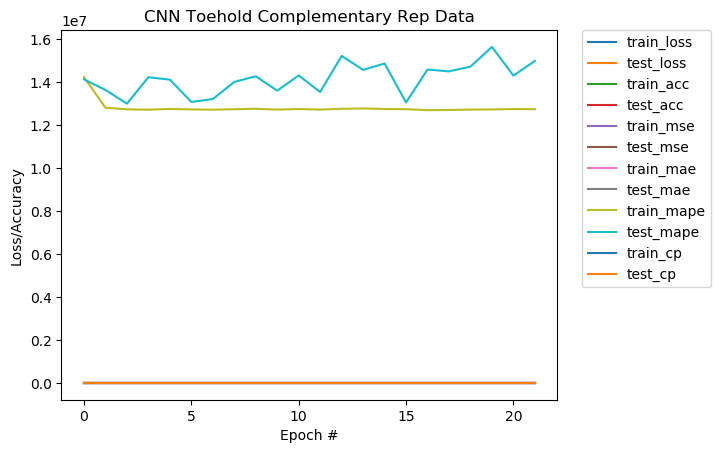

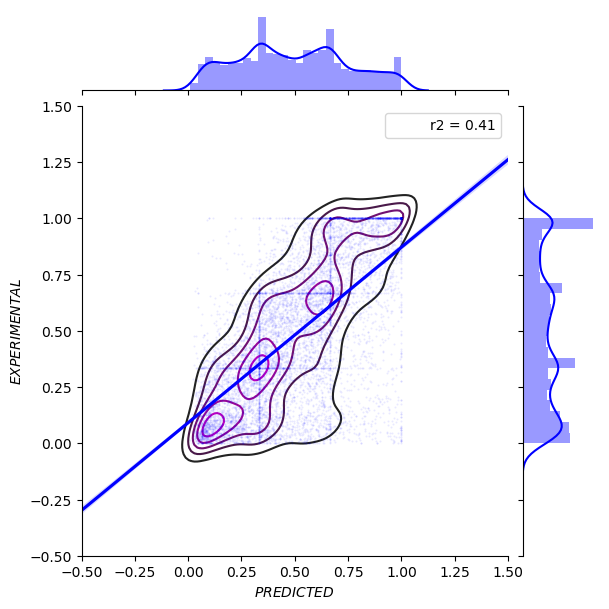

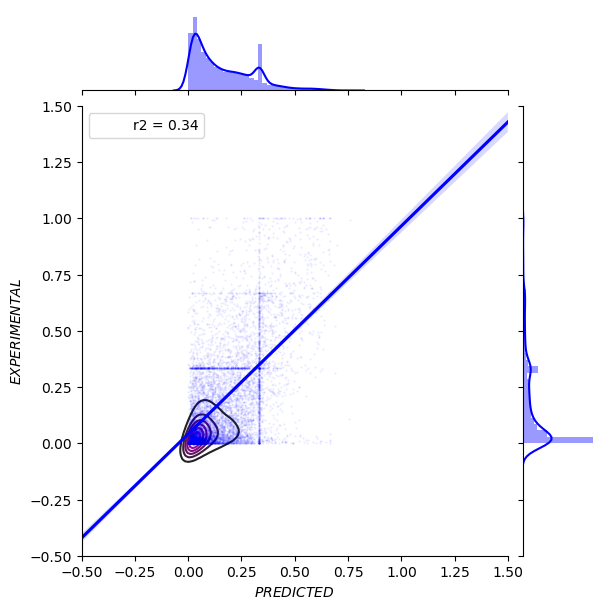

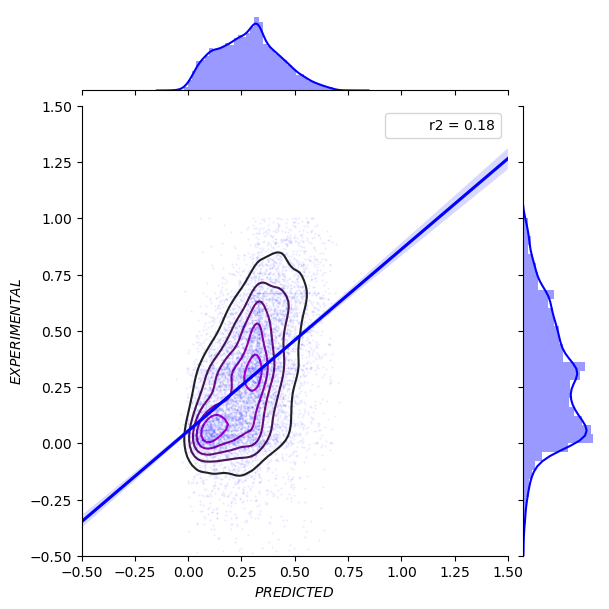

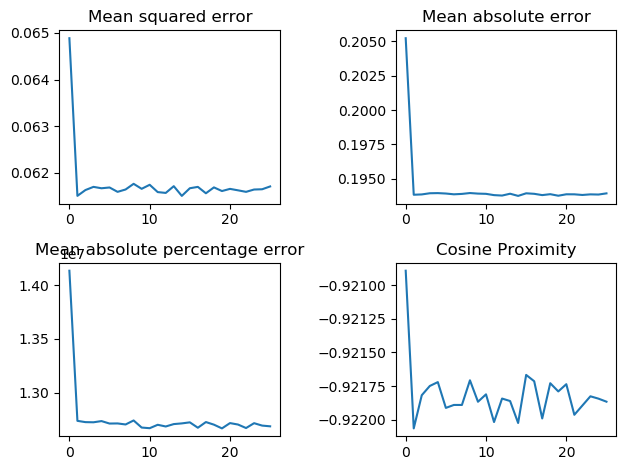

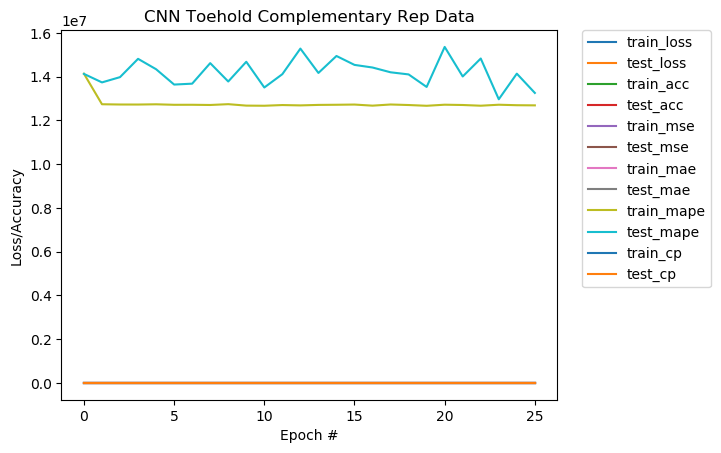

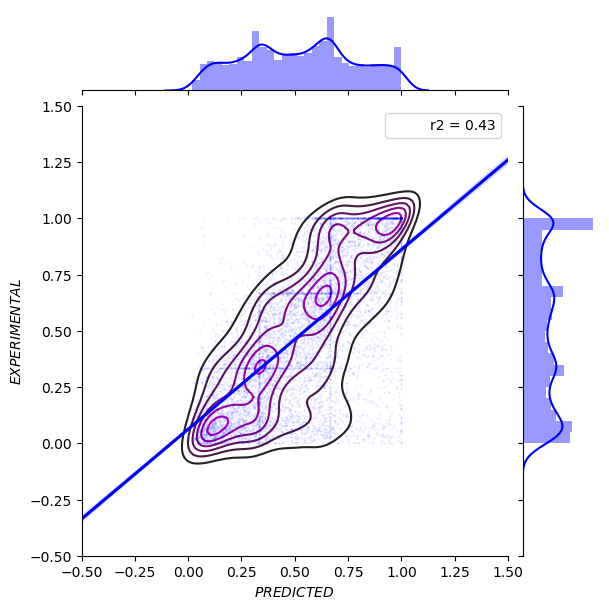

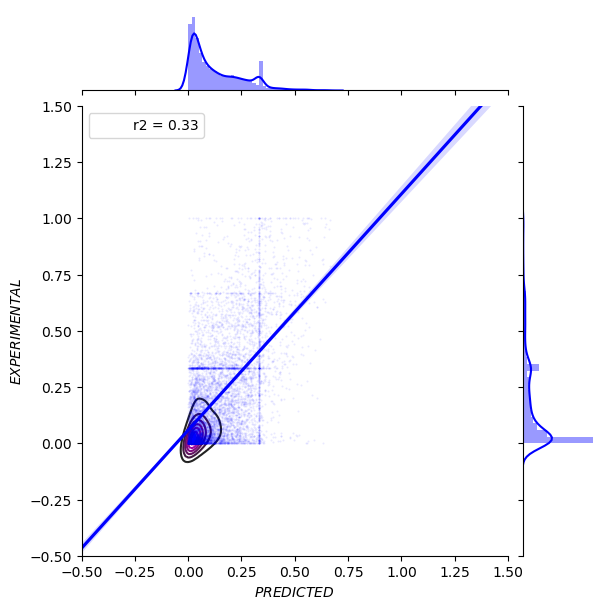

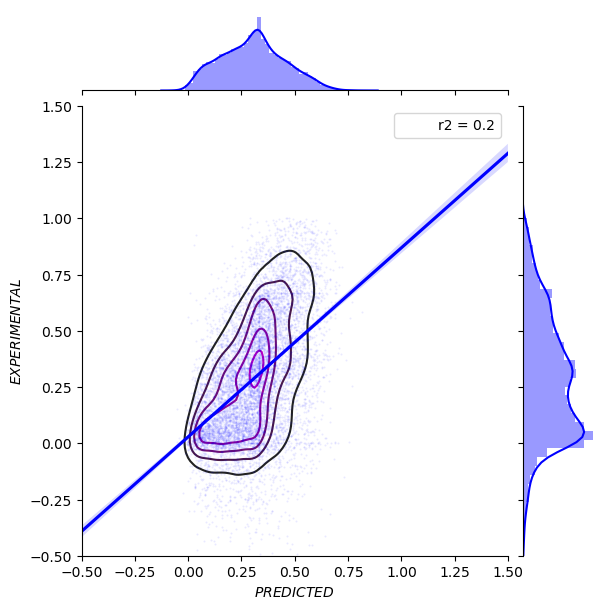

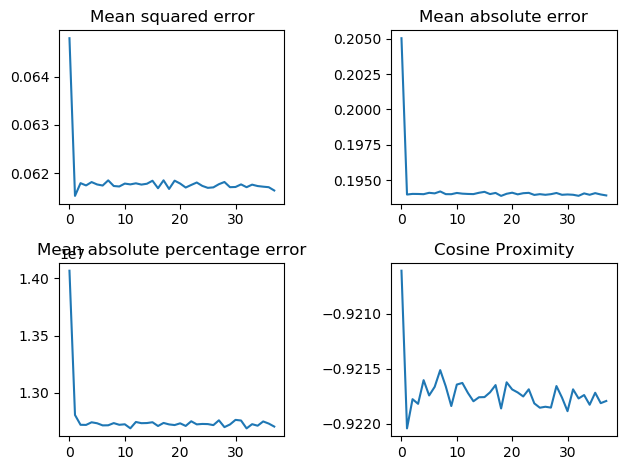

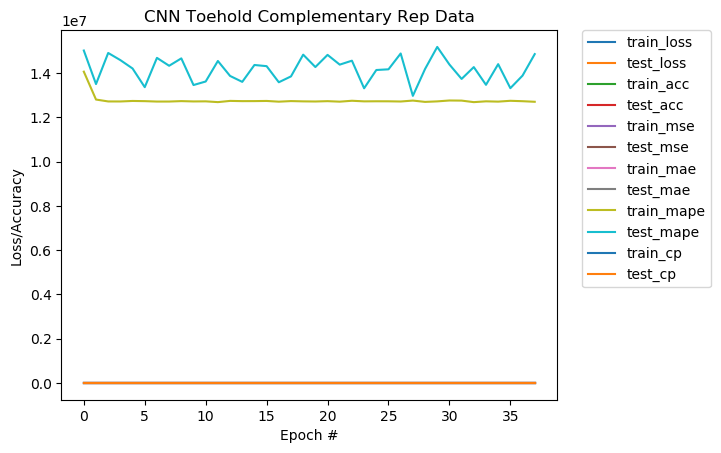

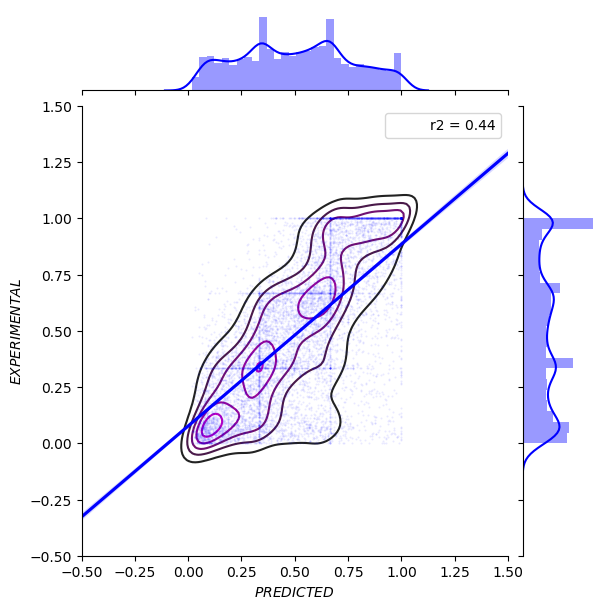

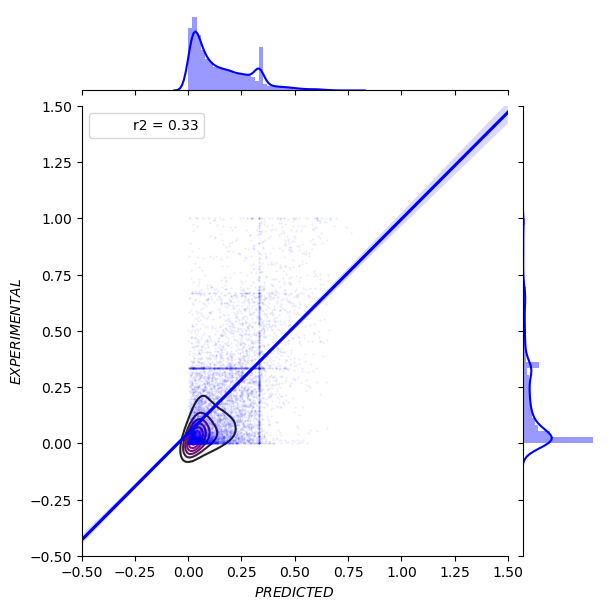

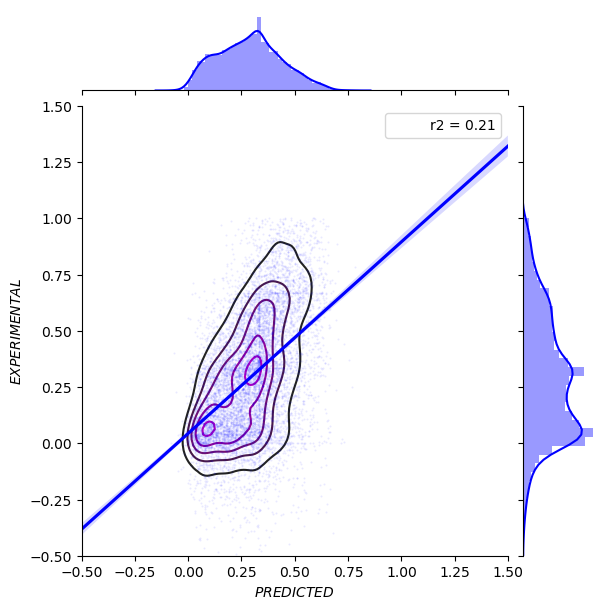

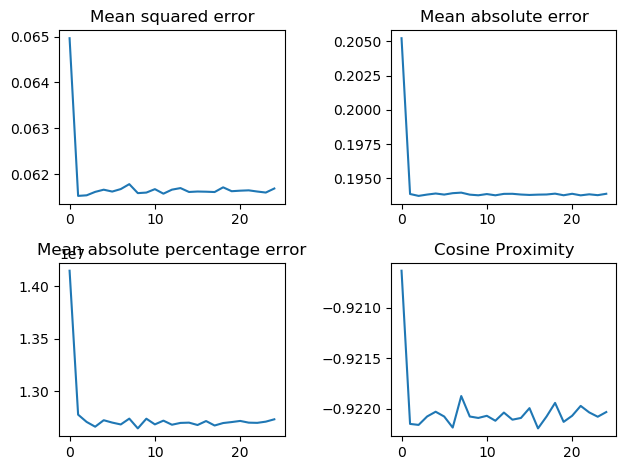

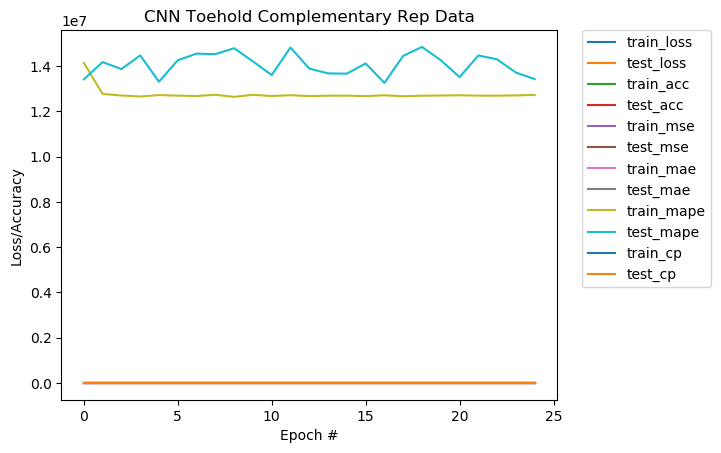

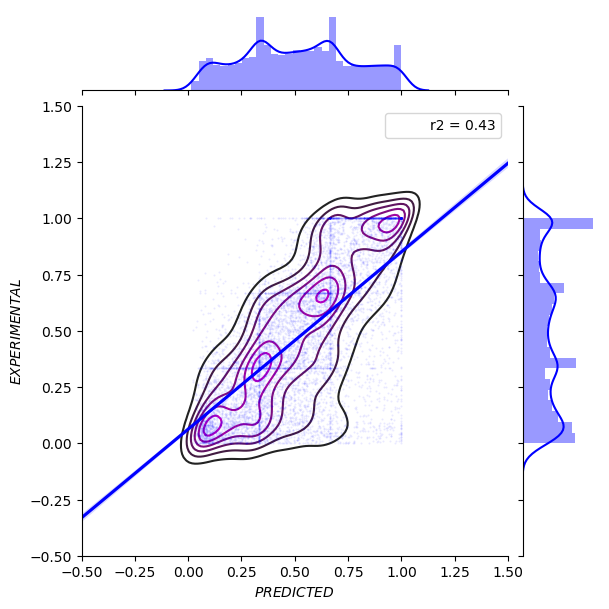

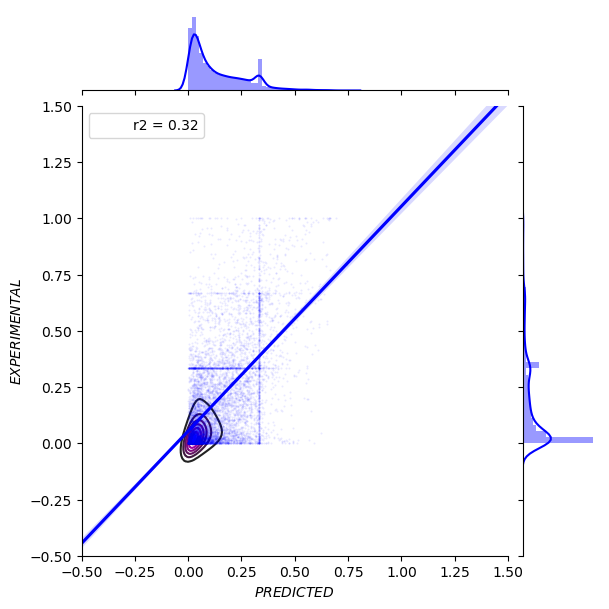

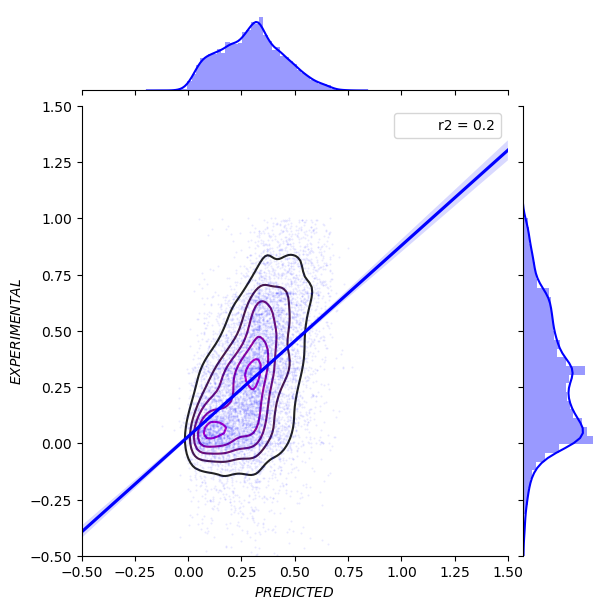

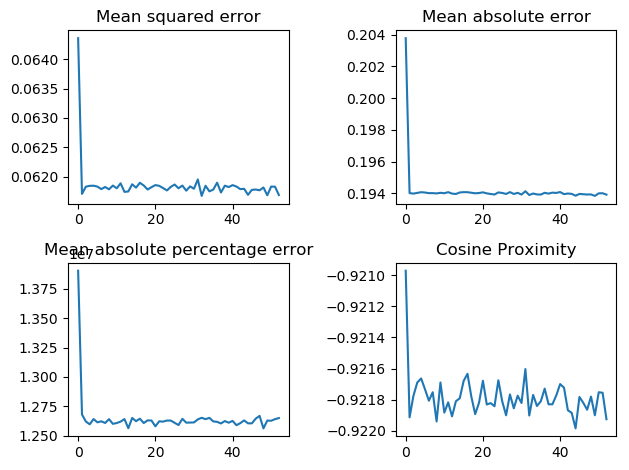

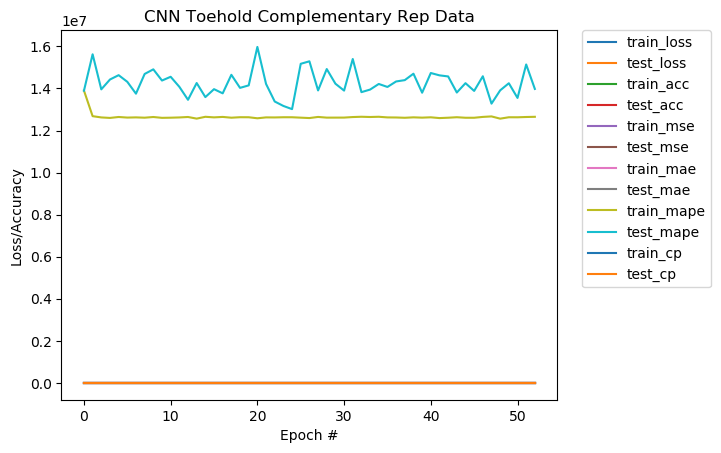

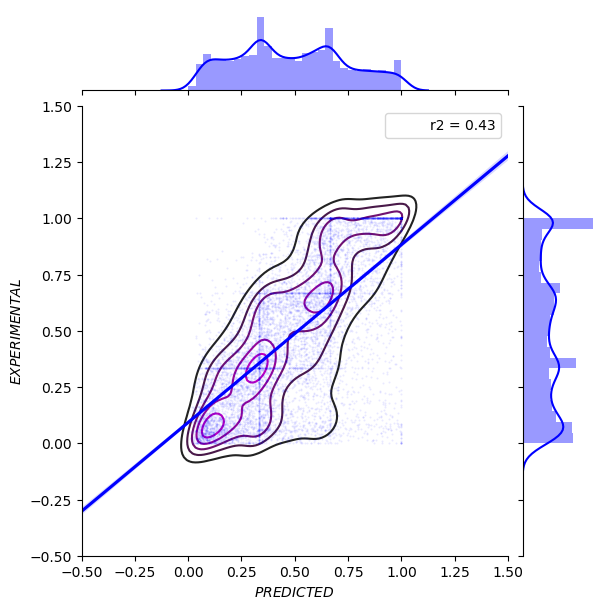

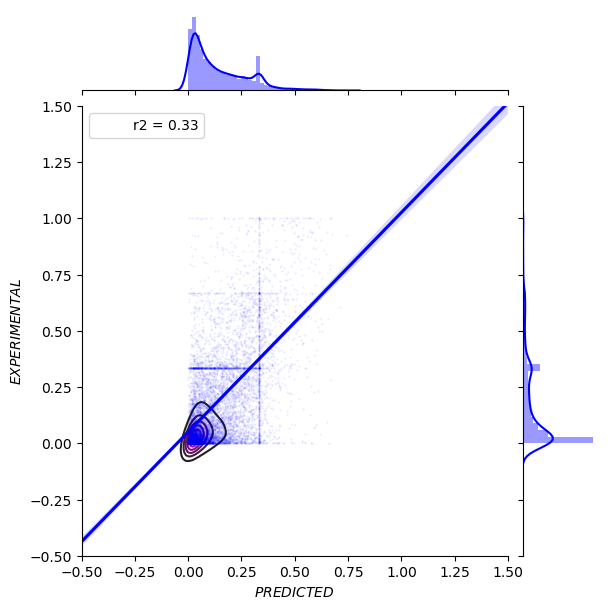

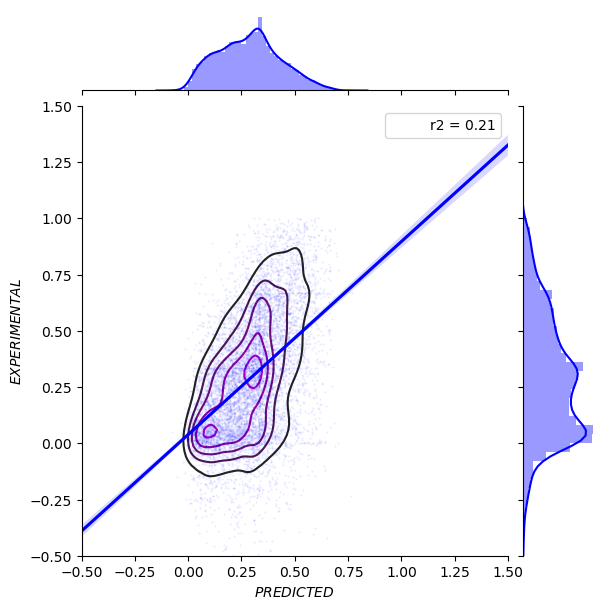

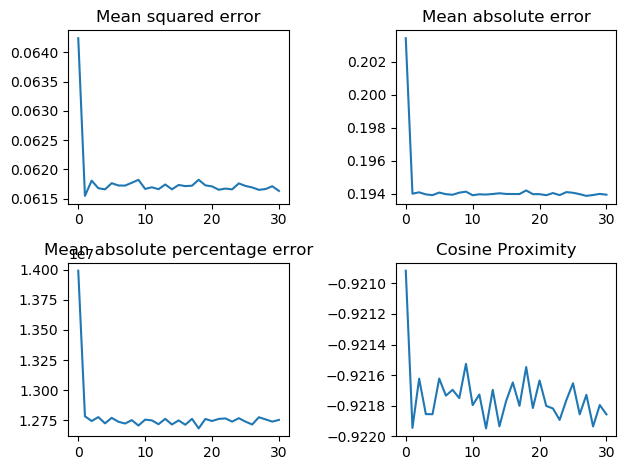

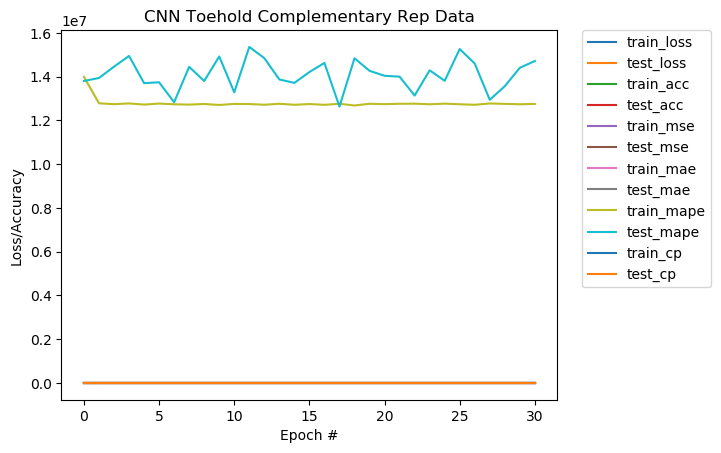

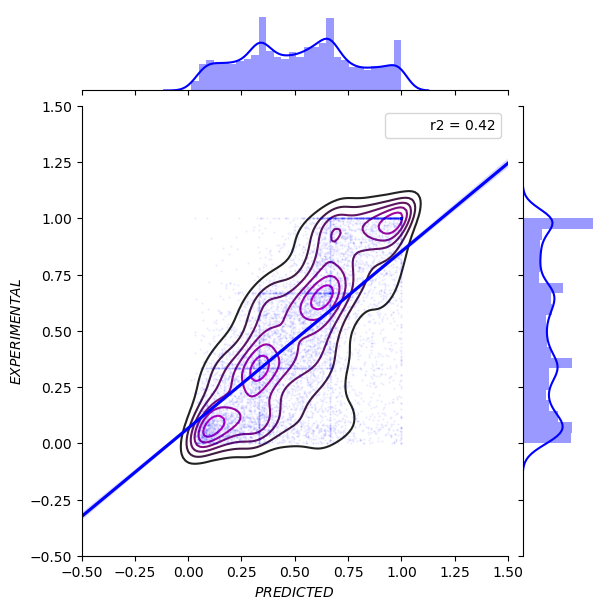

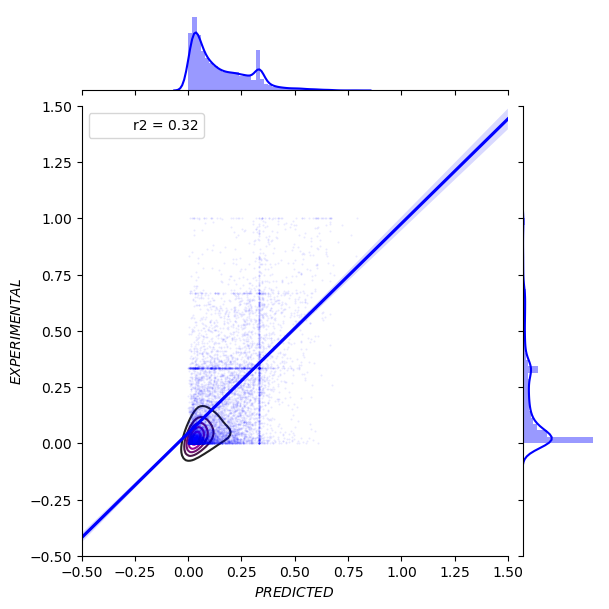

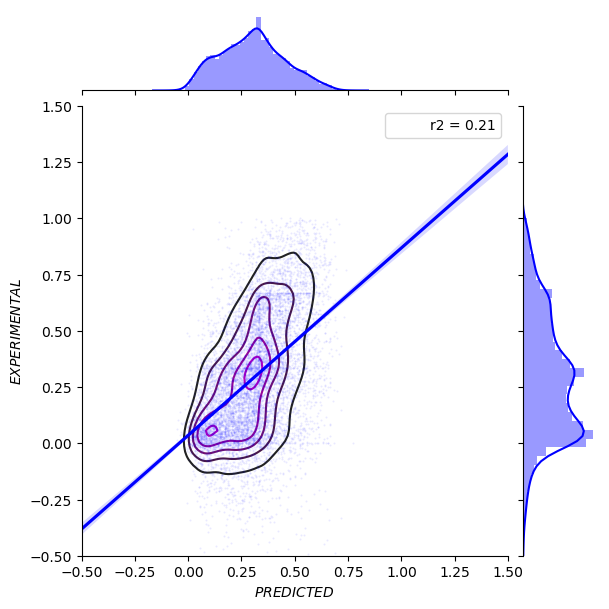

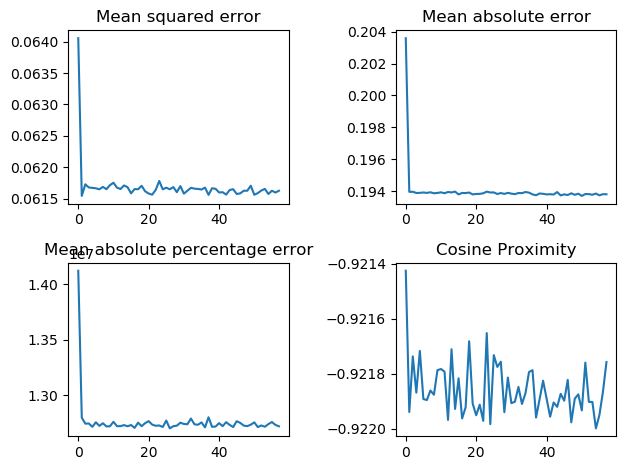

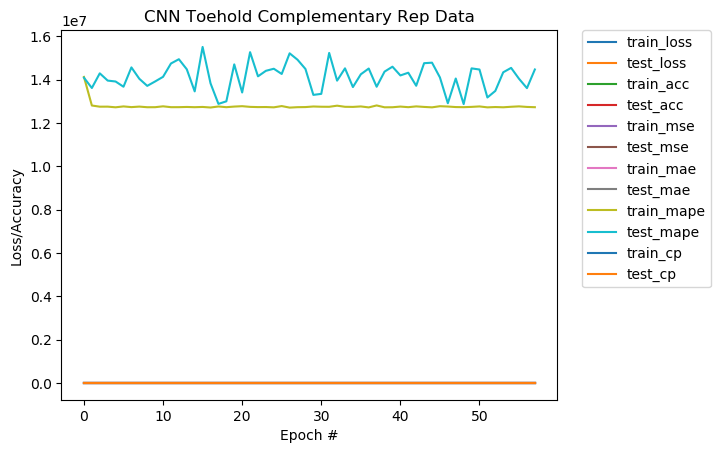

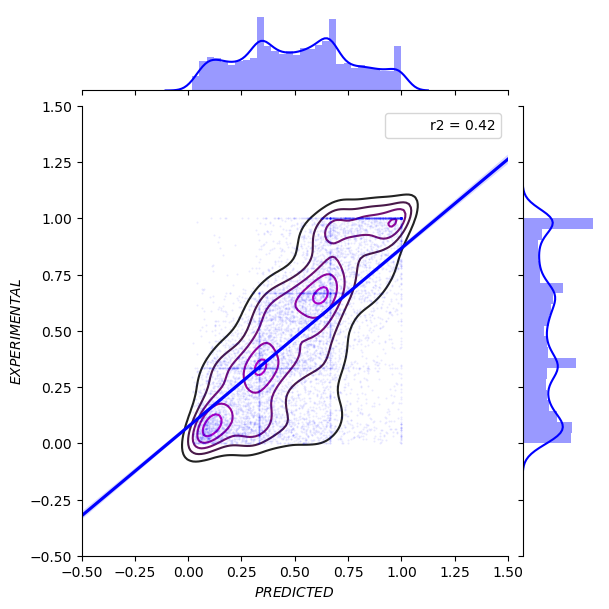

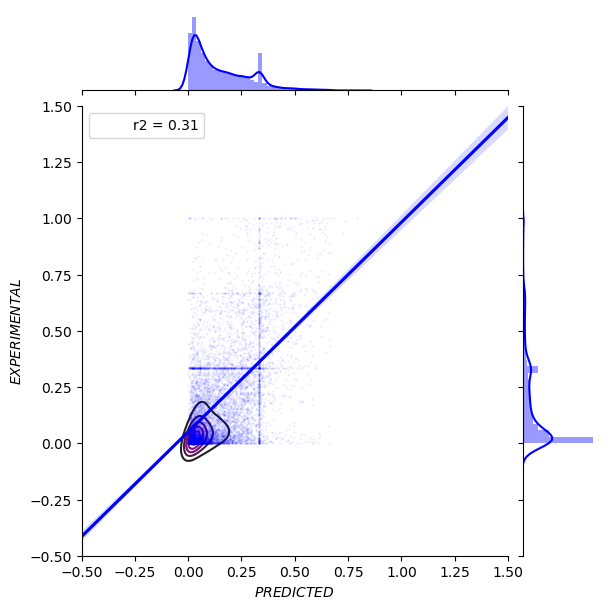

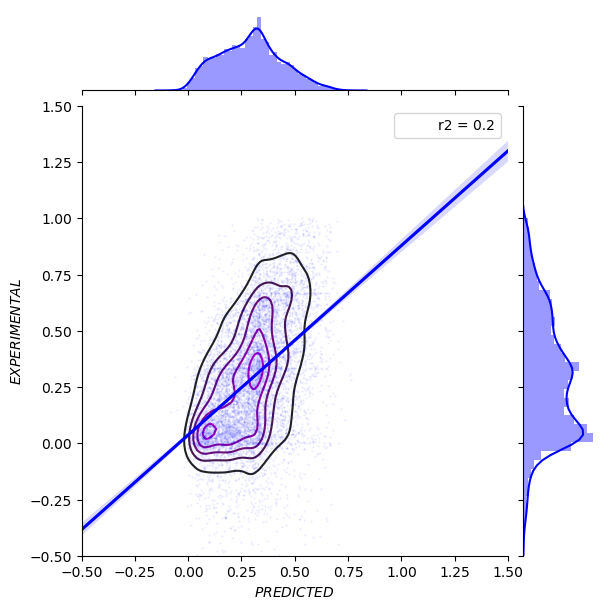

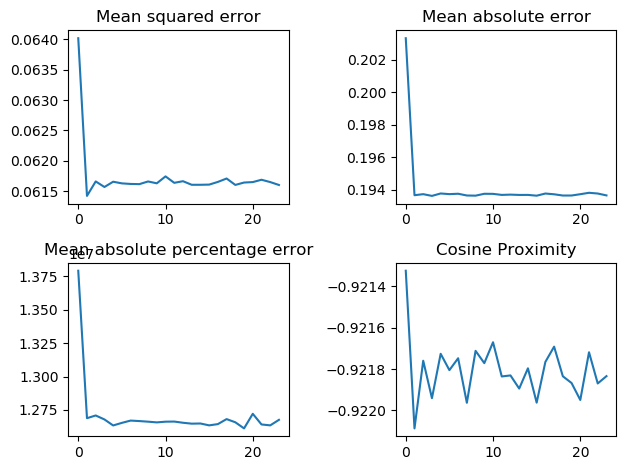

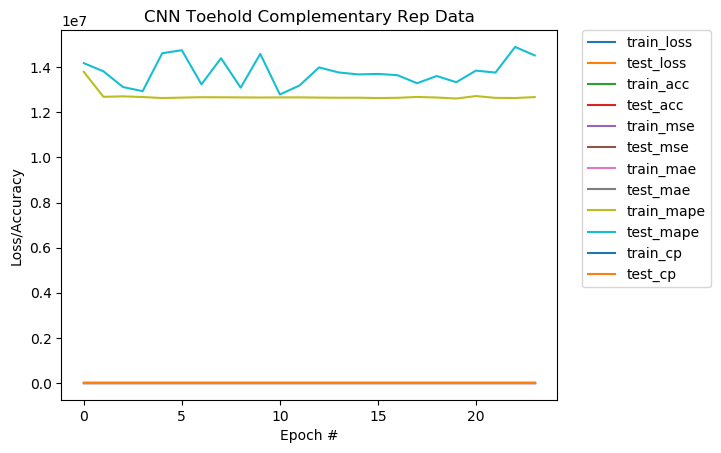

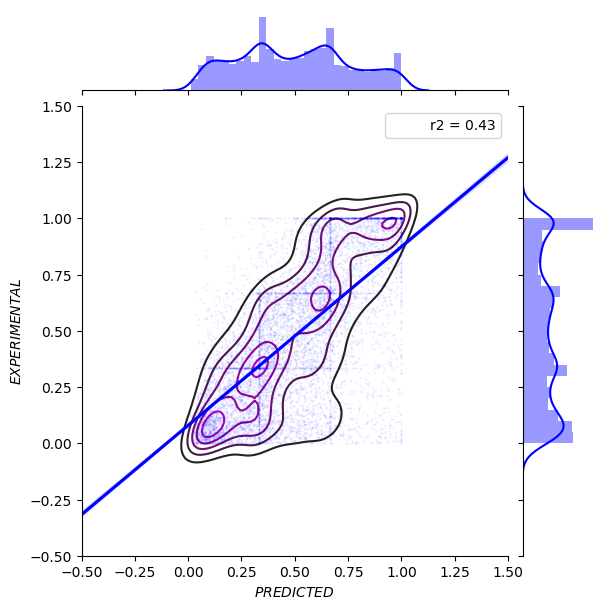

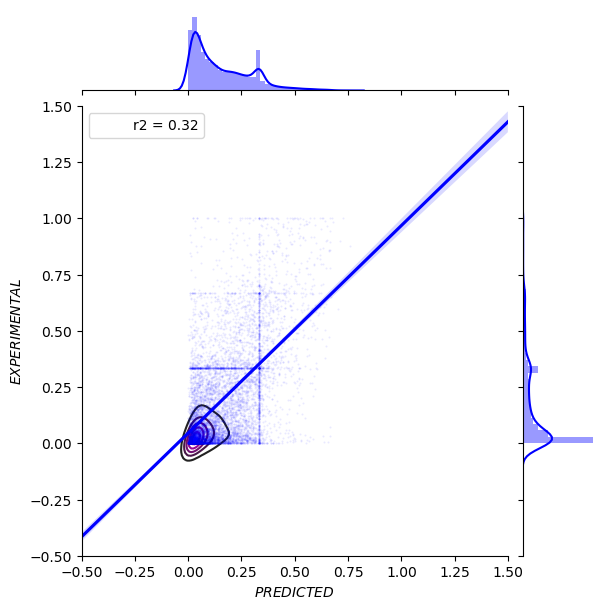

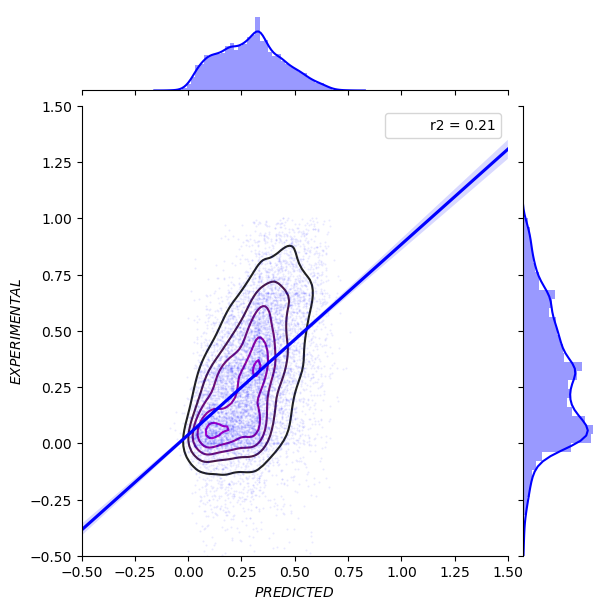

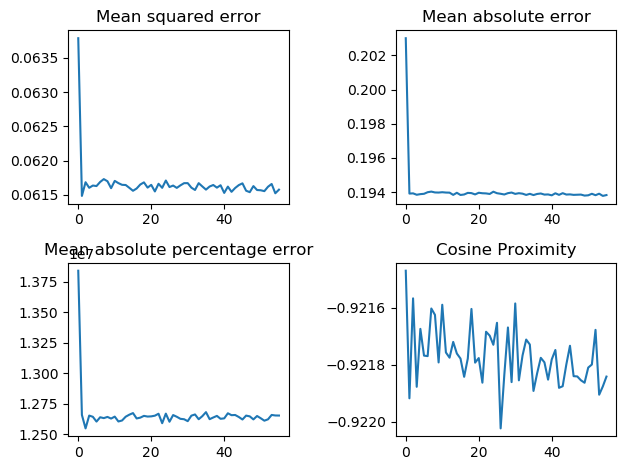

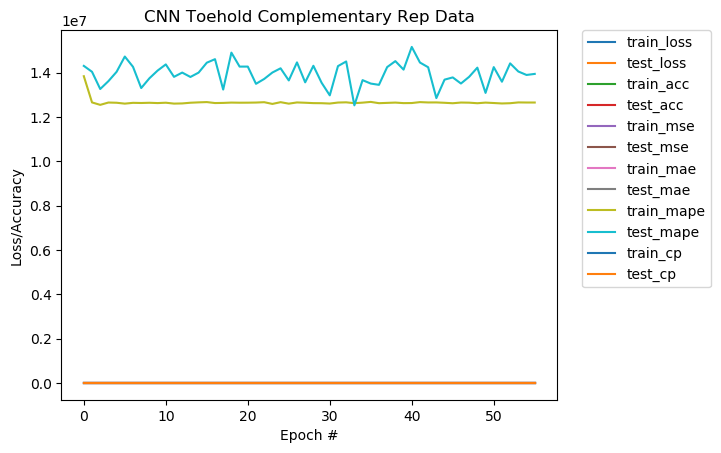

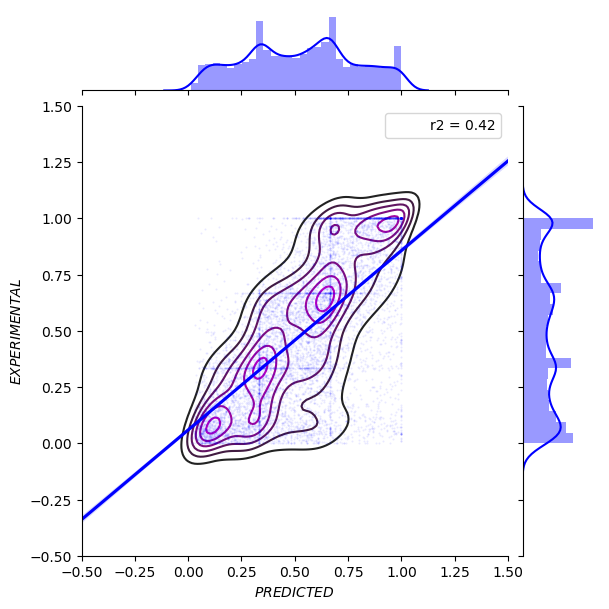

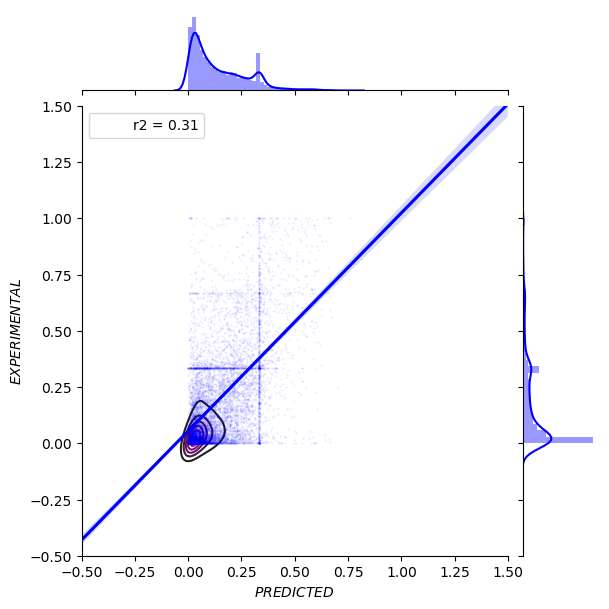

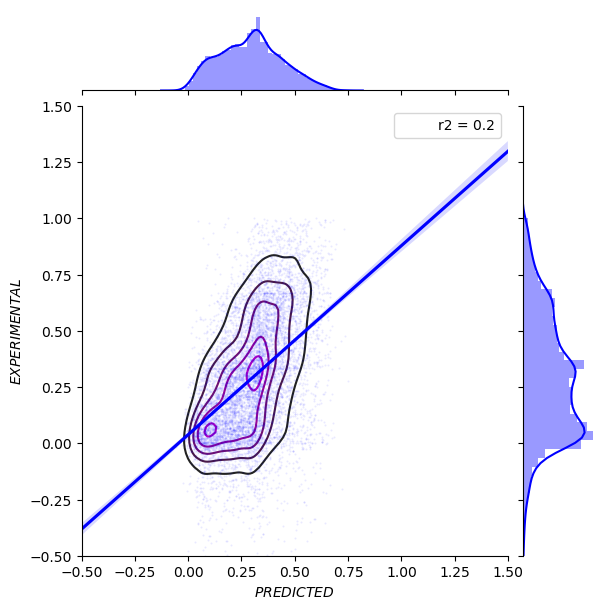

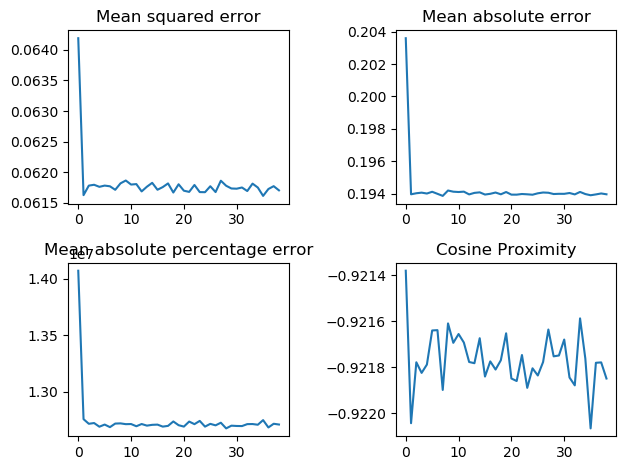

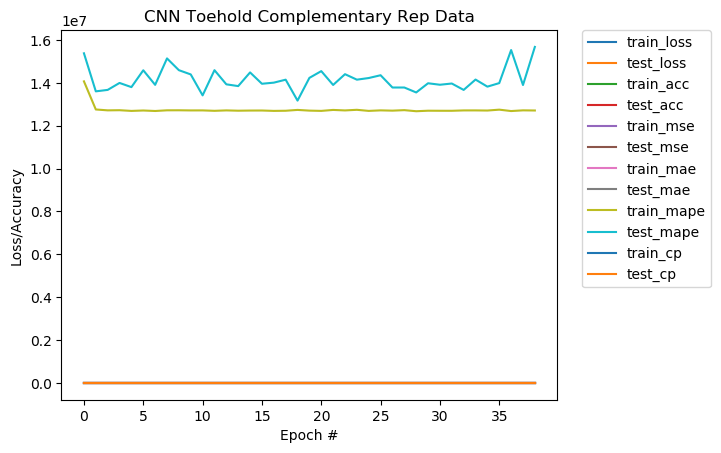

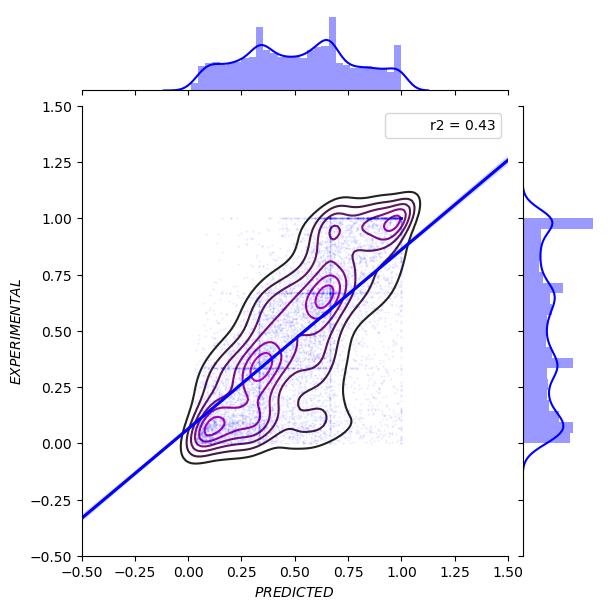

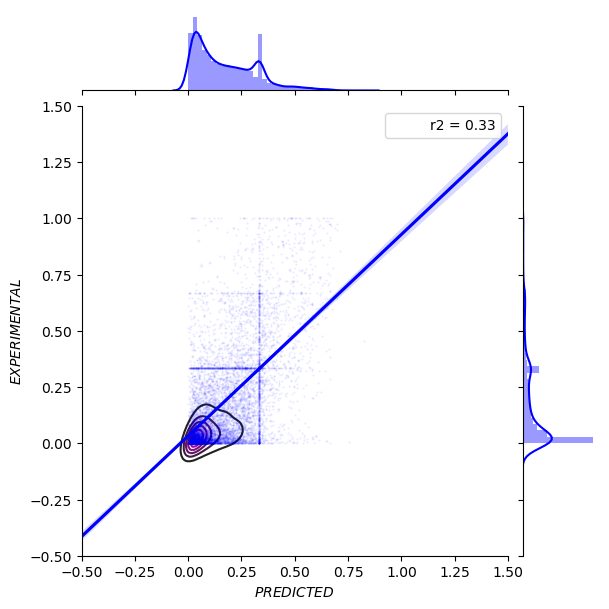

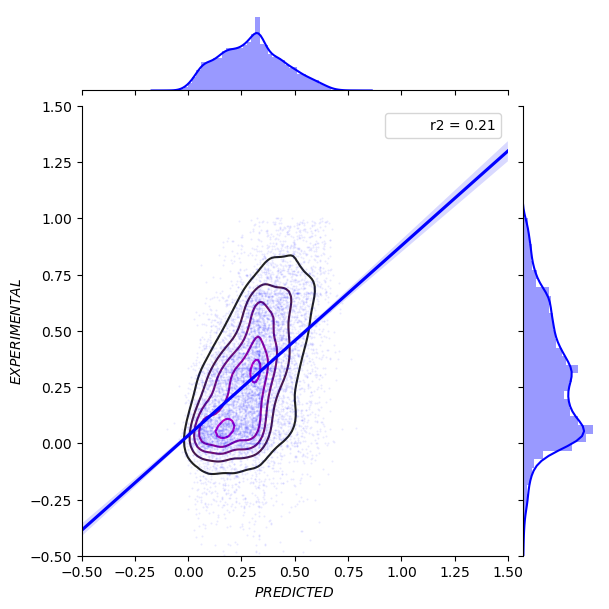

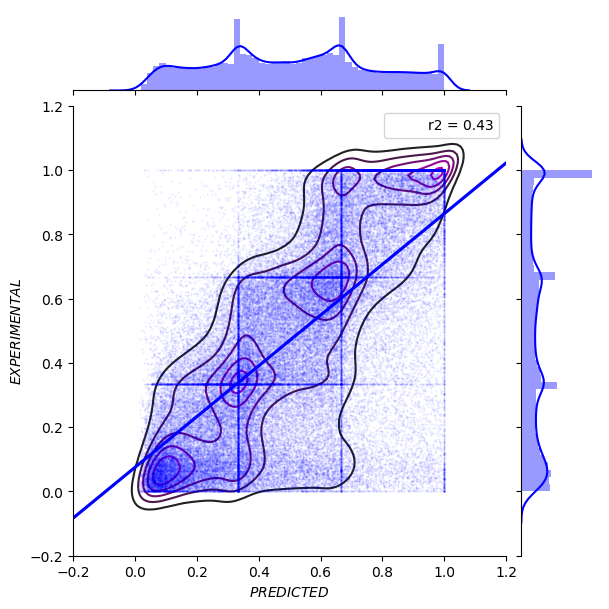

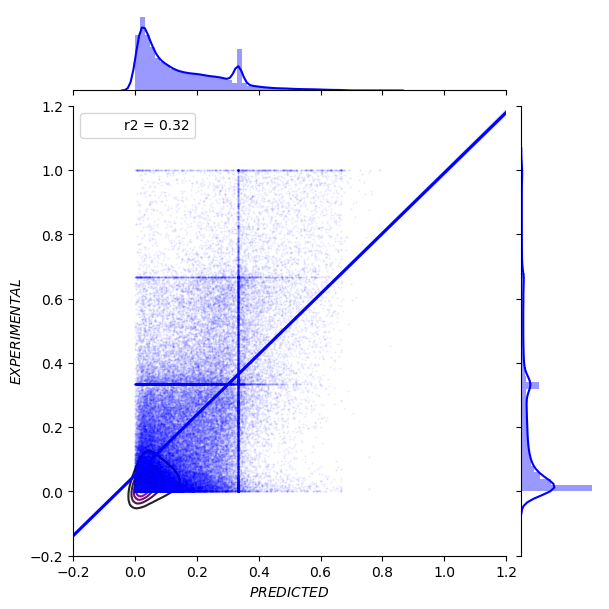

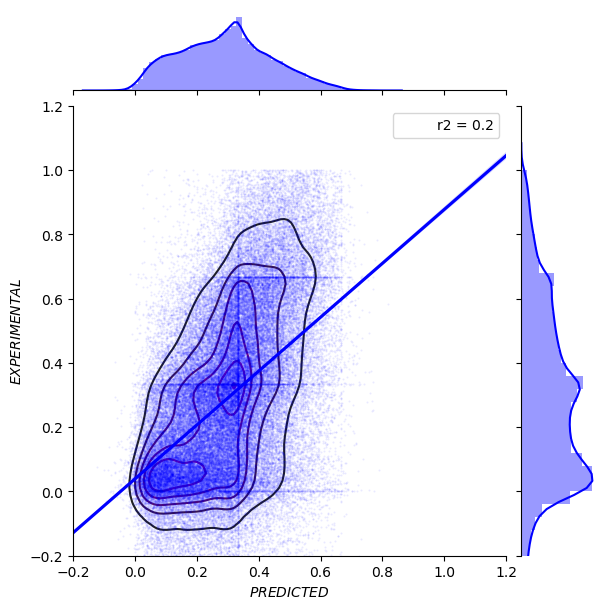

In [13]:
# RUN FULL MODEL ANALYSIS AND REPORTING model
execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE